In [6]:
#Function to generate a 3-panel plot for input arrays
def plot_array(dem, clim=None, titles=None, cmap='inferno', label=None, overlay=None, fn=None, close_fig=True):
    fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(10,5))
    alpha = 1.0
    #Gray background
    ax.set_facecolor('0.5')
    #Force aspect ratio to match images
    ax.set(aspect='equal')
    #Turn off axes labels/ticks
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if titles is not None:
        ax.set_title(titles[0])
    #Plot background shaded relief map
    if overlay is not None:
        alpha = 0.7
        ax.imshow(overlay, cmap='gray', clim=(1,255))
    #Plot each array
    im_list = [ax.imshow(dem, clim=clim, cmap=cmap, alpha=alpha)]
    fig.tight_layout()
    fig.colorbar(im_list[0], label=label, extend='both', shrink=0.5)
    if fn is not None:
        fig.savefig(fn, bbox_inches='tight', pad_inches=0, dpi=150)
    if close_fig:
        plt.close(fig)


def nearest_nonzero_idx(a,x,y):
    r,c = np.nonzero(a)
    min_idx = ((r - x)**2 + (c - y)**2).argmin()
    return r[min_idx], c[min_idx]


def maskedarray_gt(data, value):
    """ Greater than operation on masked array to avoid warning errors """
    data = np.nan_to_num(data,0)
    data[data > value] = value
    return data


def maskedarray_lt(data, value):
    """ Less than operation on masked array to avoid warning errors """
    data = np.nan_to_num(data,0)
    data[data < value] = value
    return data


def ts_fromdebris_func(h, a, b, c):
        """ estimate surface temperature from debris thickness (h is debris thickness, a and k are coefficients) 
        Hill Equation"""
        return a * h**c / (b**c + h**c)
def debris_fromts_func(ts, a, b, c):
    """ estimate debris thickness from surface temperature (ts is surface temperature, a and k are coefficients) 
    Hill Equation"""
    return (ts * b**c / (a - ts))**(1/c)

def debris_fromts_maskedarray(ts_raw, a, b, c):
    """ Apply debris_fromts_func to masked array
        includes a mask of maximum values, since Michaelis-Mentin Equation has natural maximum 
    Parameters
    ----------
    ts_raw : np.ma.array
        masked array of the unmodified surface temperature
    Returns
    -------
    hd : np.ma.array 
        masked array of the debris thickness (m)
    """
    ts = ts_raw.copy()
    max_value = ts_fromdebris_func(50, a, b, c)
    debris_thick_ts = np.ma.array(maskedarray_gt(ts.data, max_value), mask=np.ma.getmask(ts))
    debris_thick_ts = np.ma.array(maskedarray_lt(ts.data, 0), mask=np.ma.getmask(ts))
    hd = debris_fromts_func(ts.data, a, b, c)
    return hd


def emergence_pixels(gf, vel_x_raw, vel_y_raw, icethickness_raw, xres, yres, 
                     vel_min=0, max_velocity=600, vel_depth_avg_factor=0.8, option_border=1,
                     positive_is_east=True, positive_is_north=True, constant_icethickness=False, debug=True):
    """ Compute the emergence velocity using an ice flux approach
    """
    # Glacier mask
    glac_mask = np.zeros(vel_x_raw.shape) + 1
    glac_mask[gf.z1.mask] = 0
    
    # Modify vel_y by multiplying velocity by -1 such that matrix operations agree with flow direction
    #    Specifically, a negative y velocity means the pixel is flowing south.
    #    However, if you were to subtract that value from the rows, it would head north in the matrix.
    #    This is due to the fact that the number of rows start at 0 at the top.
    #    Therefore, multipylying by -1 aligns the matrix operations with the flow direction
    if positive_is_north:
        vel_y = -1*vel_y_raw * vel_depth_avg_factor
    else:
        vel_y = vel_y_raw * vel_depth_avg_factor
    if positive_is_east:
        vel_x = vel_x_raw * vel_depth_avg_factor
    else:
        vel_x = -1*vel_x_raw * vel_depth_avg_factor
    vel_total = (vel_y**2 + vel_x**2)**0.5
    # Ice thickness
    icethickness = icethickness_raw.copy()
    if constant_icethickness:
        icethickness[:,:] = 1
        icethickness = icethickness * glac_mask
#     print('mean ice thickness:', np.round(icethickness.mean(),0), 'm')
    # Compute the initial volume
    volume_initial = icethickness * (xres * yres)
    pix_maxres = xres
    if yres > pix_maxres:
        pix_maxres = yres
    # Quality control options:
    # Apply a border based on the max specified velocity to prevent errors associated with pixels going out of bounds
    if option_border == 1:
        border = int(max_velocity / pix_maxres) + 1
        for r in range(vel_x.shape[0]):
            for c in range(vel_x.shape[1]):
                if (r < border) | (r >= vel_x.shape[0] - border) | (c < border) | (c >= vel_x.shape[1] - border):
                    vel_x[r,c] = 0
                    vel_y[r,c] = 0
    # Minimum/maximum velocity bounds
    vel_x[vel_total < vel_min] = 0
    vel_y[vel_total < vel_min] = 0
    vel_x[vel_total > max_velocity] = 0
    vel_y[vel_total > max_velocity] = 0
#     # Remove clusters of high velocity on stagnant portions of glaciers due to feature tracking of ice cliffs and ponds
#     if option_stagnantbands == 1:
#         vel_x[bands <= stagnant_band] = 0
#         vel_y[bands <= stagnant_band] = 0        
    # Compute displacement in units of pixels
    vel_x_pix = vel_x / xres
    vel_y_pix = vel_y / yres
    # Compute the displacement and fraction of pixels moved for all columns (x-axis)
    # col_x1 is the number of columns to the closest pixel receiving ice [ex. 2.6 returns 2, -2.6 returns -2]
    #    int() automatically rounds towards zero
    col_x1 = vel_x_pix.astype(int)
    # col_x2 is the number of columns to the further pixel receiving ice [ex. 2.6 returns 3, -2.6 returns -3]
    #    np.sign() returns a value of 1 or -1, so it's adding 1 pixel away from zero
    col_x2 = (vel_x_pix + np.sign(vel_x_pix)).astype(int)
    # rem_x2 is the fraction of the pixel that remains in the further pixel (col_x2) [ex. 2.6 returns 0.6, -2.6 returns 0.6]
    #    np.sign() returns a value of 1 or -1, so multiplying by that ensures you have a positive value
    #    then when you take the remainder using "% 1", you obtain the desired fraction
    rem_x2 = np.multiply(np.sign(vel_x_pix), vel_x_pix) % 1
    # rem_x1 is the fraction of the pixel that remains in the closer pixel (col_x1) [ex. 2.6 returns 0.4, -2.6 returns 0.4]
    rem_x1 = 1 - rem_x2
    # Repeat the displacement and fraction computations for all rows (y-axis)
    row_y1 = vel_y_pix.astype(int)
    row_y2 = (vel_y_pix + np.sign(vel_y_pix)).astype(int)
    rem_y2 = np.multiply(np.sign(vel_y_pix), vel_y_pix) % 1
    rem_y1 = 1 - rem_y2
          
    # Compute the mass flux for each pixel
    volume_final = np.zeros(volume_initial.shape)
    for r in range(vel_x.shape[0]):
        for c in range(vel_x.shape[1]):
            volume_final[r+row_y1[r,c], c+col_x1[r,c]] = (
                volume_final[r+row_y1[r,c], c+col_x1[r,c]] + rem_y1[r,c]*rem_x1[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y2[r,c], c+col_x1[r,c]] = (
                volume_final[r+row_y2[r,c], c+col_x1[r,c]] + rem_y2[r,c]*rem_x1[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y1[r,c], c+col_x2[r,c]] = (
                volume_final[r+row_y1[r,c], c+col_x2[r,c]] + rem_y1[r,c]*rem_x2[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y2[r,c], c+col_x2[r,c]] = (
                volume_final[r+row_y2[r,c], c+col_x2[r,c]] + rem_y2[r,c]*rem_x2[r,c]*volume_initial[r,c]
                )
         
    # Redistribute off-glacier volume back onto the nearest pixel on the glacier
    offglac_row, offglac_col = np.where((glac_mask == 0) & (volume_final > 0))
    for nidx in range(0,len(offglac_row)):
        nrow = offglac_row[nidx]
        ncol = offglac_col[nidx]
        ridx, cidx = nearest_nonzero_idx(glac_mask, nrow, ncol)
        # Add off-glacier volume back onto nearest pixel on glacier
        volume_final[ridx,cidx] += volume_final[nrow,ncol]
        volume_final[nrow,ncol] = 0
            
    # Check that mass is conserved (threshold = 0.1 m x pixel_size**2)
    if debug:
        print('Mass is conserved?', np.absolute(volume_final.sum() - volume_initial.sum()) / volume_initial.sum() < 0.01)
        print(np.round(np.absolute(volume_final.sum() - volume_initial.sum()),1), 
              np.round(np.absolute(volume_final.sum() - volume_initial.sum()) / volume_initial.sum() * 100,2), '%')
        
    if np.absolute(volume_final.sum() - volume_initial.sum()) / volume_initial.sum() > 0.01:
        print('MASS NOT CONSERVED FOR EMERGENCE VELOCITY')
    # Final ice thickness
    icethickness_final = volume_final / (xres * yres)
    # Emergence velocity
    emergence_velocity = icethickness_final - icethickness
    return emergence_velocity



class GlacFeat:
    def __init__(self, feat, glacname_fieldname, glacnum_fieldname):

        self.glacname = feat.GetField(glacname_fieldname)
        if self.glacname is None:
            self.glacname = ""
        else:
            #RGI has some nonstandard characters
            #self.glacname = self.glacname.decode('unicode_escape').encode('ascii','ignore')
            #glacname = re.sub(r'[^\x00-\x7f]',r'', glacname)
            self.glacname = re.sub(r'\W+', '', self.glacname)
            self.glacname = self.glacname.replace(" ", "")
            self.glacname = self.glacname.replace("_", "")
            self.glacname = self.glacname.replace("/", "")

        self.glacnum = feat.GetField(glacnum_fieldname)
        fn = feat.GetDefnRef().GetName()
        #RGIId (String) = RGI50-01.00004
        self.glacnum = '%0.5f' % float(self.glacnum.split('-')[-1])

        if self.glacname:
            self.feat_fn = "%s_%s" % (self.glacnum, self.glacname)
        else:
            self.feat_fn = str(self.glacnum)

        self.glac_geom_orig = geolib.geom_dup(feat.GetGeometryRef())
        self.glac_geom = geolib.geom_dup(self.glac_geom_orig)
        #Hack to deal with fact that this is not preserved in geom when loaded from pickle on disk
        self.glac_geom_srs_wkt = self.glac_geom.GetSpatialReference().ExportToWkt()

        #Attributes written by mb_calc
        self.z1 = None
        self.z1_hs = None
        self.z1_stats = None
        self.z1_ela = None
        self.z2 = None
        self.z2_hs = None
        self.z2_stats = None
        self.z2_ela = None
        self.z2_aspect = None
        self.z2_aspect_stats = None
        self.z2_slope = None
        self.z2_slope_stats = None
        self.res = None
        self.dhdt = None
        self.mb = None
        self.mb_mean = None
        self.t1 = None
        self.t2 = None
        self.dt = None
        self.t1_mean = None
        self.t2_mean = None
        self.dt_mean = None

        self.H = None
        self.H_mean = np.nan
        self.vx = None
        self.vy = None
        self.vm = None
        self.vm_mean = np.nan
        self.divQ = None
        self.emvel = None
        self.debris_class = None
        self.debris_thick = None
        self.debris_thick_mean = np.nan
        self.perc_clean = np.nan
        self.perc_debris = np.nan
        self.perc_pond = np.nan

    def geom_srs_update(self, srs=None):
        if self.glac_geom.GetSpatialReference() is None:
            if srs is None:
                srs = osr.SpatialReference()
                srs.ImportFromWkt(self.glac_geom_srs_wkt)
            self.glac_geom.AssignSpatialReference(srs)

    def geom_attributes(self, srs=None):
        self.geom_srs_update()
        if srs is not None:
            #Should reproject here to equal area, before geom_attributes
            #self.glac_geom.AssignSpatialReference(glac_shp_srs)
            #self.glac_geom_local = geolib.geom2localortho(self.glac_geom)
            geolib.geom_transform(self.glac_geom, srs)

        self.glac_geom_extent = geolib.geom_extent(self.glac_geom)
        self.glac_area = self.glac_geom.GetArea()
        self.glac_area_km2 = self.glac_area / 1E6
        self.cx, self.cy = self.glac_geom.Centroid().GetPoint_2D()
        
        
#RGI uses 50 m bins
def hist_plot(gf, bin_width=50.0, dz_clim=(-2.0, 2.0), exportcsv=True, csv_ending=''):
    #print("Generating histograms")
    #Create bins for full range of input data and specified bin width

    #NOTE: these counts/areas are for valid pixels only
    #Not necessarily a true representation of actual glacier hypsometry
    #Need a void-filled DEM for this

    z_bin_edges, z_bin_centers = malib.get_bins(gf.z1, bin_width)
    #Need to compress here, otherwise histogram uses masked values!
    z1_bin_counts, z1_bin_edges = np.histogram(gf.z1.compressed(), bins=z_bin_edges)
    z1_bin_areas = z1_bin_counts * gf.res[0] * gf.res[1] / 1E6
    #RGI standard is integer thousandths of glaciers total area
    #Should check to make sure sum of bin areas equals total area
    #z1_bin_areas_perc = 100. * z1_bin_areas / np.sum(z1_bin_areas)
    z1_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)

    #If we only have one elevation grid with dhdt
    if gf.z2 is not None:
        z2_bin_counts, z2_bin_edges = np.histogram(gf.z2.compressed(), bins=z_bin_edges)
        z2_bin_areas = z2_bin_counts * gf.res[0] * gf.res[1] / 1E6
        #z2_bin_areas_perc = 100. * z2_bin_areas / np.sum(z2_bin_areas)
        z2_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)
    else:
        z2_bin_counts = z1_bin_counts
        z2_bin_edges = z1_bin_edges
        z2_bin_areas = z1_bin_areas
        z2_bin_areas_perc = z1_bin_areas_perc

    #Create arrays to store output
    slope_bin_med = np.ma.masked_all_like(z1_bin_areas)
    slope_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    aspect_bin_med = np.ma.masked_all_like(z1_bin_areas)
    aspect_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.dhdt is not None:
        mb_bin_med = np.ma.masked_all_like(z1_bin_areas)
        np.ma.set_fill_value(mb_bin_med, np.nan)
        mb_bin_mad = np.ma.masked_all_like(mb_bin_med)
        mb_bin_mean = np.ma.masked_all_like(mb_bin_med)
        mb_bin_std = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_med = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_mad = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_mean = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_std = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_count = np.ma.masked_all_like(mb_bin_med)
    if gf.vm is not None:
        vm_bin_med = np.ma.masked_all_like(z1_bin_areas)
        vm_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.H is not None:
        H_bin_mean = np.ma.masked_all_like(z1_bin_areas)
        H_bin_std = np.ma.masked_all_like(z1_bin_areas)
    if gf.emvel is not None:
        emvel_bin_mean = np.ma.masked_all_like(z1_bin_areas)
        emvel_bin_std = np.ma.masked_all_like(z1_bin_areas)
        emvel_bin_med = np.ma.masked_all_like(z1_bin_areas)
        emvel_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.debris_class is not None:
#         perc_clean = np.ma.masked_all_like(z1_bin_areas)
#         perc_debris = np.ma.masked_all_like(z1_bin_areas)
#         perc_pond = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_med = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_mad = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_clean_bin_med = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_debris_bin_med = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_pond_bin_med = np.ma.masked_all_like(mz1_bin_areas)

#         gf.dhdt_clean = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 1).data))
#         gf.dhdt_debris = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 2).data))
#         gf.dhdt_pond = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 3).data))

    if gf.debris_thick_ts is not None:
        debris_thick_ts_med = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_ts_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.meltfactor_ts is not None:
        meltfactor_ts_med = np.ma.masked_all_like(z1_bin_areas)
        meltfactor_ts_mad = np.ma.masked_all_like(z1_bin_areas)

    #Bin sample count must be greater than this value
    min_bin_samp_count = 9

    #Loop through each bin and extract stats
    idx = np.digitize(gf.z1, z_bin_edges)
    for bin_n in range(z_bin_centers.size):
        if gf.dhdt is not None:
            mb_bin_samp = gf.mb_map[(idx == bin_n+1)]
            if mb_bin_samp.count() > min_bin_samp_count:
                mb_bin_med[bin_n] = malib.fast_median(mb_bin_samp)
                mb_bin_mad[bin_n] = malib.mad(mb_bin_samp)
                mb_bin_mean[bin_n] = mb_bin_samp.mean()
                mb_bin_std[bin_n] = mb_bin_samp.std()
            dhdt_bin_samp = gf.dhdt[(idx == bin_n+1)]
            if dhdt_bin_samp.count() > min_bin_samp_count:
                dhdt_bin_med[bin_n] = malib.fast_median(dhdt_bin_samp)
                dhdt_bin_mad[bin_n] = malib.mad(dhdt_bin_samp)
                dhdt_bin_mean[bin_n] = dhdt_bin_samp.mean()
                dhdt_bin_std[bin_n] = dhdt_bin_samp.std()
                dhdt_bin_count[bin_n] = dhdt_bin_samp.count()
        if gf.debris_thick is not None:
            debris_thick_bin_samp = gf.debris_thick[(idx == bin_n+1)]
            if debris_thick_bin_samp.size > min_bin_samp_count:
                debris_thick_med[bin_n] = malib.fast_median(debris_thick_bin_samp)
                debris_thick_mad[bin_n] = malib.mad(debris_thick_bin_samp)
        
        if gf.debris_thick_ts is not None:
            debris_thick_ts_bin_samp = gf.debris_thick_ts[(idx == bin_n+1)]
            if debris_thick_ts_bin_samp.size > min_bin_samp_count:
                debris_thick_ts_med[bin_n] = malib.fast_median(debris_thick_ts_bin_samp)
                debris_thick_ts_mad[bin_n] = malib.mad(debris_thick_ts_bin_samp)
        if gf.meltfactor_ts is not None:
            meltfactor_ts_bin_samp = gf.meltfactor_ts[(idx == bin_n+1)]
            if meltfactor_ts_bin_samp.size > min_bin_samp_count:
                meltfactor_ts_med[bin_n] = malib.fast_median(meltfactor_ts_bin_samp)
                meltfactor_ts_mad[bin_n] = malib.mad(meltfactor_ts_bin_samp)
                
        if gf.debris_class is not None:
            debris_class_bin_samp = gf.debris_class[(idx == bin_n+1)]
            dhdt_clean_bin_samp = gf.dhdt_clean[(idx == bin_n+1)]
            dhdt_debris_bin_samp = gf.dhdt_debris[(idx == bin_n+1)]
            dhdt_pond_bin_samp = gf.dhdt_pond[(idx == bin_n+1)]
            if debris_class_bin_samp.count() > min_bin_samp_count:
                perc_clean[bin_n] = 100. * (debris_class_bin_samp == 1).sum()/debris_class_bin_samp.count()
                perc_debris[bin_n] = 100. * (debris_class_bin_samp == 2).sum()/debris_class_bin_samp.count()
                perc_pond[bin_n] = 100. * (debris_class_bin_samp == 3).sum()/debris_class_bin_samp.count()
            if dhdt_clean_bin_samp.count() > min_bin_samp_count:
                dhdt_clean_bin_med[bin_n] = malib.fast_median(dhdt_clean_bin_samp)
            if dhdt_debris_bin_samp.count() > min_bin_samp_count:
                dhdt_debris_bin_med[bin_n] = malib.fast_median(dhdt_debris_bin_samp)
            if dhdt_pond_bin_samp.count() > min_bin_samp_count:
                dhdt_pond_bin_med[bin_n] = malib.fast_median(dhdt_pond_bin_samp)
        if gf.vm is not None:
            vm_bin_samp = gf.vm[(idx == bin_n+1)]
            if vm_bin_samp.size > min_bin_samp_count:
                vm_bin_med[bin_n] = malib.fast_median(vm_bin_samp)
                vm_bin_mad[bin_n] = malib.mad(vm_bin_samp)
        if gf.H is not None:
            H_bin_samp = gf.H[(idx == bin_n+1)]
            if H_bin_samp.size > min_bin_samp_count:
                H_bin_mean[bin_n] = H_bin_samp.mean()
                H_bin_std[bin_n] = H_bin_samp.std()
        if gf.emvel is not None:
            emvel_bin_samp = gf.emvel[(idx == bin_n+1)]
            if emvel_bin_samp.size > min_bin_samp_count:
                emvel_bin_mean[bin_n] = emvel_bin_samp.mean()
                emvel_bin_std[bin_n] = emvel_bin_samp.std()
                emvel_bin_med[bin_n] = malib.fast_median(emvel_bin_samp)
                emvel_bin_mad[bin_n] = malib.mad(emvel_bin_samp)
        slope_bin_samp = gf.z1_slope[(idx == bin_n+1)]
        if slope_bin_samp.size > min_bin_samp_count:
            slope_bin_med[bin_n] = malib.fast_median(slope_bin_samp)
            slope_bin_mad[bin_n] = malib.mad(slope_bin_samp)
        aspect_bin_samp = gf.z1_aspect[(idx == bin_n+1)]
        if aspect_bin_samp.size > min_bin_samp_count:
            aspect_bin_med[bin_n] = malib.fast_median(aspect_bin_samp)
            aspect_bin_mad[bin_n] = malib.mad(aspect_bin_samp)

    if gf.dhdt is not None:
        dhdt_bin_areas = dhdt_bin_count * gf.res[0] * gf.res[1] / 1E6
        #dhdt_bin_areas_perc = 100. * dhdt_bin_areas / np.sum(dhdt_bin_areas)
        dhdt_bin_areas_perc = 100. * (dhdt_bin_areas / gf.glac_area_km2)

    outbins_header = 'bin_center_elev_m, z1_bin_count_valid, z1_bin_area_valid_km2, z1_bin_area_perc, z2_bin_count_valid, z2_bin_area_valid_km2, z2_bin_area_perc, slope_bin_med, aspect_bin_med'
    fmt = '%0.1f, %0.0f, %0.3f, %0.2f, %0.0f, %0.3f, %0.2f, %0.2f, %0.2f'
    outbins = [z_bin_centers, z1_bin_counts, z1_bin_areas, z1_bin_areas_perc, z2_bin_counts, z2_bin_areas, z2_bin_areas_perc, slope_bin_med, aspect_bin_med]
    if gf.dhdt is not None:
        outbins_header += ', dhdt_bin_count, dhdt_bin_area_valid_km2, dhdt_bin_area_perc, dhdt_bin_med_ma, dhdt_bin_mad_ma, dhdt_bin_mean_ma, dhdt_bin_std_ma, mb_bin_med_mwea, mb_bin_mad_mwea, mb_bin_mean_mwea, mb_bin_std_mwea'
        fmt += ', %0.0f, %0.3f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f'
        outbins.extend([dhdt_bin_count, dhdt_bin_areas, dhdt_bin_areas_perc, dhdt_bin_med, dhdt_bin_mad, dhdt_bin_mean, dhdt_bin_std, \
                        mb_bin_med, mb_bin_mad, mb_bin_mean, mb_bin_std])
    if gf.debris_thick is not None:
        outbins_header += ', debris_thick_med_m, debris_thick_mad_m'
        fmt += ', %0.2f, %0.2f'
        debris_thick_med[debris_thick_med == -(np.inf)] = 0.00
        debris_thick_mad[debris_thick_mad == -(np.inf)] = 0.00
        outbins.extend([debris_thick_med, debris_thick_mad])
    
    if gf.debris_thick_ts is not None:
        outbins_header += ',debris_thick_ts_med_m,debris_thick_ts_mad_m'
        fmt += ', %0.2f, %0.2f'
        debris_thick_ts_med[debris_thick_ts_med == -(np.inf)] = 0.00
        debris_thick_ts_mad[debris_thick_ts_mad == -(np.inf)] = 0.00
        outbins.extend([debris_thick_ts_med, debris_thick_ts_mad])
    if gf.meltfactor_ts is not None:
        outbins_header += ',meltfactor_ts_med_m,meltfactor_ts_mad_m'
        fmt += ', %0.2f, %0.2f'
        meltfactor_ts_med[meltfactor_ts_med == -(np.inf)] = 1
        meltfactor_ts_med[meltfactor_ts_med > 1] = 1
        meltfactor_ts_med[meltfactor_ts_med <= 0] = 1
        meltfactor_ts_mad[meltfactor_ts_mad == -(np.inf)] = 0
        meltfactor_ts_mad[meltfactor_ts_mad > 1] = 0
        meltfactor_ts_mad[meltfactor_ts_mad <= 0] = 0
        outbins.extend([meltfactor_ts_med, meltfactor_ts_mad])
    
    if gf.debris_class is not None:
        outbins_header += ', perc_debris, perc_pond, perc_clean, dhdt_debris_med, dhdt_pond_med, dhdt_clean_med'
        fmt += ', %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f'
        outbins.extend([perc_debris, perc_pond, perc_clean, dhdt_debris_bin_med, dhdt_pond_bin_med, dhdt_clean_bin_med])
    if gf.vm is not None:
        outbins_header += ', vm_med, vm_mad'
        fmt += ', %0.2f, %0.2f'
        outbins.extend([vm_bin_med, vm_bin_mad])
    if gf.H is not None:
        outbins_header += ', H_mean, H_std'
        fmt += ', %0.2f, %0.2f'
        outbins.extend([H_bin_mean, H_bin_std])
#         outbins_header += ', H_mean, H_std, emvel_mean, emvel_std'
#         fmt += ', %0.2f, %0.2f, %0.2f, %0.2f'
#         outbins.extend([H_bin_mean, H_bin_std, emvel_bin_mean, emvel_bin_std])

    if gf.emvel is not None:
        outbins_header += ', emvel_mean, emvel_std, emvel_med, emvel_mad'
        fmt += ', %0.3f, %0.3f, %0.3f, %0.3f'
        outbins.extend([emvel_bin_mean, emvel_bin_std, emvel_bin_med, emvel_bin_mad])

    outbins = np.ma.array(outbins).T.astype('float32')
    np.ma.set_fill_value(outbins, np.nan)
    outbins = outbins.filled(np.nan)
    if exportcsv:
        outbins_fn = os.path.join(outdir_csv, gf.feat_fn[0:8] + csv_ending)
        np.savetxt(outbins_fn, outbins, fmt=fmt, delimiter=',', header=outbins_header)
    
    outbins_df = pd.DataFrame(outbins, columns=outbins_header.split(','))
    return outbins_df, z_bin_edges
#     return z_bin_edges

In [7]:
#! /usr/bin/env python
"""
Compute debris thickness through sub-debris and temperature inversion methods
"""
import sys
import os
import re
import subprocess
from datetime import datetime, timedelta
import time
import pickle
from collections import OrderedDict

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from scipy import ndimage
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import xarray as xr
from osgeo import gdal, ogr, osr

from pygeotools.lib import malib, warplib, geolib, iolib, timelib
# from imview.lib import pltlib

import globaldebris_input as input

print('\nOVERRIDING INPUT ROI\n\n')
input.roi = 'HMA'

verbose=False
debug=False
extra_layers=True
min_glac_area_writeout = input.min_glac_area_writeout
min_valid_area_perc = input.min_valid_area_perc
buff_dist = input.buff_dist
# bin_width = input.emvel_bin_width
#Surface to column average velocity scaling
v_col_f = input.v_col_f
csv_ending = input.output_ts_csv_ending
emvel_filter_pixsize = input.emvel_filter_pixsize

#INPUT
glac_shp_fn_dict = {'13':input.main_directory + '/../../../HiMAT/RGI/rgi60/13_rgi60_CentralAsia/13_rgi60_CentralAsia.shp',
                    '14':input.main_directory + '/../../../HiMAT/RGI/rgi60/14_rgi60_SouthAsiaWest/14_rgi60_SouthAsiaWest.shp',
                    '15':input.main_directory + '/../../../HiMAT/RGI/rgi60/15_rgi60_SouthAsiaEast/15_rgi60_SouthAsiaEast.shp'}
glac_shp_proj_fp = input.output_fp + 'glac_shp_proj/'
if os.path.exists(glac_shp_proj_fp) == False:
    os.makedirs(glac_shp_proj_fp)


#DEM
z1_dir_sample = ('/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/surface_DEMs_RGI60/' + 
          'surface_DEMs_RGI60-XXXX/')
z1_fn_sample = 'surface_DEM_RGI60-XXXX.tif'
# Ice thickness
huss_dir_sample = ('/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/' + 
                   'composite_thickness_RGI60-all_regions/RGI60-XXXX/')
huss_fn_sample = 'RGI60-XXXX_thickness.tif'
#Surface velocity
v_dir = input.main_directory + '/../../../Satellite_Images/ITS_Live'
vx_fn = os.path.join(v_dir, 'HMA_G0120_0000_vx.tif')
vy_fn = os.path.join(v_dir, 'HMA_G0120_0000_vy.tif')

# topdir='/Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/'
# #Output directory
# outdir = topdir + 'Shean_2019_0213/mb_combined_20190213_nmad_bins/'
# outdir_fig = outdir + '/figures/'
outdir_csv = input.outdir_emvel_fp 
outdir_fig = input.outdir_emvel_fp  + '../figures/'

if os.path.exists(glac_shp_proj_fp) == False:
    os.makedirs(glac_shp_proj_fp)
if os.path.exists(outdir_csv) == False:
    os.makedirs(outdir_csv)
if os.path.exists(outdir_fig) == False:
    os.makedirs(outdir_fig)


OVERRIDING INPUT ROI




In [8]:
rgiid_list = []
rgiid_fn_list = []
for i in os.listdir(input.mb_binned_fp_wdebris):
    if i.endswith('mb_bins_wdebris.csv'):
        rgiid_list.append(i[0:8])
        rgiid_fn_list.append(i)
        
rgiid_list = sorted(rgiid_list)
rgiid_fn_list = sorted(rgiid_fn_list)

print(len(rgiid_list))

main_glac_rgi = input.selectglaciersrgitable(rgiid_list)
main_glac_rgi['bin_fn'] = rgiid_fn_list

7934
4066 glaciers in region 13 are included in this model run: ['00093', '00130', '00135', '00137', '00140', '00147', '00175', '00181', '00183', '00203', '00210', '00277', '00358', '00382', '00386', '00391', '00394', '00400', '00401', '00403', '00439', '00440', '00441', '00465', '00561', '00585', '00594', '00604', '00606', '00611', '00628', '00643', '00693', '00713', '00750', '00751', '00757', '00761', '00763', '00777', '00788', '00809', '00830', '00834', '00838', '00880', '00884', '00885', '00891', '00905'] and more
2465 glaciers in region 14 are included in this model run: ['00005', '00018', '00032', '00036', '00043', '00057', '00063', '00072', '00088', '00101', '00104', '00111', '00131', '00142', '00145', '00146', '00159', '00163', '00164', '00187', '00213', '00219', '00222', '00225', '00235', '00243', '00251', '00271', '00287', '00309', '00323', '00326', '00336', '00346', '00347', '00352', '00353', '00363', '00366', '00367', '00370', '00372', '00380', '00398', '00403', '00432', '0

In [9]:
# Latitude and longitude index to run the model
#  Longitude must be 0 - 360 degrees
latlon_all = []
for i in os.listdir(input.output_ostrem_fp):
    if i.endswith(input.output_ostrem_fn_sample.split('XXXX')[1]):
        latlon_fn = i.split(input.output_ostrem_fn_sample.split('XXXX')[1])[0]
        i_lat = int(latlon_fn.split('-')[0][0:4]) / 100
        i_lon = int(latlon_fn.split('-')[1][0:4]) / 100
        latlon_all.append([i_lat, i_lon, i])
latlon_all = sorted(latlon_all)
# print(latlon_all)

lat_all = np.array([x[0] for x in latlon_all])
lon_all = np.array([x[1] for x in latlon_all])
ostrem_fn_all_raw = [x[2] for x in latlon_all]

main_glac_rgi['lat_nearest'] = np.nan
main_glac_rgi['lon_nearest'] = np.nan
main_glac_rgi['ostrem_fn'] = np.nan
for nglac, glac_idx in enumerate(main_glac_rgi.index.values):
# for nglac, glac_idx in enumerate([main_glac_rgi.index.values[6855]]):

#     if verbose:
#         print(nglac, glac_idx, main_glac_rgi.loc[glac_idx,'rgino_str'], 
#               main_glac_rgi.loc[glac_idx,'CenLat'], main_glac_rgi.loc[glac_idx,'CenLon'])
        
    latlon_dist = (((main_glac_rgi.loc[glac_idx,'CenLat'] - lat_all)**2 + 
                    (main_glac_rgi.loc[glac_idx,'CenLon'] - lon_all)**2)**0.5)
    latlon_nearidx = np.where(latlon_dist == latlon_dist.min())[0][0]
    
    main_glac_rgi.loc[glac_idx,'lat_nearest'] = lat_all[latlon_nearidx]
    main_glac_rgi.loc[glac_idx,'lon_nearest'] = lon_all[latlon_nearidx]
    main_glac_rgi.loc[glac_idx,'ostrem_fn'] = ostrem_fn_all_raw[latlon_nearidx]
    
ostrem_fn_all = sorted(list(main_glac_rgi['ostrem_fn'].values))
    

In [10]:
# # Hack for those already processed
# print('\n\n\nCHANGE BACK AFTER FINISHED PROCESSING!!!\n\n')
# ostrem_fn_processed = np.unique(ostrem_fn_all[0:870])

# ostrem_fn_all_raw = np.unique(ostrem_fn_all)

# ostrem_fn_all = list(set(ostrem_fn_all_raw) - set(ostrem_fn_processed))

In [11]:
# print(np.where(main_glac_rgi['rgino_str'] == '15.03473')[0])
# print(ostrem_fn_all.index(main_glac_rgi.loc[6821,'ostrem_fn']))
# print(np.where(main_glac_rgi['rgino_str'] == '15.03733')[0])
# print(ostrem_fn_all.index(main_glac_rgi.loc[6850,'ostrem_fn']))
# print(np.where(main_glac_rgi['rgino_str'] == '15.04121')[0])
# print(ostrem_fn_all.index(main_glac_rgi.loc[6889,'ostrem_fn']))
# print(np.where(main_glac_rgi['rgino_str'] == '14.06794')[0])
# print(ostrem_fn_all.index(main_glac_rgi.loc[4840,'ostrem_fn']))

len(ostrem_fn_all)

7934

In [ ]:
for nostrem, ostrem_fn in enumerate(ostrem_fn_all):
# for nostrem, ostrem_fn in enumerate(ostrem_fn_all[97:]):
# for nostrem, ostrem_fn in enumerate([ostrem_fn_all[146]]): # Ngozumpa
# for nostrem, ostrem_fn in enumerate([ostrem_fn_all[154]]): # Khumbu
# for nostrem, ostrem_fn in enumerate([ostrem_fn_all[350]]): # Langtang
# for nostrem, ostrem_fn in enumerate([ostrem_fn_all[4043]]): # Baltoro
    
    print(nostrem, ostrem_fn)
    
    #%% ===== Debris Thickness vs. Surface Temperature - STATS OVER MELT SEASON AROUND ACQUISITION TIME =====
    tscurve_fn = input.output_ts_fn_sample.replace('XXXX', ostrem_fn.split('_')[0])
    if os.path.exists(input.tscurve_fp + tscurve_fn):
        ds_ts = xr.open_dataset(input.tscurve_fp + tscurve_fn)
        print('\nSHOULD REMOVE TIME WITH SNOW COVER\n')
        ts_cns = ['debris_thickness', 'ts_degC_mean', 'ts_degC_std', 'ts_degC_med', 'ts_degC_nmad']
        debris_ts_df_stats = pd.DataFrame(np.zeros((len(ds_ts['hd_cm'].values),len(ts_cns))), columns=ts_cns)
        debris_ts_df_stats['debris_thickness'] = ds_ts['hd_cm'].values / 100
        debris_ts_df_stats['ts_degC_mean'] = ds_ts['ts'][:,:,0,0].values.mean(axis=1) - 273.15
        debris_ts_df_stats['ts_degC_std'] = ds_ts['ts'][:,:,0,0].values.std(axis=1)
        debris_ts_df_stats['ts_degC_med'] = np.median(ds_ts['ts'][:,:,0,0].values, axis=1) - 273.15
        debris_ts_df_stats['ts_degC_nmad'] = (
                1.483 * np.median(np.absolute(ds_ts['ts'][:,:,0,0].values - 
                                              np.median(ds_ts['ts'][:,:,0,0].values,axis=1)[:,np.newaxis]), axis=1))

        # ===== HILL EQUATION: FIT CURVE TO MEDIAN to estimate curve parameters prior to optimization =====
        # Fit the median to get function parameters
        fit_idx = debris_ts_df_stats.index.values
        func_coeff, pcov = curve_fit(ts_fromdebris_func, 
                                     debris_ts_df_stats.debris_thickness.values[fit_idx], 
                                     debris_ts_df_stats.ts_degC_med.values[fit_idx],
                                     p0=[25,1,1],
                                     bounds=((0,0,0.01),(100,4,1))
                                     )

        # Select all glaciers that share the same Ostrem curve
        main_glac_rgi_subset = main_glac_rgi.loc[np.where(main_glac_rgi['ostrem_fn'] == ostrem_fn)[0],:]
        main_glac_rgi_subset.reset_index(inplace=True, drop=True)    

        # ===== PROCESS THE GLACIER INPUT FILES =====
        # List of glacier features for multi-glacier calibration
        gf_list = []
        ds_export_list = []

        for nglac, glac_idx in enumerate(main_glac_rgi_subset.index.values):
            
            glac_str = main_glac_rgi_subset.loc[glac_idx,'rgino_str']
            rgiid = main_glac_rgi_subset.loc[glac_idx,'RGIId']
            region = glac_str.split('.')[0]
            
            if os.path.exists(input.hd_fp + input.hd_fn_sample.replace('XXXX',glac_str)) == False:
#                 print('skip glacier exists:', glac_str)
                              
#             else:

                if verbose:
                    print(nglac, glac_idx, rgiid)

                # ===== PROCESS DATA =====
                huss_dir = huss_dir_sample.replace('XXXX',str(region.zfill(2)))
                huss_fn = huss_fn_sample.replace('XXXX',glac_str)

                proj_fn = os.path.join(huss_dir, huss_fn) # THIS PROJECTION IS KEY!
                ds = gdal.Open(proj_fn)
                prj = ds.GetProjection()
                srs = osr.SpatialReference(wkt=prj)
                aea_srs = srs

                # If projected shapefile already exists, then skip projection
                glac_shp_proj_fn = glac_shp_proj_fp + glac_str + '_crs' + str(aea_srs.GetAttrValue("AUTHORITY", 1)) + '.shp'

                if os.path.exists(glac_shp_proj_fn) == False:
                    glac_shp_proj = glac_shp_single.to_crs({'init': 'epsg:' + str(aea_srs.GetAttrValue("AUTHORITY", 1))})
                    glac_shp_proj.to_file(glac_shp_proj_fn)

                    # Shape layer processing
                    glac_shp_init = gpd.read_file(glac_shp_fn_dict[region])
                    if verbose:
                        print('Shp init crs:', glac_shp_init.crs)

                    glac_shp_single = glac_shp_init[glac_shp_init['RGIId'] == rgiid]
                    glac_shp_single = glac_shp_single.reset_index()

                    print('may need to switch this above?')


                glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
                glac_shp_lyr = glac_shp_ds.GetLayer()
                #This should be contained in features
                glac_shp_srs = glac_shp_lyr.GetSpatialRef()
                feat_count = glac_shp_lyr.GetFeatureCount()
                if verbose:
                    print("Input glacier polygon count: %i" % feat_count)

                # Load DEM
                z1_dir = z1_dir_sample.replace('XXXX',str(region.zfill(2)))
                z1_fn = z1_fn_sample.replace('XXXX',glac_str)
                z1_ds = gdal.Open(z1_dir + z1_fn)
                z1_int_geom = geolib.ds_geom_intersection([z1_ds, z1_ds], t_srs=glac_shp_srs)

                glacfeat_list = []
                glacname_fieldname = "Name"
                glacnum_fieldname = "RGIId"
                glacnum_fmt = '%08.5f'

                for n, feat in enumerate(glac_shp_lyr):
                    gf = GlacFeat(feat, glacname_fieldname, glacnum_fieldname)
                    if verbose:
                        print("%i of %i: %s" % (n+1, feat_count, gf.feat_fn))
                    #NOTE: Input must be in projected coordinate system, ideally equal area
                    #Should check this and reproject
                    gf.geom_attributes(srs=aea_srs)
                    glacfeat_list.append(gf)

                if verbose:
                    print(gf.feat_fn)

                fn_dict = OrderedDict()
                #We at least want to warp the two input DEMs
                fn_dict['z1'] = os.path.join(z1_dir, z1_fn)

                if extra_layers and (gf.glac_area_km2 > min_glac_area_writeout):
                    if verbose:
                        print(gf.glacnum)

                    # Ice thickness data
                    ice_thick_fn = os.path.join(huss_dir, huss_fn)
                    if os.path.exists(ice_thick_fn):
                        fn_dict['ice_thick'] = ice_thick_fn

                    if verbose:
                        print(fn_dict['ice_thick'])

                    if os.path.exists(vx_fn):
                        fn_dict['vx'] = vx_fn
                        fn_dict['vy'] = vy_fn

                    if os.path.exists(input.ts_fp + input.ts_fn_dict[input.roi]):
                        fn_dict['ts'] = input.ts_fp + input.ts_fn_dict[input.roi]

            #         if os.path.exists(debris_fullfn):
            #             fn_dict['debris_thick_ts'] = debris_fullfn


                #Expand extent to include buffered region around glacier polygon
                warp_extent = geolib.pad_extent(gf.glac_geom_extent, width=buff_dist)
                if verbose:
                    print("Expanding extent")
                    print(gf.glac_geom_extent)
                    print(warp_extent)
                    print(aea_srs)

                #Warp everything to common res/extent/proj
                ds_list = warplib.memwarp_multi_fn(fn_dict.values(), res='min', \
                        extent=warp_extent, t_srs=aea_srs, verbose=verbose, \
                        r='cubic')

                ds_dict = dict(zip(fn_dict.keys(), ds_list))

                if verbose:
                    print(ds_list)
                    print(fn_dict.keys())

                #Prepare mask for all glaciers within buffered area, not just the current glacier polygon
                glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
                glac_shp_lyr = glac_shp_ds.GetLayer()

                #Get global glacier mask
                #Want this to be True over ALL glacier surfaces, not just the current polygon
                glac_shp_lyr_mask = geolib.lyr2mask(glac_shp_lyr, ds_dict['ice_thick'])

                #Create buffer around glacier polygon
                glac_geom_buff = gf.glac_geom.Buffer(buff_dist)
                #This is False over glacier polygon surface, True elsewhere - can be applied directly
                glac_geom_buff_mask = geolib.geom2mask(glac_geom_buff, ds_dict['ice_thick'])

                # ds masks
                ds_list_masked = [iolib.ds_getma(i) for i in ds_list]
                dem1 = np.ma.masked_less_equal(ds_list_masked[0], 0)
                dems_mask = dem1.mask
                if verbose:
                    print('list of datasets:', len(ds_list_masked), fn_dict.values())

                #Combine to identify ~1 km buffer around glacier polygon over static rock
                static_buffer_mask = np.ma.mask_or(~glac_shp_lyr_mask, glac_geom_buff_mask)
                static_shp_lyr_mask = np.ma.mask_or(static_buffer_mask, dems_mask)

                if 'z1' in ds_dict:
                    #This is False over glacier polygon surface, True elsewhere - can be applied directly
                    glac_geom_mask = geolib.geom2mask(gf.glac_geom, ds_dict['z1'])
                    gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']))

                    #Now apply glacier mask AND mask NaN values
                    glac_geom_mask = np.ma.mask_or(glac_geom_mask, dems_mask)
                    gf.z1 = np.ma.array(gf.z1, mask=glac_geom_mask)

                    if verbose:
                        print('\n\n# z1 pixels:', gf.z1.count(), '\n')
                    if gf.z1.count() == 0:
                        if verbose:
                            print("No z1 pixels")
                else:
                    print("Unable to load z1 ds")

                # ===== ADD VARIOUS LAYERS TO gf =====
                if nglac == 0:
                    print('\n\nHACK TO BYPASS VALID AREA\n\n')
                gf.valid_area_perc = 100

                if gf.valid_area_perc < (100. * min_valid_area_perc):
                    if verbose:
                        print("Not enough valid pixels. %0.1f%% percent of glacier polygon area" % (gf.valid_area_perc))
                #     return None

                else:
                    #Filter dz - throw out abs differences >150 m

                    #Compute dz, volume change, mass balance and stats
                    gf.z1_stats = malib.get_stats(gf.z1)
                    z1_elev_med = gf.z1_stats[5]
                    z1_elev_min, z1_elev_max = malib.calcperc(gf.z1, (0.1, 99.9))

                    #Caluclate stats for aspect and slope using z2
                    #Requires GDAL 2.1+
                    gf.z1_aspect = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z1'], processing='aspect', returnma=True), mask=glac_geom_mask)
                    gf.z1_aspect_stats = malib.get_stats(gf.z1_aspect)
                    z1_aspect_med = gf.z1_aspect_stats[5]
                    gf.z1_slope = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z1'], processing='slope', returnma=True), mask=glac_geom_mask)
                    gf.z1_slope_stats = malib.get_stats(gf.z1_slope)
                    z1_slope_med = gf.z1_slope_stats[5]

                    #Can estimate ELA values computed from hypsometry and typical AAR
                    #For now, assume ELA is mean
                    gf.z1_ela = None
                    gf.z1_ela = gf.z1_stats[3]
                    #Note: in theory, the ELA should get higher with mass loss
                    #In practice, using mean and same polygon, ELA gets lower as glacier surface thins


                    if extra_layers and (gf.glac_area_km2 > min_glac_area_writeout):
                        if 'ice_thick' in ds_dict:
                            #Load ice thickness
                            gf.H = np.ma.array(iolib.ds_getma(ds_dict['ice_thick']), mask=glac_geom_mask)
                            gf.H_mean = gf.H.mean()
                            if verbose:
                                print('mean ice thickness [m]:', gf.H_mean)

                        if 'vx' in ds_dict and 'vy' in ds_dict:
                            #Load surface velocity maps
                            gf.vx = np.ma.array(iolib.ds_getma(ds_dict['vx']), mask=glac_geom_mask)
                            gf.vy = np.ma.array(iolib.ds_getma(ds_dict['vy']), mask=glac_geom_mask)
                            gf.vm = np.ma.sqrt(gf.vx**2 + gf.vy**2)
                            gf.vm_mean = gf.vm.mean()
                            if verbose:
                                print('mean velocity [m/s]:', gf.vm_mean)

                            if gf.H is not None:
                                #Compute flux
                                gf.Q = gf.H * v_col_f * np.array([gf.vx, gf.vy])
                                #Note: np.gradient returns derivatives relative to axis number, so (y, x) in this case
                                #Want x-derivative of x component
                                gf.divQ = np.gradient(gf.Q[0])[1] + np.gradient(gf.Q[1])[0]

                #                 gf.divQ = gf.H*(np.gradient(v_col_f*gf.vx)[1] + np.gradient(v_col_f*gf.vy)[0]) \
                #                         + v_col_f*gf.vx*(np.gradient(gf.H)[1]) + v_col_f*gf.vy*(np.gradient(gf.H)[0])

                                #Should smooth divQ, better handling of data gaps

                        if 'ts' in ds_dict:
                            #Load surface temperature maps
                            gf.ts = np.ma.array(iolib.ds_getma(ds_dict['ts']), mask=glac_geom_mask)
                            gf.ts.mask = np.ma.mask_or(glac_geom_mask, np.ma.getmask(np.ma.masked_array(gf.ts.data, np.isnan(gf.ts.data))))
                        else:
                            gf.ts = None

                        if 'debris_thick_ts' in ds_dict:
                            # Load debris thickness map
                            gf.debris_thick_ts = np.ma.array(iolib.ds_getma(ds_dict['debris_thick_ts']), mask=glac_geom_mask)
                            gf.meltfactor_ts = None
                        else:
                            gf.debris_thick_ts = None
                            gf.meltfactor_ts = None



                    gf.res = geolib.get_res(ds_dict['z1'])

                    if verbose:
                        print('Area [km2]:', gf.glac_area / 1e6)
                        print('-------------------------------')

                    # ===== "COREGISTER" SURFACE LOWERING WITH DEM USED FOR ICE THICKNESS =====
                    # Load Mass Balance Data and find displacement =====
                    if verbose:
                        print('\nREALLY THIS SHOULD BE DONE BY COREGISTRATION OF THE TWO DEMS\n')
                    mb_df_fn = main_glac_rgi_subset.loc[glac_idx,'bin_fn']
                    mb_df = pd.read_csv(input.mb_binned_fp_wdebris + mb_df_fn)
                    mb_df.loc[:,:] = mb_df.values.astype(np.float64)
                    mb_bin0_km2 = mb_df.loc[0,' z1_bin_area_perc'] / 100 * main_glac_rgi_subset.loc[glac_idx,'Area']
                    mb_bin_size = mb_df.loc[1,'# bin_center_elev_m'] - mb_df.loc[0,'# bin_center_elev_m']
                    pix_km2 = gf.res[0] * gf.res[1] / (1000)**2
                    if verbose:
                        print('total glacier area [km2]:', main_glac_rgi_subset.loc[glac_idx,'Area'])
                        print('initial bin area [km2]:', mb_bin0_km2)
                        print('bin size [m]:', mb_bin_size)
                        print('pixel size [km2]:', pix_km2)
                    # Find displacement
                    if len(gf.z1.compressed()) > 0:
                        z1 = gf.z1.compressed()
                        z1_min = z1[z1>0].min()
                        z1_max = z1[z1>0].max()
                        z1_km2 = 0
                        elev = int(z1_min)
                        while z1_km2 < mb_bin0_km2 and elev < z1_max:
                            elev += 1
                            z1_idx = np.where((z1 > 0) & (z1 < elev))
                            if len(z1_idx[0]) > 0:
                                z1_km2 = len(z1_idx[0]) * pix_km2
                        #         print(elev, z1_km2)
                        if verbose:
                            print(elev, z1_km2, 'vs', mb_df.loc[0,'# bin_center_elev_m'], mb_bin0_km2)
                        mb_bin0_upper =  mb_df.loc[0,'# bin_center_elev_m'] + mb_bin_size / 2
                        z1_offset = elev - mb_bin0_upper
                        if verbose:
                            print('z1_offset:', z1_offset)
                        # Update z1 with the offset
                        mask_offset = np.ma.array(np.zeros(gf.z1.mask.shape) - z1_offset, mask=np.ma.getmask(gf.z1))
                        gf.z1[~gf.z1.mask] = gf.z1[~gf.z1.mask] + mask_offset[~mask_offset.mask]
                    else:
                        print('\n' + glac_str + ' HAS NO GLACIER AREA!\n')

#                 # Append glacier feature
#                 gf_list.append(gf)
#                 ds_export_list.append(ds_dict['z1'])

                    # ===== SURFACE TEMPERATURE PLOTS =====
#             for gf in gf_list:
                    titles = [glac_str + ' Ts']
                    var_full2plot = gf.ts
                    var_full2plot.mask = gf.z1.mask
            #         clim = malib.calcperc(var_full2plot, (2,98))
                    clim = (0,20)
                    plot_array(var_full2plot, clim, titles, 'inferno', 'Ts (degC)', fn=outdir_fig + gf.feat_fn +'_ts_degC.png', 
                               close_fig=True)

            #         gf.vtot = (gf.vx**2 + gf.vy**2)**0.5

            #         titles = ['Velocity (m/yr)']
            #         var_full2plot = gf.vtot
            #         var_full2plot.mask = glac_geom_mask
            #         # clim = malib.calcperc(var_full2plot, (2,98))
            #         clim = (0,20)
            #         plot_array(var_full2plot, clim, titles, 'inferno', 'Velocity (m/yr)', fn=outdir_fig + glac_str +'_velocity.png', 
            #                    close_fig=False)

                # ===== OPTIMIZE BASED ON THE SUB-DEBRIS MELT DEBRIS THICKNESS ESTIMATES =====
                def objective(ts_offset):
                    """
                    Objective function to fit Ts_offset for the surface temperature inversions to the subdebris melt inversions

                    Parameters
                    ----------
                    Ts_offset : np.float64
                        Temperature offset used to shift data/curve up or down

                    Returns
                    -------
                    debris_dif
                        Returns the difference in debris thickness for the subdebris and surface temp inversions
                    """
                    # Column name to run objective on
                    hd_cn = 'hd_wem'

                    df_wdebris_all = None
                    for ngf, gf in enumerate(gf_list2process):
                #     for ngf, gf in enumerate([gf_list2process[2]]):
                #         print(ngf, gf.glacnum)
                        # Debris thickness from Hill Equation
                        gf.debris_thick_ts = debris_fromts_maskedarray(gf.ts, func_coeff[0]+ts_offset, func_coeff[1], func_coeff[2])
                        gf.debris_thick_ts = np.ma.array(maskedarray_gt(gf.debris_thick_ts,input.hd_max), mask=np.ma.getmask(gf.ts))

                        # COMPARE DEBRIS THICKNESSES
                        # Bin debris thicknesses
                        outbins_df, z_bin_edges = hist_plot(gf, bin_width=mb_bin_size, exportcsv=False)

                        # Load data
                        glac_idx = np.where(main_glac_rgi_subset['rgino_str'] == gf.glacnum)[0][0]
                        df_wdebris = pd.read_csv(input.mb_binned_fp_wdebris + main_glac_rgi_subset.loc[glac_idx,'bin_fn'])
                        df_wdebris = df_wdebris[np.isfinite(df_wdebris['# bin_center_elev_m'])]
                        df_wdebris = df_wdebris[np.isfinite(df_wdebris[hd_cn])]
                        df_wdebris.reset_index(inplace=True, drop=True)
                        df_wdebris['glac_str'] = gf.glacnum
                        # Reduce sub-debris melt inversion debris to max debris if needed
                        df_wdebris.loc[df_wdebris[hd_cn] > input.hd_max, hd_cn] = input.hd_max

                        # ===== Add debris thickness from surface temperature inversion to mb_wdebris dataset =====
                        df_wdebris['hd_ts'] = -9999
                        # start index for merge
                        if df_wdebris.loc[0,'# bin_center_elev_m'] >= outbins_df.loc[0,'bin_center_elev_m']:
                            df_idx1 = 0
                            outbins_idx1 = np.where(outbins_df['bin_center_elev_m'] == df_wdebris.loc[0,'# bin_center_elev_m'])[0][0]
                        else:
                            outbins_idx1 = 0
                            df_idx1 = np.where(outbins_df.loc[0,'bin_center_elev_m'] == df_wdebris['# bin_center_elev_m'])[0][0]
                #         print('idx1:', 
                #               '\noutbins:', outbins_idx1, outbins_df.loc[outbins_idx1,'bin_center_elev_m'],
                #               '\ndfbins:', df_idx1, df_wdebris.loc[df_idx1,'# bin_center_elev_m'])
                        # end index for merge
                        if outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] >= df_wdebris.loc[df_wdebris.shape[0]-1,'# bin_center_elev_m']:
                            outbins_idx2 = np.where(outbins_df['bin_center_elev_m'] == df_wdebris.loc[df_wdebris.shape[0]-1,'# bin_center_elev_m'])[0][0]
                            df_idx2 = df_wdebris.shape[0]-1
                        else:
                            outbins_idx2 = outbins_df.shape[0]-1
                            df_idx2 = np.where(outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] == df_wdebris['# bin_center_elev_m'])[0][0]
                #         print('idx2:', 
                #               '\noutbins:', outbins_idx2, outbins_df.loc[outbins_idx2,'bin_center_elev_m'],
                #               '\ndfbins:', df_idx2, df_wdebris.loc[df_idx2,'# bin_center_elev_m'])

                        df_wdebris.loc[df_idx1:df_idx2+1,'hd_ts'] = outbins_df.loc[outbins_idx1:outbins_idx2+1,'debris_thick_ts_med_m']

                        # ===== Get desired indices for comparison =====
                        # Compare only low velocity, debris-covered bins
                        vel_lt10_idx_raw = np.where((df_wdebris[' vm_med'] < input.vel_threshold) 
                                                    & (df_wdebris[' perc_debris'] > input.debrisperc_threshold)
                                                    & (df_wdebris['hd_ts'] > -9999)
                                                   )[0]
                        if len(vel_lt10_idx_raw) > 0:
                            # only work with terminus
                            vel_idx_dif = list(vel_lt10_idx_raw[1:] - vel_lt10_idx_raw[:-1])
                            if np.sum(vel_idx_dif) == len(vel_lt10_idx_raw)-1:
                                vel_lt10_idx = vel_lt10_idx_raw
                            else:
                                idx_jumpinbins = vel_idx_dif.index(next(filter(lambda x: x>1, vel_idx_dif)))
                                vel_lt10_idx = vel_lt10_idx_raw[0:idx_jumpinbins+1]
                            df_wdebris_subset = df_wdebris.loc[vel_lt10_idx,:]
                            df_wdebris_subset.reset_index(inplace=True, drop=True)

                            # Remove any bins with negative debris thickness or maximum debris thickness
                            vel_lt10_idx_posdebris = np.where((df_wdebris_subset[hd_cn] > 0)
                                                              & (df_wdebris_subset[hd_cn] < input.hd_max)
                                                             )[0]
                            # Add to regional data points
                            if df_wdebris_all is None:
                                df_wdebris_all = df_wdebris.loc[vel_lt10_idx_posdebris,:]
                            else:
                                df_wdebris_all = pd.concat([df_wdebris_all, df_wdebris.loc[vel_lt10_idx_posdebris,:]], axis=0)

                    if df_wdebris_all is not None:
                        df_wdebris_all.reset_index(inplace=True, drop=True)

                        # Non-weighted difference
                        debris_dif_sum = (df_wdebris_all['hd_ts'] - df_wdebris_all[hd_cn]).sum()

                        # Weighted difference
                        debris_dif_sum = ((df_wdebris_all['hd_ts'] - df_wdebris_all[hd_cn]) * 
                                          df_wdebris_all[' z1_bin_area_valid_km2'] * df_wdebris_all[' perc_debris'] / 100).sum()

                        debris_dif_sum_abs = abs(debris_dif_sum)
                    else:
                        debris_dif_sum_abs = 0

                #     print(ts_offset, debris_dif_sum_abs)

                    return debris_dif_sum_abs


                def run_objective(ts_offset):
                    # Column name to run objective on
                    hd_cn = 'hd_wem'

                    df_wdebris_all = None
                    for ngf, gf in enumerate(gf_list2process):
                #     for ngf, gf in enumerate([gf_list2process[2]]):
                #         print(ngf, gf.glacnum)
                        # Debris thickness from Hill Equation
                        gf.debris_thick_ts = debris_fromts_maskedarray(gf.ts, func_coeff[0]+ts_offset, func_coeff[1], func_coeff[2])
                        gf.debris_thick_ts = np.ma.array(maskedarray_gt(gf.debris_thick_ts,input.hd_max), mask=np.ma.getmask(gf.ts))

                        # COMPARE DEBRIS THICKNESSES
                        # Bin debris thicknesses
                        outbins_df, z_bin_edges = hist_plot(gf, bin_width=mb_bin_size, exportcsv=False)

                        # Load data
                        glac_idx = np.where(main_glac_rgi_subset['rgino_str'] == gf.glacnum)[0][0]
                        df_wdebris = pd.read_csv(input.mb_binned_fp_wdebris + main_glac_rgi_subset.loc[glac_idx,'bin_fn'])
                        df_wdebris = df_wdebris[np.isfinite(df_wdebris['# bin_center_elev_m'])]
                        df_wdebris = df_wdebris[np.isfinite(df_wdebris[hd_cn])]
                        df_wdebris.reset_index(inplace=True, drop=True)
                        df_wdebris['glac_str'] = gf.glacnum
                        # Reduce sub-debris melt inversion debris to max debris if needed
                        df_wdebris.loc[df_wdebris[hd_cn] > input.hd_max, hd_cn] = input.hd_max

                        # ===== Add debris thickness from surface temperature inversion to mb_wdebris dataset =====
                        df_wdebris['hd_ts'] = -9999
                        # start index for merge
                        if df_wdebris.loc[0,'# bin_center_elev_m'] >= outbins_df.loc[0,'bin_center_elev_m']:
                            df_idx1 = 0
                            outbins_idx1 = np.where(outbins_df['bin_center_elev_m'] == df_wdebris.loc[0,'# bin_center_elev_m'])[0][0]
                        else:
                            outbins_idx1 = 0
                            df_idx1 = np.where(outbins_df.loc[0,'bin_center_elev_m'] == df_wdebris['# bin_center_elev_m'])[0][0]
                #         print('idx1:', 
                #               '\noutbins:', outbins_idx1, outbins_df.loc[outbins_idx1,'bin_center_elev_m'],
                #               '\ndfbins:', df_idx1, df_wdebris.loc[df_idx1,'# bin_center_elev_m'])
                        # end index for merge
                        if outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] >= df_wdebris.loc[df_wdebris.shape[0]-1,'# bin_center_elev_m']:
                            outbins_idx2 = np.where(outbins_df['bin_center_elev_m'] == df_wdebris.loc[df_wdebris.shape[0]-1,'# bin_center_elev_m'])[0][0]
                            df_idx2 = df_wdebris.shape[0]-1
                        else:
                            outbins_idx2 = outbins_df.shape[0]-1
                            df_idx2 = np.where(outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] == df_wdebris['# bin_center_elev_m'])[0][0]
                #         print('idx2:', 
                #               '\noutbins:', outbins_idx2, outbins_df.loc[outbins_idx2,'bin_center_elev_m'],
                #               '\ndfbins:', df_idx2, df_wdebris.loc[df_idx2,'# bin_center_elev_m'])

                        df_wdebris.loc[df_idx1:df_idx2+1,'hd_ts'] = outbins_df.loc[outbins_idx1:outbins_idx2+1,'debris_thick_ts_med_m']

                        # ===== Get desired indices for comparison =====
                        # Compare only low velocity, debris-covered bins
                        vel_lt10_idx_raw = np.where((df_wdebris[' vm_med'] < input.vel_threshold) 
                                                    & (df_wdebris[' perc_debris'] > input.debrisperc_threshold)
                                                    & (df_wdebris['hd_ts'] > -9999)
                                                   )[0]
                        if len(vel_lt10_idx_raw) > 0:
                            # only work with terminus
                            vel_idx_dif = list(vel_lt10_idx_raw[1:] - vel_lt10_idx_raw[:-1])
                            if np.sum(vel_idx_dif) == len(vel_lt10_idx_raw)-1:
                                vel_lt10_idx = vel_lt10_idx_raw
                            else:
                                idx_jumpinbins = vel_idx_dif.index(next(filter(lambda x: x>1, vel_idx_dif)))
                                vel_lt10_idx = vel_lt10_idx_raw[0:idx_jumpinbins+1]
                            df_wdebris_subset = df_wdebris.loc[vel_lt10_idx,:]
                            df_wdebris_subset.reset_index(inplace=True, drop=True)

                            # Remove any bins with negative debris thickness or maximum debris thickness
                            vel_lt10_idx_posdebris = np.where((df_wdebris_subset[hd_cn] > 0)
                                                              & (df_wdebris_subset[hd_cn] < input.hd_max)
                                                             )[0]
                            # Add to regional data points
                            if df_wdebris_all is None:
                                df_wdebris_all = df_wdebris_subset.loc[vel_lt10_idx_posdebris,:]
                            else:
                                df_wdebris_all = pd.concat([df_wdebris_all, df_wdebris_subset.loc[vel_lt10_idx_posdebris,:]], axis=0)

                    if df_wdebris_all is not None:
                        df_wdebris_all.reset_index(inplace=True, drop=True)

                        # Non-weighted difference
                        debris_dif_sum = (df_wdebris_all['hd_ts'] - df_wdebris_all[hd_cn]).sum()

                        # Weighted difference
                        debris_dif_sum = ((df_wdebris_all['hd_ts'] - df_wdebris_all[hd_cn]) * 
                                          df_wdebris_all[' z1_bin_area_valid_km2'] * df_wdebris_all[' perc_debris'] / 100).sum()

                        debris_dif_sum_abs = abs(debris_dif_sum)
                    else:
                        debris_dif_sum_abs = 0

                    return df_wdebris_all

                #     # Process as a group
                #     gf_list2process = gf_list
                #     ts_offset_init = 0
                #     ts_offset_obj = minimize(objective, ts_offset_init, method='SLSQP',
                #                           options={'ftol':1e-3, 'eps':0.01}, 
                #                           bounds = ((-40,40),)
                #                          )
                #     ts_offset_opt = ts_offset_obj.x[0]

                # ===== ESTIMATE DEBRIS THICKNESS FOR EACH GLACIER INDIVIDUALLY =====
#                 for ngf, gf in enumerate(gf_list):
            #     for ngf, gf in enumerate([gf_list[1]]):

#                 print(ngf, gf.glacnum)

                gf_list2process = [gf]

                ts_offset_init = 0
                ts_offset_obj = minimize(objective, ts_offset_init, method='SLSQP',
                                      options={'ftol':1e-3, 'eps':0.1}, 
                                      bounds = ((-50,50),)
                                     )
                ts_offset_opt = ts_offset_obj.x[0]

                if debug:
                    print('ts_offset_opt initial:', ts_offset_opt)

                df_wdebris_all = run_objective(ts_offset_opt)

                if df_wdebris_all is not None:
                    df_wdebris_all['hd_dif'] =  df_wdebris_all['hd_wem'] - df_wdebris_all['hd_ts']
                    df_wdebris_all['hd_dif_warea'] = ((df_wdebris_all['hd_ts'] - df_wdebris_all['hd_wem']) 
                                                      * df_wdebris_all[' z1_bin_area_valid_km2'] * df_wdebris_all[' perc_debris'] / 100)
                    hd_dif_sum = df_wdebris_all['hd_dif_warea'].sum()

                    eps_opt = 0.1
                    n = 0
                    while n < 10 and ts_offset_obj.fun > 0.1:
                        n += 1 
                        ts_offset_obj = minimize(objective, ts_offset_opt, method='SLSQP',
                                                  options={'ftol':1e-3, 'eps':eps_opt}, 
                                                  bounds = ((-50,50),)
                                                 )
                        ts_offset_opt = ts_offset_obj.x[0]
                        df_wdebris_all = run_objective(ts_offset_opt)
                        df_wdebris_all['hd_dif'] =  df_wdebris_all['hd_wem'] - df_wdebris_all['hd_ts']
                        df_wdebris_all['hd_dif_warea'] = ((df_wdebris_all['hd_wem'] - df_wdebris_all['hd_ts']) 
                                                          * df_wdebris_all[' z1_bin_area_valid_km2'] * df_wdebris_all[' perc_debris'] 
                                                          / 100)
                        hd_dif_sum = df_wdebris_all['hd_dif_warea'].sum()
                        if hd_dif_sum > 0 and ts_offset_obj.fun > 0.1:
                            ts_offset_opt -= 5
                        elif hd_dif_sum < 0 and ts_offset_obj.fun > 0.1:
                            ts_offset_opt += 5

                        if debug:
                            print('ts_offset_opt:', ts_offset_opt)

                    cols2print = ['glac_str', '# bin_center_elev_m', ' mb_bin_mean_mwea', ' debris_thick_med_m', ' perc_debris',
                                  'hd', 'hd_wem', 'hd_ts', 'hd_dif', 'hd_dif_warea']
            #         print(df_wdebris_all.loc[0:40,cols2print])

                    gf.debris_thick_ts = debris_fromts_maskedarray(gf.ts, func_coeff[0]+ts_offset_obj.x[0], 
                                                                   func_coeff[1], func_coeff[2])
                    gf.debris_thick_ts = np.ma.array(maskedarray_gt(gf.debris_thick_ts,input.hd_max), 
                                                     mask=np.ma.getmask(gf.ts))

                    titles = [gf.glacnum + ' hd (from ts)']
                    var_full2plot = gf.debris_thick_ts
                    var_full2plot.mask = gf.z1.mask
                    clim = (0,1)
                    plot_array(var_full2plot, clim, titles, 'inferno', 'hd (m)', fn=outdir_fig + gf.feat_fn +'_hd_ts.png', 
                               close_fig=True)

                    # ===== EXPORT THE BINNED DEBRIS THICKNESS =====
                    # Bin debris thicknesses
                    outbins_df, z_bin_edges = hist_plot(gf, bin_width=mb_bin_size, csv_ending=csv_ending)
                    # Optimization statistics
                    df_opt = pd.DataFrame(np.zeros((1,6)), columns=['glac_str', 'a_offset', 'a', 'b', 'c', 'hd_dif_sum'])
                    df_opt.iloc[0,:] = [gf.glacnum, ts_offset_obj.x[0], func_coeff[0], func_coeff[1], func_coeff[2], 
                                        ts_offset_obj.fun]
                    df_opt.to_csv(outdir_csv + gf.glacnum + '_hdts_opt_params.csv', index=False)

                    # Export debris thickness map
                    if os.path.exists(input.hd_fp) == False:
                        os.makedirs(input.hd_fp)
                    debris_fullfn = input.hd_fp + input.hd_fn_sample.replace('XXXX',gf.glacnum)
                    iolib.writeGTiff(gf.debris_thick_ts, debris_fullfn, ds_export_list[ngf])

In [12]:
print('\n\nDONE!\n\n')  



DONE!




In [13]:
print('\n\n================SWITCHING OVER TO CALIBRATE THE UNCALIBRATED GLACIERS!!!=============================\n\n')



================SWITCHING OVER TO CALIBRATE THE UNCALIBRATED GLACIERS!!!=============================




In [14]:
# ===== DETERMINE ALL GLACIERS WITH AND WITHOUT OBSERVATIONS =====
# Glaciers optimized
glac_tsopt_fns = []
rgiid_list_tsopt = []
for i in os.listdir(outdir_csv):
    if i.endswith('_hdts_opt_params.csv'):
        glac_tsopt_fns.append(i)
        rgiid_list_tsopt.append(i[0:8])
glac_tsopt_fns = sorted(glac_tsopt_fns)
rgiid_list_tsopt = sorted(rgiid_list_tsopt)

main_glac_rgi_tsopt = input.selectglaciersrgitable(rgiid_list_tsopt)

# All glaciers
# main_glac_rgi_all = input.selectglaciersrgitable(rgi_regionsO1=input.roi_rgidict[input.roi],
#                                                  rgi_regionsO2='all', rgi_glac_number='all')

dc_shp = gpd.read_file(input.debriscover_fp + input.debriscover_fn_dict[input.roi])
dc_rgiid = sorted([x.split('-')[1] for x in dc_shp.RGIId])
main_glac_rgi_all = input.selectglaciersrgitable(glac_no=dc_rgiid)

# Glaciers lacking optimization
rgiids_missing = set(main_glac_rgi_all.rgino_str.values) - set(main_glac_rgi_tsopt.rgino_str.values)
rgiids_missing = sorted(rgiids_missing)
main_glac_rgi_missing = input.selectglaciersrgitable(rgiids_missing)
main_glac_rgi_missing

2237 glaciers in region 13 are included in this model run: ['00203', '00210', '00611', '00628', '00643', '00693', '00713', '00750', '00757', '00761', '00763', '00777', '00788', '00809', '00830', '00834', '00838', '00880', '00884', '00885', '00905', '00906', '00928', '00940', '00949', '00951', '00954', '00956', '00964', '00965', '00967', '00972', '00982', '00995', '00997', '00999', '01019', '01022', '01023', '01027', '01038', '01044', '01045', '01050', '01057', '01063', '01099', '01113', '01121', '01124'] and more
1714 glaciers in region 14 are included in this model run: ['00005', '00018', '00032', '00036', '00043', '00057', '00063', '00072', '00101', '00104', '00111', '00131', '00142', '00145', '00146', '00163', '00213', '00222', '00225', '00235', '00251', '00271', '00287', '00323', '00347', '00352', '00353', '00363', '00367', '00372', '00380', '00398', '00403', '00432', '00449', '00456', '00466', '00471', '00473', '00489', '00501', '00506', '00524', '00529', '00538', '00543', '00548'

,O1Index,RGIId,CenLon,CenLat,O1Region,O2Region,Area,Zmin,Zmax,Zmed,Slope,Aspect,Lmax,Form,TermType,Surging,RefDate,glacno,rgino_str,RGIId_float
GlacNo,,,,,,,,,,,,,,,,,,,,
0,66,RGI60-13.00067,78.2049,35.6232,13,5,0.215,5625,5932,5803,29.7,53,435,0,0,9,20020802,67,13.00067,13.00067
1,79,RGI60-13.00080,78.1672,35.6226,13,5,1.370,5566,6169,5817,25.7,339,1493,0,0,9,20020802,80,13.00080,13.00080
2,92,RGI60-13.00093,78.0440,35.5883,13,5,2.019,5432,6095,5795,25.6,50,1219,0,0,9,20020802,93,13.00093,13.00093
3,136,RGI60-13.00137,77.9687,35.5987,13,5,2.224,5756,6310,6049,20.6,143,2668,1,0,9,20020802,137,13.00137,13.00137
4,174,RGI60-13.00175,78.4507,34.9546,13,5,14.779,5572,6448,5919,14.9,99,6199,0,0,9,20020802,175,13.00175,13.00175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15763,13090,RGI60-15.13091,97.6030,28.9470,15,3,1.595,4746,5549,5249,25.8,263,1895,1,0,9,20091014,13091,15.13091,15.13091
15764,13092,RGI60-15.13093,97.6300,28.9240,15,3,0.244,4998,5440,5242,28.9,270,933,0,0,9,20091014,13093,15.13093,15.13093
15765,13093,RGI60-15.13094,97.6390,28.9180,15,3,1.294,4822,5447,5169,24.7,139,1564,0,0,9,20091014,13094,15.13094,15.13094


In [15]:
# print('\n', input.roi + ': calibration includes', main_glac_rgi_tsopt.shape[0], 'glaciers covering',
#       str(np.round(main_glac_rgi_tsopt.Area.sum() / main_glac_rgi_all.Area.sum() * 100,1)) + '% of the total area\n')

In [16]:
# ===== NEAREST NEIGHBOR OF GLACIER WITH DATA =====
main_glac_rgi_missing['rgiid_nearest'] = np.nan
for nglac, glac_idx in enumerate(main_glac_rgi_missing.index.values):
# for nglac, glac_idx in enumerate([main_glac_rgi_missing.index.values[82251]]):
    glac_str = main_glac_rgi_missing.loc[glac_idx, 'rgino_str']
    if glac_idx%500 == 0:
        print(glac_idx, glac_str)
    latlon_dist = (((main_glac_rgi_tsopt['CenLat'].values - main_glac_rgi_missing['CenLat'].values[glac_idx])**2 + 
                    (main_glac_rgi_tsopt['CenLon'].values - main_glac_rgi_missing['CenLon'].values[glac_idx])**2)**0.5)
    latlon_nearidx = [x[0] for x in np.where(latlon_dist == latlon_dist.min())]
    
    main_glac_rgi_missing.loc[glac_idx, 'rgiid_nearest'] = main_glac_rgi_tsopt.loc[latlon_nearidx,'rgino_str'].values

0 13.00067
500 13.01691
1000 13.03002
1500 13.04520
2000 13.07218
2500 13.09369
3000 13.12969
3500 13.16521
4000 13.18937
4500 13.21815
5000 13.25012
5500 13.26966
6000 13.34280
6500 13.46886
7000 14.01295
7500 14.08318
8000 14.11849
8500 14.14283
9000 14.16388
9500 14.18952
10000 14.21782
10500 14.23704
11000 14.25354
11500 15.00489
12000 15.01931
12500 15.03239
13000 15.04641
13500 15.05731
14000 15.06942
14500 15.08379
15000 15.11145
15500 15.12578


In [ ]:
for nglac, glac_idx in enumerate(main_glac_rgi_missing.index.values):
# for nglac, glac_idx in enumerate(main_glac_rgi_missing.index.values[7465:]):
# for nglac, glac_idx in enumerate([main_glac_rgi_missing.index.values[82251]]):
    glac_str = main_glac_rgi_missing.loc[glac_idx, 'rgino_str']
    rgiid = main_glac_rgi_missing.loc[glac_idx,'RGIId']
    region = glac_str.split('.')[0]
    
    extrap_fn = input.hd_fn_sample.replace('XXXX',glac_str).replace('.tif','_extrap.tif')
    if os.path.exists(input.hd_fp + extrap_fn) == False:
    
    #     if nglac%10 == 0:
        print(glac_idx, glac_str)

        # Load parameters from nearest neighbor
        df_opt_fn = main_glac_rgi_missing.loc[glac_idx, 'rgiid_nearest'] + '_hdts_opt_params.csv'
        df_opt = pd.read_csv(outdir_csv + df_opt_fn)
        func_coeff = [df_opt.loc[0,'a'], df_opt.loc[0,'b'], df_opt.loc[0,'c']]
        ts_offset = df_opt.loc[0,'a_offset']

        # ===== PROCESS DATA =====
        huss_dir = huss_dir_sample.replace('XXXX',str(region.zfill(2)))
        huss_fn = huss_fn_sample.replace('XXXX',glac_str)

        proj_fn = os.path.join(huss_dir, huss_fn) # THIS PROJECTION IS KEY!
        ds = gdal.Open(proj_fn)
        prj = ds.GetProjection()
        srs = osr.SpatialReference(wkt=prj)
        aea_srs = srs

        # If projected shapefile already exists, then skip projection
        glac_shp_proj_fn = glac_shp_proj_fp + glac_str + '_crs' + str(aea_srs.GetAttrValue("AUTHORITY", 1)) + '.shp'

        if os.path.exists(glac_shp_proj_fn) == False:
            # Shape layer processing
            glac_shp_init = gpd.read_file(glac_shp_fn_dict[region])
            if verbose:
                print('Shp init crs:', glac_shp_init.crs)

            glac_shp_single = glac_shp_init[glac_shp_init['RGIId'] == rgiid]
            glac_shp_single = glac_shp_single.reset_index()

            glac_shp_proj = glac_shp_single.to_crs({'init': 'epsg:' + str(aea_srs.GetAttrValue("AUTHORITY", 1))})
            glac_shp_proj.to_file(glac_shp_proj_fn)


        glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
        glac_shp_lyr = glac_shp_ds.GetLayer()
        #This should be contained in features
        glac_shp_srs = glac_shp_lyr.GetSpatialRef()
        feat_count = glac_shp_lyr.GetFeatureCount()
        if verbose:
            print("Input glacier polygon count: %i" % feat_count)

        # Load DEM
        z1_dir = z1_dir_sample.replace('XXXX',str(region.zfill(2)))
        z1_fn = z1_fn_sample.replace('XXXX',glac_str)
        z1_ds = gdal.Open(z1_dir + z1_fn)
        z1_int_geom = geolib.ds_geom_intersection([z1_ds, z1_ds], t_srs=glac_shp_srs)

        glacfeat_list = []
        glacname_fieldname = "Name"
        glacnum_fieldname = "RGIId"
        glacnum_fmt = '%08.5f'

        for n, feat in enumerate(glac_shp_lyr):
            gf = GlacFeat(feat, glacname_fieldname, glacnum_fieldname)
            if verbose:
                print("%i of %i: %s" % (n+1, feat_count, gf.feat_fn))
            #NOTE: Input must be in projected coordinate system, ideally equal area
            #Should check this and reproject
            gf.geom_attributes(srs=aea_srs)
            glacfeat_list.append(gf)

        if verbose:
            print(gf.feat_fn)

        fn_dict = OrderedDict()
        #We at least want to warp the two input DEMs
        fn_dict['z1'] = os.path.join(z1_dir, z1_fn)

        if extra_layers and (gf.glac_area_km2 > min_glac_area_writeout):
            if verbose:
                print(gf.glacnum)

            # Ice thickness data
            ice_thick_fn = os.path.join(huss_dir, huss_fn)
            if os.path.exists(ice_thick_fn):
                fn_dict['ice_thick'] = ice_thick_fn

            if verbose:
                print(fn_dict['ice_thick'])

            if os.path.exists(vx_fn):
                fn_dict['vx'] = vx_fn
                fn_dict['vy'] = vy_fn

            if os.path.exists(input.ts_fp + input.ts_fn_dict[input.roi]):
                fn_dict['ts'] = input.ts_fp + input.ts_fn_dict[input.roi]

    #         if os.path.exists(debris_fullfn):
    #             fn_dict['debris_thick_ts'] = debris_fullfn


        #Expand extent to include buffered region around glacier polygon
        warp_extent = geolib.pad_extent(gf.glac_geom_extent, width=buff_dist)
        if verbose:
            print("Expanding extent")
            print(gf.glac_geom_extent)
            print(warp_extent)
            print(aea_srs)

        #Warp everything to common res/extent/proj
        ds_list = warplib.memwarp_multi_fn(fn_dict.values(), res='min', \
                extent=warp_extent, t_srs=aea_srs, verbose=verbose, \
                r='cubic')

        ds_dict = dict(zip(fn_dict.keys(), ds_list))

        if verbose:
            print(ds_list)
            print(fn_dict.keys())

        #Prepare mask for all glaciers within buffered area, not just the current glacier polygon
        glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
        glac_shp_lyr = glac_shp_ds.GetLayer()

        #Get global glacier mask
        #Want this to be True over ALL glacier surfaces, not just the current polygon
        glac_shp_lyr_mask = geolib.lyr2mask(glac_shp_lyr, ds_dict['ice_thick'])

        #Create buffer around glacier polygon
        glac_geom_buff = gf.glac_geom.Buffer(buff_dist)
        #This is False over glacier polygon surface, True elsewhere - can be applied directly
        glac_geom_buff_mask = geolib.geom2mask(glac_geom_buff, ds_dict['ice_thick'])

        # ds masks
        ds_list_masked = [iolib.ds_getma(i) for i in ds_list]
        dem1 = np.ma.masked_less_equal(ds_list_masked[0], 0)
        dems_mask = dem1.mask
        if verbose:
            print('list of datasets:', len(ds_list_masked), fn_dict.values())

        #Combine to identify ~1 km buffer around glacier polygon over static rock
        static_buffer_mask = np.ma.mask_or(~glac_shp_lyr_mask, glac_geom_buff_mask)
        static_shp_lyr_mask = np.ma.mask_or(static_buffer_mask, dems_mask)

        if 'z1' in ds_dict:
            #This is False over glacier polygon surface, True elsewhere - can be applied directly
            glac_geom_mask = geolib.geom2mask(gf.glac_geom, ds_dict['z1'])
            gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']))

            #Now apply glacier mask AND mask NaN values
            glac_geom_mask = np.ma.mask_or(glac_geom_mask, dems_mask)
            gf.z1 = np.ma.array(gf.z1, mask=glac_geom_mask)

            if verbose:
                print('\n\n# z1 pixels:', gf.z1.count(), '\n')
            if gf.z1.count() == 0:
                if verbose:
                    print("No z1 pixels")
        else:
            print("Unable to load z1 ds")

        # ===== ADD VARIOUS LAYERS TO gf =====
        if nglac == 0:
            print('\n\nHACK TO BYPASS VALID AREA\n\n')
        gf.valid_area_perc = 100

        if gf.valid_area_perc < (100. * min_valid_area_perc):
            if verbose:
                print("Not enough valid pixels. %0.1f%% percent of glacier polygon area" % (gf.valid_area_perc))
        #     return None

        else:
            #Filter dz - throw out abs differences >150 m

            #Compute dz, volume change, mass balance and stats
            gf.z1_stats = malib.get_stats(gf.z1)
            z1_elev_med = gf.z1_stats[5]
            z1_elev_min, z1_elev_max = malib.calcperc(gf.z1, (0.1, 99.9))

            #Caluclate stats for aspect and slope using z2
            #Requires GDAL 2.1+
            gf.z1_aspect = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z1'], processing='aspect', returnma=True), mask=glac_geom_mask)
            gf.z1_aspect_stats = malib.get_stats(gf.z1_aspect)
            z1_aspect_med = gf.z1_aspect_stats[5]
            gf.z1_slope = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z1'], processing='slope', returnma=True), mask=glac_geom_mask)
            gf.z1_slope_stats = malib.get_stats(gf.z1_slope)
            z1_slope_med = gf.z1_slope_stats[5]

            #Can estimate ELA values computed from hypsometry and typical AAR
            #For now, assume ELA is mean
            gf.z1_ela = None
            gf.z1_ela = gf.z1_stats[3]
            #Note: in theory, the ELA should get higher with mass loss
            #In practice, using mean and same polygon, ELA gets lower as glacier surface thins


            if extra_layers and (gf.glac_area_km2 > min_glac_area_writeout):
                if 'ice_thick' in ds_dict:
                    #Load ice thickness
                    gf.H = np.ma.array(iolib.ds_getma(ds_dict['ice_thick']), mask=glac_geom_mask)
                    gf.H_mean = gf.H.mean()
                    if verbose:
                        print('mean ice thickness [m]:', gf.H_mean)

                if 'vx' in ds_dict and 'vy' in ds_dict:
                    #Load surface velocity maps
                    gf.vx = np.ma.array(iolib.ds_getma(ds_dict['vx']), mask=glac_geom_mask)
                    gf.vy = np.ma.array(iolib.ds_getma(ds_dict['vy']), mask=glac_geom_mask)
                    gf.vm = np.ma.sqrt(gf.vx**2 + gf.vy**2)
                    gf.vm_mean = gf.vm.mean()
                    if verbose:
                        print('mean velocity [m/s]:', gf.vm_mean)

                    if gf.H is not None:
                        #Compute flux
                        gf.Q = gf.H * v_col_f * np.array([gf.vx, gf.vy])
                        #Note: np.gradient returns derivatives relative to axis number, so (y, x) in this case
                        #Want x-derivative of x component
                        gf.divQ = np.gradient(gf.Q[0])[1] + np.gradient(gf.Q[1])[0]

        #                 gf.divQ = gf.H*(np.gradient(v_col_f*gf.vx)[1] + np.gradient(v_col_f*gf.vy)[0]) \
        #                         + v_col_f*gf.vx*(np.gradient(gf.H)[1]) + v_col_f*gf.vy*(np.gradient(gf.H)[0])

                        #Should smooth divQ, better handling of data gaps

                if 'ts' in ds_dict:
                    #Load surface temperature maps
                    gf.ts = np.ma.array(iolib.ds_getma(ds_dict['ts']), mask=glac_geom_mask)
                    gf.ts.mask = np.ma.mask_or(glac_geom_mask, np.ma.getmask(np.ma.masked_array(gf.ts.data, np.isnan(gf.ts.data))))
                else:
                    gf.ts = None

                if 'debris_thick_ts' in ds_dict:
                    # Load debris thickness map
                    gf.debris_thick_ts = np.ma.array(iolib.ds_getma(ds_dict['debris_thick_ts']), mask=glac_geom_mask)
                    gf.meltfactor_ts = None
                else:
                    gf.debris_thick_ts = None
                    gf.meltfactor_ts = None

            gf.res = geolib.get_res(ds_dict['z1'])

            if verbose:
                print('Area [km2]:', gf.glac_area / 1e6)
                print('-------------------------------')

        # ===== SURFACE TEMPERATURE PLOTS =====
        titles = [glac_str + ' Ts']
        var_full2plot = gf.ts
        var_full2plot.mask = gf.z1.mask
    #         clim = malib.calcperc(var_full2plot, (2,98))
        clim = (0,20)
        plot_array(var_full2plot, clim, titles, 'inferno', 'Ts (degC)', fn=outdir_fig + gf.feat_fn +'_ts_degC.png', 
                   close_fig=True)

    #         gf.vtot = (gf.vx**2 + gf.vy**2)**0.5

    #         titles = ['Velocity (m/yr)']
    #         var_full2plot = gf.vtot
    #         var_full2plot.mask = glac_geom_mask
    #         # clim = malib.calcperc(var_full2plot, (2,98))
    #         clim = (0,20)
    #         plot_array(var_full2plot, clim, titles, 'inferno', 'Velocity (m/yr)', fn=outdir_fig + glac_str +'_velocity.png', 
    #                    close_fig=False)

    #     # Process as a group
    #     gf_list2process = gf_list
    #     ts_offset_init = 0
    #     ts_offset_obj = minimize(objective, ts_offset_init, method='SLSQP',
    #                           options={'ftol':1e-3, 'eps':0.01}, 
    #                           bounds = ((-40,40),)
    #                          )
    #     ts_offset_opt = ts_offset_obj.x[0]

        # ===== ESTIMATE DEBRIS THICKNESS FOR EACH GLACIER INDIVIDUALLY =====
        gf.debris_thick_ts = debris_fromts_maskedarray(gf.ts, func_coeff[0]+ts_offset, 
                                                       func_coeff[1], func_coeff[2])
        gf.debris_thick_ts = np.ma.array(maskedarray_gt(gf.debris_thick_ts,input.hd_max), 
                                         mask=np.ma.getmask(gf.ts))

        titles = [gf.glacnum + ' hd (from ts)']
        var_full2plot = gf.debris_thick_ts
        var_full2plot.mask = gf.z1.mask
        clim = (0,1)
        plot_array(var_full2plot, clim, titles, 'inferno', 'hd (m)', fn=outdir_fig + gf.feat_fn +'_hd_ts.png', 
                   close_fig=True)

        # ===== EXPORT THE BINNED DEBRIS THICKNESS =====
        # Bin debris thicknesses
        outbins_df, z_bin_edges = hist_plot(gf, bin_width=50, 
                                            csv_ending=csv_ending.replace('opt.csv','extrap.csv'))

        # Export debris thickness map
        if os.path.exists(input.hd_fp) == False:
            os.makedirs(input.hd_fp)
        debris_fullfn = input.hd_fp + input.hd_fn_sample.replace('XXXX',gf.glacnum).replace('.tif','_extrap.tif')
        iolib.writeGTiff(gf.debris_thick_ts, debris_fullfn, ds_dict['z1'])

6716 13.50236


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6717 13.50237


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6718 13.50246


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6719 13.50253


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6720 13.50255


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6721 13.50256


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6722 13.50267


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6723 13.50268


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6724 13.50269


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6725 13.50273


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6726 13.50274


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6727 13.50276


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6728 13.50285


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6729 13.50288


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6730 13.50289


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6731 13.50296


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6732 13.50303


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6733 13.50305


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6734 13.50306


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6735 13.50315


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6736 13.50316


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6737 13.50320


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6738 13.50337


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6739 13.50345


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6740 13.50346


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6741 13.50351


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6742 13.50359


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6743 13.50366


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6744 13.50367


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6745 13.50385


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6746 13.50391
6747 13.50394
6748 13.50411
6749 13.50416
6750 13.50420
6751 13.50421
6752 13.50464
6753 13.50477


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6754 13.50485


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6755 13.50486


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6756 13.50489


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6757 13.50495


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6758 13.50497


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6759 13.50498


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6760 13.50506


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6761 13.50507


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6762 13.50509


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6763 13.50514


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6764 13.50515


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6765 13.50517


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6766 13.50520


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6767 13.50521


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6768 13.50525


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6769 13.50526


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6770 13.50530


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6771 13.50535


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6772 13.50559


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6773 13.50560


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6774 13.50568


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6775 13.50571


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6776 13.50572


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6777 13.50573


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6778 13.50576


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6779 13.50589


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6780 13.50591


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6781 13.50595


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6782 13.50598
6783 13.50602


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6784 13.50603


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6785 13.50609


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6786 13.50611


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6787 13.50614


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6788 13.50622


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6789 13.50630


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6790 13.50635


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6791 13.50637


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6792 13.50639


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6793 13.50643


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6794 13.50644


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6795 13.50645


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6796 13.50649
6797 13.50650


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6798 13.50652


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6799 13.50657


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6800 13.50662


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6801 13.50665


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6802 13.50666


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6803 13.50668


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6804 13.50669


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6805 13.50671
6806 13.50673


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6807 13.50689


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6808 13.50690
6809 13.50695


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6810 13.50698


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6811 13.50699
6812 13.50701


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6813 13.50706


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6814 13.50714


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6815 13.50716


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6816 13.50718
6817 13.50719
6818 13.50724


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6819 13.50725


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6820 13.50734


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6821 13.50736


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6822 13.50744


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6823 13.50776


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6824 13.50780
6825 13.50781


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6826 13.50821
6827 13.50851


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6828 13.50867
6829 13.50868


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6830 13.50869


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6831 13.50874


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6832 13.50876


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6833 13.50877
6834 13.50881


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6835 13.50896


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6836 13.50941
6837 13.50948


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6838 13.50964


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6839 13.50966
6840 13.50969
6841 13.50986


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6842 13.51023


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6843 13.51069
6844 13.51102


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6845 13.51162


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6846 13.51163


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6847 13.51179


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6848 13.51194


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6849 13.51198


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6850 13.51199


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6851 13.51205


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6852 13.51244
6853 13.51253
6854 13.51289


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6855 13.51334


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6856 13.51336


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6857 13.51480


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6858 13.51536


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6859 13.51560


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6860 13.51614
6861 13.51633


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6862 13.51639


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6863 13.51640


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6864 13.51648


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6865 13.51666


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6866 13.51787
6867 13.51789
6868 13.51810
6869 13.52042
6870 13.52259


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6871 13.52594
6872 13.52743


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6873 13.52821


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6874 13.53103


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6875 13.53223
6876 13.53230
6877 13.53316
6878 13.53351


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6879 13.53419
6880 13.53439
6881 13.53531
6882 13.53593


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6883 13.53720
6884 13.53749


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6885 13.53831
6886 13.53868


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6887 13.53883
6888 13.53884


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6889 13.53886
6890 13.53889


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6891 13.53904


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6892 13.53919
6893 13.53958
6894 13.53961
6895 13.54017


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6896 13.54063


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6897 13.54199
6898 13.54207
6899 13.54208
6900 13.54209
6901 13.54212
6902 13.54229
6903 13.54233
6904 13.54246


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6905 13.54293


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6906 13.54295


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6907 13.54297


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6908 13.54302
6909 13.54304
6910 13.54311
6911 13.54317
6912 13.54354


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6913 13.54356
6914 13.54359
6915 13.54364
6916 13.54409


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6917 13.54411


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6918 13.54416
6919 13.54419
6920 13.54420


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6921 13.54422


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6922 13.54431
6923 14.00020


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6924 14.00026


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6925 14.00028


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6926 14.00029


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6927 14.00033


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6928 14.00056


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6929 14.00065


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6930 14.00075


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6931 14.00079


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6932 14.00097


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6933 14.00122


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6934 14.00127


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6935 14.00154


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6936 14.00155


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6937 14.00219
6938 14.00243
6939 14.00288


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6940 14.00332


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6941 14.00342


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6942 14.00346
6943 14.00350


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6944 14.00366
6945 14.00370
6946 14.00411


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6947 14.00413


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6948 14.00431


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6949 14.00435


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6950 14.00453
6951 14.00481


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6952 14.00498


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6953 14.00500
6954 14.00585


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6955 14.00592
6956 14.00599


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6957 14.00614


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6958 14.00620


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6959 14.00648


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6960 14.00652


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6961 14.00655


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6962 14.00662


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6963 14.00671


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6964 14.00677


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6965 14.00709
6966 14.00715


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6967 14.00725


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6968 14.00731


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6969 14.00736


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6970 14.00773


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6971 14.00793


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6972 14.00819


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6973 14.00824


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6974 14.00845


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6975 14.00848


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6976 14.00853


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6977 14.00871


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6978 14.00888


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6979 14.00901


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6980 14.00924


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6981 14.00953


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6982 14.00960


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6983 14.00994
6984 14.00996
6985 14.01012


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6986 14.01049
6987 14.01090


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6988 14.01105


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6989 14.01140


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6990 14.01145
6991 14.01149
6992 14.01150
6993 14.01153


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6994 14.01175
6995 14.01180


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6996 14.01189


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6997 14.01204


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6998 14.01222
6999 14.01283


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7000 14.01295


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7001 14.01339


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7002 14.01341


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7003 14.01351


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7004 14.01360


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7005 14.01362
7006 14.01377


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7007 14.01382


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7008 14.01390


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7009 14.01394


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7010 14.01421


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7011 14.01431


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7012 14.01460
7013 14.01466
7014 14.01480


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7015 14.01505


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7016 14.01512


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7017 14.01534


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7018 14.01536


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7019 14.01538


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7020 14.01558


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7021 14.01574


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7022 14.01582


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7023 14.01595


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7024 14.01598


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7025 14.01645


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7026 14.01652
7027 14.01699


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7028 14.01728
7029 14.01746


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7030 14.01757
7031 14.01764


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7032 14.01767


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7033 14.01769


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7034 14.01777


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7035 14.01788


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7036 14.01796


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7037 14.01808


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7038 14.01839


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7039 14.01844
7040 14.01849


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7041 14.01850


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7042 14.01859


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7043 14.01864


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7044 14.01874


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7045 14.01882


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7046 14.01887


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7047 14.01908
7048 14.01923


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7049 14.01927


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7050 14.01937


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7051 14.01949


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7052 14.01953


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7053 14.01956


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7054 14.01978


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7055 14.01984


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7056 14.01987


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7057 14.01990


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7058 14.02002


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7059 14.02018


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7060 14.02019


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7061 14.02022
7062 14.02049


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7063 14.02051


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7064 14.02053


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7065 14.02056


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7066 14.02060


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7067 14.02062
7068 14.02087


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7069 14.02101


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7070 14.02109


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7071 14.02130


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7072 14.02138
7073 14.02171


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7074 14.02203


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7075 14.02204


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7076 14.02211


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7077 14.02214


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7078 14.02232


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7079 14.02233


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7080 14.02235


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7081 14.02240


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7082 14.02242


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7083 14.02260


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7084 14.02262


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7085 14.02275


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7086 14.02278


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7087 14.02295


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7088 14.02297


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7089 14.02308


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7090 14.02327


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7091 14.02336


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7092 14.02338


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7093 14.02339


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7094 14.02354


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7095 14.02364
7096 14.02366


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7097 14.02373


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7098 14.02379


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7099 14.02385
7100 14.02405


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7101 14.02407


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7102 14.02416


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7103 14.02432


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7104 14.02434


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7105 14.02438


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7106 14.02445


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7107 14.02449


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7108 14.02478


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7109 14.02489


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7110 14.02537


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7111 14.02556


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7112 14.02561


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7113 14.02564


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7114 14.02585


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7115 14.02586


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7116 14.02599


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7117 14.02620


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7118 14.02635


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7119 14.02660


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7120 14.02663


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7121 14.02672


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7122 14.02690


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7123 14.02727


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7124 14.02750


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7125 14.02769


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7126 14.02795


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7127 14.02812


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7128 14.02838


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7129 14.02937


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7130 14.02947


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7131 14.02958


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7132 14.03008


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7133 14.03033


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7134 14.03144


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7135 14.03171


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7136 14.03252


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7137 14.03344


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7138 14.03382


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7139 14.03391


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7140 14.03435


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7141 14.03449


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7142 14.03451


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7143 14.03501


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7144 14.03545


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7145 14.03583


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7146 14.03585


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7147 14.03611


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7148 14.03626


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7149 14.03633


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7150 14.03640


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7151 14.03652


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7152 14.03690


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7153 14.03696


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7154 14.03701


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7155 14.03702


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7156 14.03703


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7157 14.03716


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7158 14.03733


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7159 14.03783


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7160 14.03792


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7161 14.03809


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7162 14.03815


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7163 14.03821


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7164 14.03824


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7165 14.03826


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7166 14.03833


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7167 14.03850


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7168 14.03853


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7169 14.03881


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7170 14.03888


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7171 14.03890


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7172 14.03897


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7173 14.03902


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7174 14.03907


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7175 14.03910


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7176 14.03944


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7177 14.03980


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7178 14.03982


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7179 14.03984


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7180 14.03991


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7181 14.03999


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7182 14.04034


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7183 14.04038


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7184 14.04046


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7185 14.04047


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7186 14.04050


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7187 14.04058


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7188 14.04068
7189 14.04078


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7190 14.04090


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7191 14.04091
7192 14.04111


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7193 14.04129


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7194 14.04140


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7195 14.04145


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7196 14.04172


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7197 14.04174


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7198 14.04177


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7199 14.04180


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7200 14.04188


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7201 14.04191


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7202 14.04195


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7203 14.04222


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7204 14.04226


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7205 14.04235


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7206 14.04251


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7207 14.04252


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7208 14.04285


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7209 14.04300


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7210 14.04357
7211 14.04366


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7212 14.04386


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7213 14.04401


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7214 14.04402


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7215 14.04433


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7216 14.04439


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7217 14.04457


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7218 14.04496


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7219 14.04501


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7220 14.04506


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7221 14.04507


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7222 14.04527


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7223 14.04551


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7224 14.04556


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7225 14.04566


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7226 14.04569


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7227 14.04574


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7228 14.04580


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7229 14.04586


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7230 14.04620


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7231 14.04663


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7232 14.04664


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7233 14.04666


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7234 14.04685


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7235 14.04692


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7236 14.04700


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7237 14.04729


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7238 14.04732


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7239 14.04735


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7240 14.04741


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7241 14.04749


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7242 14.04751


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7243 14.04762


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7244 14.04768


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7245 14.04770


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7246 14.04774


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7247 14.04817


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7248 14.04821


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7249 14.04846


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7250 14.04847


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7251 14.04861


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7252 14.04866


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7253 14.04891


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7254 14.04892


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7255 14.04894


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7256 14.04904


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7257 14.04917


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7258 14.04920


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7259 14.04927


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7260 14.04955


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7261 14.04985


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7262 14.04986


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7263 14.04991


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7264 14.04998


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7265 14.05016


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7266 14.05019
7267 14.05022


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7268 14.05034


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7269 14.05037


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7270 14.05051


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7271 14.05055


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7272 14.05058


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7273 14.05060


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7274 14.05062


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7275 14.05063


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7276 14.05065


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7277 14.05066


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7278 14.05067


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7279 14.05070


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7280 14.05077


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7281 14.05081


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7282 14.05083


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7283 14.05086


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7284 14.05102


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7285 14.05106


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7286 14.05107


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7287 14.05115


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7288 14.05118


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7289 14.05119


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7290 14.05120


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7291 14.05124


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7292 14.05125


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7293 14.05129


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7294 14.05155


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7295 14.05156


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7296 14.05157


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7297 14.05255


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7298 14.05329
7299 14.05331
7300 14.05356


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7301 14.05390
7302 14.05400


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7303 14.05416


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7304 14.05428


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7305 14.05435


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7306 14.05448


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7307 14.05456


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7308 14.05462


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7309 14.05464


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7310 14.05465


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7311 14.05468


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7312 14.05471


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7313 14.05475


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7314 14.05481


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7315 14.05496


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7316 14.05504


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7317 14.05510


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7318 14.05513


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7319 14.05517


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7320 14.05521


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7321 14.05549


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7322 14.05556


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7323 14.05564


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7324 14.05565


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7325 14.05571


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7326 14.05576


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7327 14.05581


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7328 14.05589


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7329 14.05593


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7330 14.05594


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7331 14.05595


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7332 14.05603


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7333 14.05612


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7334 14.05613
7335 14.05615


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7336 14.05623


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7337 14.05625


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7338 14.05644


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7339 14.05647


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7340 14.05652


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7341 14.05654


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7342 14.05655


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7343 14.05699


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7344 14.05706


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7345 14.05723


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7346 14.05737


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7347 14.05738


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7348 14.05739


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7349 14.05745


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7350 14.05754


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7351 14.05758
7352 14.05764


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7353 14.05777


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7354 14.05780


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7355 14.05782
7356 14.05785


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7357 14.05786


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7358 14.05800


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7359 14.05801


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7360 14.05802
7361 14.05803


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7362 14.05811


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7363 14.05812


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7364 14.05818


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7365 14.05834


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7366 14.05835


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7367 14.05840


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7368 14.05846


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7369 14.05851
7370 14.05908


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7371 14.05929


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7372 14.05947
7373 14.05961
7374 14.05964
7375 14.05987


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7376 14.06191


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7377 14.06390
7378 14.06404


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7379 14.06475


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7380 14.06556


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7381 14.06603


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7382 14.06645
7383 14.06667


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7384 14.06691
7385 14.06699
7386 14.06740


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7387 14.06755
7388 14.06758
7389 14.06772
7390 14.06791
7391 14.06823


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7392 14.06882


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7393 14.06892


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7394 14.06922


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7395 14.06988
7396 14.07003


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7397 14.07029
7398 14.07032


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7399 14.07034
7400 14.07086


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7401 14.07095


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7402 14.07130


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7403 14.07165


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7404 14.07172


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7405 14.07200


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7406 14.07203


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7407 14.07209
7408 14.07222
7409 14.07270


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7410 14.07277


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7411 14.07295


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7412 14.07305


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7413 14.07317


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7414 14.07324


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7415 14.07326


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7416 14.07347


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7417 14.07348


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7418 14.07361


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7419 14.07390


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7420 14.07428


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7421 14.07439
7422 14.07458


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7423 14.07476


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7424 14.07489


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7425 14.07496


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7426 14.07507


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7427 14.07510


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7428 14.07512


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7429 14.07559


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7430 14.07561


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7431 14.07565


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7432 14.07571
7433 14.07572


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7434 14.07580


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7435 14.07584


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7436 14.07614


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7437 14.07618


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7438 14.07623


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7439 14.07652


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7440 14.07700


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7441 14.07717


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7442 14.07748


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7443 14.07754


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7444 14.07755


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7445 14.07766


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7446 14.07784


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7447 14.07785
7448 14.07823


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7449 14.07825


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7450 14.07829
7451 14.07841


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7452 14.07845


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7453 14.07853


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7454 14.07858
7455 14.07865


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7456 14.07872
7457 14.07918


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7458 14.07937


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7459 14.07938


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7460 14.07968
7461 14.07969


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7462 14.07975


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7463 14.07993


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7464 14.08009


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7465 14.08026


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7466 14.08037


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7467 14.08041
7468 14.08047


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7469 14.08052


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7470 14.08056


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7471 14.08060


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7472 14.08061


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7473 14.08066


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7474 14.08067


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7475 14.08093


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7476 14.08099


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7477 14.08112


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7478 14.08119


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7479 14.08121


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7480 14.08126


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7481 14.08132


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7482 14.08137
7483 14.08138


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7484 14.08152


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7485 14.08156


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7486 14.08176


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7487 14.08178


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7488 14.08183


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7489 14.08196
7490 14.08204
7491 14.08215


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7492 14.08218


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7493 14.08221


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7494 14.08222
7495 14.08230


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7496 14.08272
7497 14.08276
7498 14.08292


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7499 14.08315


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7500 14.08318


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7501 14.08334
7502 14.08335


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7503 14.08336


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7504 14.08339


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7505 14.08346
7506 14.08347


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7507 14.08353


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7508 14.08354


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7509 14.08361


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7510 14.08365


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7511 14.08371


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7512 14.08387


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7513 14.08393


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7514 14.08394


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7515 14.08398
7516 14.08410


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7517 14.08420
7518 14.08425


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7519 14.08433


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7520 14.08437


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7521 14.08454


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7522 14.08463
7523 14.08466


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7524 14.08468


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7525 14.08476


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7526 14.08478


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7527 14.08479


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7528 14.08483


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7529 14.08487
7530 14.08489


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7531 14.08492


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7532 14.08498


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7533 14.08499


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7534 14.08504


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7535 14.08509


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7536 14.08510
7537 14.08513


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7538 14.08517
7539 14.08519


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7540 14.08533


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7541 14.08534


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7542 14.08535


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7543 14.08539


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7544 14.08541


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7545 14.08552


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7546 14.08558


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7547 14.08560


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7548 14.08561


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7549 14.08563


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7550 14.08564
7551 14.08566


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7552 14.08576


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7553 14.08581


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7554 14.08593
7555 14.08594


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7556 14.08595


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7557 14.08599


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7558 14.08603


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7559 14.08609
7560 14.08618


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7561 14.08619


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7562 14.08622


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7563 14.08623
7564 14.08625


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7565 14.08629
7566 14.08634
7567 14.08638


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7568 14.08639


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7569 14.08640


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7570 14.08645


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7571 14.08649


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7572 14.08650
7573 14.08652


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7574 14.08679


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7575 14.08682
7576 14.08684
7577 14.08686
7578 14.08688
7579 14.08690


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7580 14.08694
7581 14.08700


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7582 14.08702


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7583 14.08706


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7584 14.08712
7585 14.08713


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7586 14.08723


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7587 14.08725
7588 14.08726


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7589 14.08727
7590 14.08732


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7591 14.08740


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7592 14.08742


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7593 14.08746


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7594 14.08748
7595 14.08750
7596 14.08752


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7597 14.08759
7598 14.08762


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7599 14.08765


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7600 14.08766


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7601 14.08768


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7602 14.08769


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7603 14.08799
7604 14.08809


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7605 14.08828
7606 14.08845
7607 14.08848
7608 14.08849


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7609 14.08858


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7610 14.08864
7611 14.08869
7612 14.08875
7613 14.08881


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7614 14.08885


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7615 14.08896


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7616 14.08900


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7617 14.08901
7618 14.08915
7619 14.08917


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7620 14.08923
7621 14.08924


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7622 14.08932
7623 14.08937
7624 14.08945


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7625 14.08947
7626 14.08952


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7627 14.08954


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7628 14.08965


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7629 14.08970


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7630 14.08971


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7631 14.08972
7632 14.08989


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7633 14.09000


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7634 14.09001
7635 14.09004


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7636 14.09015
7637 14.09016


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7638 14.09019
7639 14.09022
7640 14.09027
7641 14.09028
7642 14.09032
7643 14.09041
7644 14.09049


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7645 14.09053


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7646 14.09054
7647 14.09067


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7648 14.09068


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7649 14.09072


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7650 14.09076


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7651 14.09077


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7652 14.09079


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7653 14.09082
7654 14.09083


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7655 14.09085


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7656 14.09087
7657 14.09089


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7658 14.09092


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7659 14.09093
7660 14.09096
7661 14.09104
7662 14.09128


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7663 14.09129


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7664 14.09132


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7665 14.09133


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7666 14.09140


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7667 14.09143


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7668 14.09145


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7669 14.09150


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7670 14.09151


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7671 14.09189


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7672 14.09193
7673 14.09197


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7674 14.09225


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7675 14.09235


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7676 14.09260


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7677 14.09274


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7678 14.09279


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7679 14.09325


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7680 14.09335


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7681 14.09337


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7682 14.09343
7683 14.09349


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7684 14.09364


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7685 14.09368
7686 14.09372


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7687 14.09386


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7688 14.09392


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7689 14.09425


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7690 14.09429


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7691 14.09464


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7692 14.09490


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7693 14.09505


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7694 14.09514


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7695 14.09519


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7696 14.09540
7697 14.09549
7698 14.09552
7699 14.09566


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7700 14.09569


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7701 14.09596
7702 14.09608


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7703 14.09621


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7704 14.09623


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7705 14.09630


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7706 14.09641


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7707 14.09646
7708 14.09647
7709 14.09652


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7710 14.09660
7711 14.09671


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7712 14.09682
7713 14.09752


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7714 14.09776


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7715 14.09781


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7716 14.09782
7717 14.09793


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7718 14.09801


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7719 14.09808


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7720 14.09833


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7721 14.09834


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7722 14.09865


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7723 14.09870


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7724 14.09871


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7725 14.09876


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7726 14.09906


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7727 14.09907


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7728 14.09913


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7729 14.09914


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7730 14.09922


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7731 14.09945


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7732 14.09948


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7733 14.09949


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7734 14.09960


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7735 14.09962


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7736 14.09966


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7737 14.09969


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7738 14.09978


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7739 14.09985


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7740 14.09986


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7741 14.09996


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7742 14.09997


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7743 14.09998


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7744 14.10003


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7745 14.10009


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7746 14.10014


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7747 14.10019


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7748 14.10030


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7749 14.10031


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7750 14.10035


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7751 14.10044


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7752 14.10045


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7753 14.10058


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7754 14.10060


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7755 14.10064


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7756 14.10070


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7757 14.10071


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7758 14.10072


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7759 14.10073


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7760 14.10084


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7761 14.10108
7762 14.10111
7763 14.10135


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7764 14.10171


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7765 14.10173


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7766 14.10188


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7767 14.10191


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7768 14.10192


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7769 14.10250
7770 14.10550


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7771 14.10551


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7772 14.10584


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7773 14.10614
7774 14.10638
7775 14.10647


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7776 14.10664


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7777 14.10672
7778 14.10710


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7779 14.10729


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7780 14.10738
7781 14.10752


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7782 14.10758


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7783 14.10762


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7784 14.10765


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7785 14.10778
7786 14.10784
7787 14.10786


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7788 14.10799


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7789 14.10803


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7790 14.10804


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7791 14.10805


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7792 14.10809


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7793 14.10812


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7794 14.10814


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7795 14.10817


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7796 14.10821


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7797 14.10823


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7798 14.10825


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7799 14.10830


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7800 14.10831


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7801 14.10837


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7802 14.10842


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7803 14.10843


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7804 14.10847


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7805 14.10853


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7806 14.10866


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7807 14.10889


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7808 14.10897


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7809 14.10899


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7810 14.10907


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7811 14.10910


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7812 14.10927


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7813 14.10957


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7814 14.10960
7815 14.10980


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7816 14.10995


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7817 14.11025


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7818 14.11036


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7819 14.11072


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7820 14.11079


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7821 14.11096


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7822 14.11150
7823 14.11156


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7824 14.11166


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7825 14.11169


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7826 14.11170


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7827 14.11179


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7828 14.11183


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7829 14.11186


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7830 14.11188


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7831 14.11190


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7832 14.11192


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7833 14.11193


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7834 14.11194


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7835 14.11197


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7836 14.11208


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7837 14.11212


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7838 14.11249


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7839 14.11258


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7840 14.11268


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7841 14.11271


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7842 14.11273


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7843 14.11279


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7844 14.11283


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7845 14.11287


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7846 14.11289


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7847 14.11308


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7848 14.11321


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7849 14.11328
7850 14.11330


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7851 14.11332


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7852 14.11333


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7853 14.11338


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7854 14.11350


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7855 14.11365


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7856 14.11368


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7857 14.11369
7858 14.11372


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7859 14.11377


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7860 14.11383
7861 14.11384
7862 14.11386


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7863 14.11391


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7864 14.11395


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7865 14.11398


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7866 14.11399


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7867 14.11402


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7868 14.11403


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7869 14.11408


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7870 14.11413


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7871 14.11417


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7872 14.11421


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7873 14.11423


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7874 14.11427


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7875 14.11428


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7876 14.11432


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7877 14.11433


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7878 14.11437


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7879 14.11438


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7880 14.11439


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7881 14.11440


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7882 14.11443


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7883 14.11446


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7884 14.11452


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7885 14.11453


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7886 14.11456


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7887 14.11458


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7888 14.11459


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7889 14.11461


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7890 14.11462


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7891 14.11463


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7892 14.11466


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7893 14.11467


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7894 14.11468


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7895 14.11471


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7896 14.11472


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7897 14.11474


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7898 14.11475


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7899 14.11478


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7900 14.11479
7901 14.11480
7902 14.11481


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7903 14.11482


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7904 14.11485
7905 14.11486


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7906 14.11487


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7907 14.11488


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7908 14.11489


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7909 14.11490


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7910 14.11491
7911 14.11502


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7912 14.11506


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7913 14.11507


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7914 14.11512


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7915 14.11519


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7916 14.11542


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7917 14.11543


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7918 14.11545


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7919 14.11551


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7920 14.11557


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7921 14.11564


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7922 14.11565


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7923 14.11572


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7924 14.11582


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7925 14.11585


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7926 14.11587


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7927 14.11589


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7928 14.11590


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7929 14.11594


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7930 14.11596


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7931 14.11598


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7932 14.11599


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7933 14.11601


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7934 14.11603


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7935 14.11605


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7936 14.11610


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7937 14.11612


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7938 14.11613


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7939 14.11618


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7940 14.11623


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7941 14.11624


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7942 14.11628


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7943 14.11629


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7944 14.11630


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7945 14.11631


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7946 14.11633


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7947 14.11635


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7948 14.11636


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7949 14.11637
7950 14.11638
7951 14.11639
7952 14.11640


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7953 14.11641
7954 14.11648
7955 14.11655


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7956 14.11662


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7957 14.11666


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7958 14.11679


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7959 14.11687


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7960 14.11693


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7961 14.11707


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7962 14.11710


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7963 14.11718


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7964 14.11719


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7965 14.11721


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7966 14.11723


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7967 14.11725


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7968 14.11726


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7969 14.11729


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7970 14.11737


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7971 14.11739


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7972 14.11743


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7973 14.11746


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7974 14.11748
7975 14.11749


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7976 14.11750


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7977 14.11753


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7978 14.11755
7979 14.11758


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7980 14.11768


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7981 14.11769


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7982 14.11773


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7983 14.11776


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7984 14.11777


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7985 14.11779


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7986 14.11781


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7987 14.11784
7988 14.11800


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7989 14.11805


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7990 14.11807


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7991 14.11814


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7992 14.11817


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7993 14.11832


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7994 14.11834


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7995 14.11835


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7996 14.11836


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7997 14.11837


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7998 14.11842


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7999 14.11845


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8000 14.11849


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8001 14.11850


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8002 14.11851


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8003 14.11855


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8004 14.11860


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8005 14.11865


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8006 14.11868


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8007 14.11870


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8008 14.11880


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8009 14.11891


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8010 14.11905


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8011 14.11911


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8012 14.11915


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8013 14.11930


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8014 14.11957


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8015 14.11968


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8016 14.11974


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8017 14.11976


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8018 14.11986


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8019 14.11999


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8020 14.12010


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8021 14.12035


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8022 14.12053


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8023 14.12058


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8024 14.12059


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8025 14.12061


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8026 14.12096


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8027 14.12103


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8028 14.12110


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8029 14.12112


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8030 14.12122


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8031 14.12124


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8032 14.12128


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8033 14.12131


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8034 14.12150


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8035 14.12152


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8036 14.12153


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8037 14.12155


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8038 14.12157


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8039 14.12158


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8040 14.12161


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8041 14.12166


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8042 14.12169


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8043 14.12185


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8044 14.12206


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8045 14.12220


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8046 14.12231


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8047 14.12235


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8048 14.12258


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8049 14.12271
8050 14.12275


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8051 14.12283
8052 14.12300


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8053 14.12301


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8054 14.12306


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8055 14.12315


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8056 14.12325


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8057 14.12329


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8058 14.12333


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8059 14.12337


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8060 14.12344


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8061 14.12347


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8062 14.12348


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8063 14.12351


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8064 14.12352


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8065 14.12353


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8066 14.12358


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8067 14.12359


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8068 14.12367


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8069 14.12368


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8070 14.12369


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8071 14.12371


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8072 14.12375


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8073 14.12376


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8074 14.12378


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8075 14.12381


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8076 14.12382


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8077 14.12383


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8078 14.12384


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8079 14.12385


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8080 14.12387


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8081 14.12389


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8082 14.12392


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8083 14.12393


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8084 14.12394


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8085 14.12395


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8086 14.12396


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8087 14.12397


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8088 14.12398


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8089 14.12403


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8090 14.12404


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8091 14.12407


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8092 14.12408


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8093 14.12414


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8094 14.12417


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8095 14.12418


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8096 14.12420


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8097 14.12428


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8098 14.12430


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8099 14.12432


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8100 14.12435


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8101 14.12437


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8102 14.12441


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8103 14.12442


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8104 14.12444


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8105 14.12445


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8106 14.12446


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8107 14.12449


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8108 14.12458


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8109 14.12460
8110 14.12461


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8111 14.12468
8112 14.12469
8113 14.12470


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8114 14.12471


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8115 14.12472


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8116 14.12473


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8117 14.12478


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8118 14.12479


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8119 14.12481


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8120 14.12498


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8121 14.12503


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8122 14.12521


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8123 14.12523


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8124 14.12525


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8125 14.12526


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8126 14.12527


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8127 14.12528


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8128 14.12533


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8129 14.12540


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8130 14.12541


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8131 14.12547


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8132 14.12548


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8133 14.12550


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8134 14.12551


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8135 14.12566


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8136 14.12567


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8137 14.12568


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8138 14.12593


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8139 14.12595


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8140 14.12599


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8141 14.12648


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8142 14.12662


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8143 14.12677


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8144 14.12683


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8145 14.12703


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8146 14.12713


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8147 14.12720


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8148 14.12743


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8149 14.12751


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8150 14.12754


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8151 14.12757


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8152 14.12762


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8153 14.12772


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8154 14.12775


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8155 14.12778


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8156 14.12782


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8157 14.12786


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8158 14.12789


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8159 14.12795


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8160 14.12834


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8161 14.12862
8162 14.12868


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8163 14.12886


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8164 14.12897


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8165 14.12898


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8166 14.12900


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8167 14.12904


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8168 14.12909


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8169 14.12913


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8170 14.12917


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8171 14.12921


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8172 14.12933


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8173 14.12936


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8174 14.12946
8175 14.12961


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8176 14.12962


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8177 14.12974


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8178 14.12977


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8179 14.12978
8180 14.12979


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8181 14.12980
8182 14.12984
8183 14.12989


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8184 14.13012


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8185 14.13013


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8186 14.13021


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8187 14.13023


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8188 14.13032


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8189 14.13039


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8190 14.13047


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8191 14.13052


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8192 14.13053


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8193 14.13060


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8194 14.13063


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8195 14.13066


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8196 14.13067


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8197 14.13068


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8198 14.13069


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8199 14.13071


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8200 14.13072


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8201 14.13073


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8202 14.13075


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8203 14.13077


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8204 14.13078


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8205 14.13079


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8206 14.13085


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8207 14.13086


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8208 14.13090


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8209 14.13094


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8210 14.13096


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8211 14.13097


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8212 14.13099


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8213 14.13100


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8214 14.13101


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8215 14.13102


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8216 14.13104


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8217 14.13105
8218 14.13106


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8219 14.13107


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8220 14.13108


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8221 14.13109


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8222 14.13110


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8223 14.13112


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8224 14.13113


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8225 14.13116


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8226 14.13117


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8227 14.13119


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8228 14.13120


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8229 14.13128


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8230 14.13129


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8231 14.13133


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8232 14.13134


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8233 14.13135


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8234 14.13137


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8235 14.13138


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8236 14.13141


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8237 14.13143


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8238 14.13160


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8239 14.13164


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8240 14.13174


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8241 14.13178


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8242 14.13184


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8243 14.13188


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8244 14.13207


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8245 14.13211


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8246 14.13212


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8247 14.13213


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8248 14.13217


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8249 14.13229


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8250 14.13237


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8251 14.13247


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8252 14.13250


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8253 14.13251


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8254 14.13252


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8255 14.13253


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8256 14.13256


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8257 14.13269


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8258 14.13277


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8259 14.13279


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8260 14.13284


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8261 14.13288


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8262 14.13290


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8263 14.13292


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8264 14.13295


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8265 14.13298


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8266 14.13309


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8267 14.13324


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8268 14.13327


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8269 14.13343


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8270 14.13344


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8271 14.13358


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8272 14.13368


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8273 14.13389


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8274 14.13393


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8275 14.13402


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8276 14.13427


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8277 14.13430


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8278 14.13449


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8279 14.13453


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8280 14.13455


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8281 14.13467


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8282 14.13468


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8283 14.13471


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8284 14.13479


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8285 14.13481


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8286 14.13486


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8287 14.13487


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8288 14.13494


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8289 14.13501


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8290 14.13505


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8291 14.13506


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8292 14.13508


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8293 14.13510
8294 14.13511


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8295 14.13513


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8296 14.13515


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8297 14.13517


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8298 14.13521


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8299 14.13529


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8300 14.13531


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8301 14.13532


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8302 14.13533


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8303 14.13534


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8304 14.13535


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8305 14.13537


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8306 14.13538


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8307 14.13542


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8308 14.13543


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8309 14.13547


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8310 14.13548


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8311 14.13551


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8312 14.13555


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8313 14.13557


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8314 14.13559
8315 14.13561


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8316 14.13563


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8317 14.13569


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8318 14.13573


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8319 14.13575


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8320 14.13577


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8321 14.13578


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8322 14.13579


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8323 14.13580


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8324 14.13581


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8325 14.13583


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8326 14.13589


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8327 14.13594


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8328 14.13595


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8329 14.13603


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8330 14.13604


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8331 14.13605


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8332 14.13606


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8333 14.13616


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8334 14.13618


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8335 14.13634


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8336 14.13641


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8337 14.13642


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8338 14.13648


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8339 14.13649


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8340 14.13652


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8341 14.13655


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8342 14.13658


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8343 14.13659


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8344 14.13661


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8345 14.13662


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8346 14.13663


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8347 14.13665


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8348 14.13666


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8349 14.13668


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8350 14.13669


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8351 14.13671


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8352 14.13673


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8353 14.13674


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8354 14.13675


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8355 14.13676


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8356 14.13686


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8357 14.13690


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8358 14.13691


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8359 14.13694


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8360 14.13695


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8361 14.13707


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8362 14.13715


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8363 14.13716


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8364 14.13717


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8365 14.13724


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8366 14.13726


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8367 14.13727


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8368 14.13730


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8369 14.13735


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8370 14.13740


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8371 14.13741


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8372 14.13746


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8373 14.13747


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8374 14.13748


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8375 14.13750
8376 14.13752


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8377 14.13753


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8378 14.13761


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8379 14.13762


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8380 14.13763


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8381 14.13779


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8382 14.13780


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8383 14.13785


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8384 14.13786


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8385 14.13793


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8386 14.13796


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8387 14.13801


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8388 14.13803


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8389 14.13807
8390 14.13809
8391 14.13813


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8392 14.13822


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8393 14.13836


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8394 14.13844


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8395 14.13862


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8396 14.13864


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8397 14.13867


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8398 14.13872
8399 14.13878
8400 14.13881


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8401 14.13883


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8402 14.13885


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8403 14.13886


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8404 14.13887


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8405 14.13888


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8406 14.13889


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8407 14.13892


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8408 14.13903


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8409 14.13909


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8410 14.13916


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8411 14.13918


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8412 14.13920


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8413 14.13922


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8414 14.13927


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8415 14.13930


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8416 14.13933


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8417 14.13934


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8418 14.13936


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8419 14.13937


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8420 14.13940


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8421 14.13944


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8422 14.13950


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8423 14.13954


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8424 14.13957


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8425 14.13963


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8426 14.13970


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8427 14.13980


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8428 14.13993


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8429 14.14000


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8430 14.14009


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8431 14.14022
8432 14.14023


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8433 14.14024
8434 14.14038


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8435 14.14039


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8436 14.14040
8437 14.14053


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8438 14.14054


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8439 14.14056


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8440 14.14060


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8441 14.14063
8442 14.14064


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8443 14.14069


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8444 14.14070


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8445 14.14081


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8446 14.14087


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8447 14.14096
8448 14.14098


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8449 14.14101


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8450 14.14112
8451 14.14115


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8452 14.14144


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8453 14.14148


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8454 14.14151


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8455 14.14152


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8456 14.14154


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8457 14.14156


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8458 14.14160
8459 14.14162


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8460 14.14163


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8461 14.14166


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8462 14.14168


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8463 14.14172


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8464 14.14173


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8465 14.14175


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8466 14.14177


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8467 14.14178


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8468 14.14179


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8469 14.14192


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8470 14.14196


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8471 14.14197


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8472 14.14200


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8473 14.14204


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8474 14.14206


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8475 14.14207


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8476 14.14208


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8477 14.14213


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8478 14.14224


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8479 14.14229


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8480 14.14234


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8481 14.14238


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8482 14.14241


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8483 14.14245


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8484 14.14248


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8485 14.14251


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8486 14.14254


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8487 14.14259


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8488 14.14261


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8489 14.14263


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8490 14.14264


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8491 14.14265


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8492 14.14266


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8493 14.14267


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8494 14.14271


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8495 14.14272


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8496 14.14273


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8497 14.14276


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8498 14.14279


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8499 14.14280


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8500 14.14283


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8501 14.14284


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8502 14.14285


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8503 14.14287


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8504 14.14290


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8505 14.14296


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8506 14.14298


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8507 14.14300


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8508 14.14313


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8509 14.14317


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8510 14.14319


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8511 14.14321


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8512 14.14327


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8513 14.14330


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8514 14.14333


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8515 14.14334


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8516 14.14337


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8517 14.14392


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8518 14.14397


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8519 14.14403


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8520 14.14406


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8521 14.14413
8522 14.14414


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8523 14.14419


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8524 14.14436
8525 14.14448


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8526 14.14462


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8527 14.14465


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8528 14.14469


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8529 14.14477


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8530 14.14512


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8531 14.14516


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8532 14.14518


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8533 14.14524


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8534 14.14529


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8535 14.14534


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8536 14.14544


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8537 14.14551


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8538 14.14553


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8539 14.14555


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8540 14.14556


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8541 14.14559


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8542 14.14567


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8543 14.14577


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8544 14.14580


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8545 14.14596


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8546 14.14603


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8547 14.14605


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8548 14.14618


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8549 14.14621


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8550 14.14622


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8551 14.14633


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8552 14.14634


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8553 14.14640


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8554 14.14658


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8555 14.14669


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8556 14.14673


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8557 14.14675


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8558 14.14679


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8559 14.14680


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8560 14.14681


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8561 14.14683


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8562 14.14685


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8563 14.14691


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8564 14.14695


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8565 14.14697


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8566 14.14701


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8567 14.14703


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8568 14.14707


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8569 14.14708


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8570 14.14710


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8571 14.14713


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8572 14.14714


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8573 14.14719


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8574 14.14724


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8575 14.14727


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8576 14.14728


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8577 14.14729


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8578 14.14732


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8579 14.14735


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8580 14.14736


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8581 14.14743


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8582 14.14744


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8583 14.14745


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8584 14.14747


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8585 14.14748


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8586 14.14749


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8587 14.14752


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8588 14.14755


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8589 14.14757


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8590 14.14759


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8591 14.14761


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8592 14.14762
8593 14.14763


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8594 14.14769


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8595 14.14772


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8596 14.14776


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8597 14.14777


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8598 14.14778


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8599 14.14782


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8600 14.14783


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8601 14.14784


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8602 14.14787


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8603 14.14788


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8604 14.14789


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8605 14.14792


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8606 14.14796


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8607 14.14798


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8608 14.14799


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8609 14.14800


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8610 14.14802


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8611 14.14804


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8612 14.14805


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8613 14.14808


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8614 14.14814


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8615 14.14826


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8616 14.14827


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8617 14.14828


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8618 14.14829


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8619 14.14830


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8620 14.14832


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8621 14.14833


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8622 14.14834


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8623 14.14835


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8624 14.14839


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8625 14.14840


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8626 14.14842


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8627 14.14845


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8628 14.14846


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8629 14.14857


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8630 14.14858


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8631 14.14859


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8632 14.14861


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8633 14.14862


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8634 14.14866


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8635 14.14869


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8636 14.14870


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8637 14.14873


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8638 14.14874


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8639 14.14875


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8640 14.14880
8641 14.14881


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8642 14.14882


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8643 14.14883


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8644 14.14885


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8645 14.14887


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8646 14.14888
8647 14.14889


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8648 14.14890


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8649 14.14896


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8650 14.14900


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8651 14.14903


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8652 14.14908


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8653 14.14926


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8654 14.14929


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8655 14.14933


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8656 14.14936


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8657 14.14937


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8658 14.14943


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8659 14.14946


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8660 14.14957


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8661 14.14958


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8662 14.14959


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8663 14.14966


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8664 14.14973


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8665 14.14975


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8666 14.14977


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8667 14.14978


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8668 14.14979


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8669 14.14981


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8670 14.14983


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8671 14.14985


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8672 14.14987


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8673 14.14988


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8674 14.14991


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8675 14.14992


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8676 14.14994


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8677 14.14995


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8678 14.14996


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8679 14.15001


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8680 14.15003


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8681 14.15012


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8682 14.15014


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8683 14.15015


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8684 14.15016


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8685 14.15017


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8686 14.15018


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8687 14.15023


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8688 14.15028


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8689 14.15029


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8690 14.15030


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8691 14.15031


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8692 14.15032


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8693 14.15035


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8694 14.15037


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8695 14.15042


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8696 14.15043


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8697 14.15044


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8698 14.15046


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8699 14.15047
8700 14.15050


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8701 14.15052


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8702 14.15064


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8703 14.15065


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8704 14.15067


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8705 14.15069


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8706 14.15070


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8707 14.15078


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8708 14.15080


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8709 14.15081


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8710 14.15082


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8711 14.15084


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8712 14.15086
8713 14.15089


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8714 14.15092


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8715 14.15097


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8716 14.15098


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8717 14.15109


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8718 14.15112


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8719 14.15113


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8720 14.15114


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8721 14.15119


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8722 14.15122


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8723 14.15123


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8724 14.15134


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8725 14.15135


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8726 14.15143


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8727 14.15150


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8728 14.15152


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8729 14.15154
8730 14.15167
8731 14.15171


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8732 14.15179


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8733 14.15191


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8734 14.15194


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8735 14.15196


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8736 14.15197


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8737 14.15204


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8738 14.15206


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8739 14.15208


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8740 14.15211


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8741 14.15215


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8742 14.15220


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8743 14.15221


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8744 14.15232


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8745 14.15234


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8746 14.15236


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8747 14.15238


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8748 14.15240


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8749 14.15247


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8750 14.15248


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8751 14.15256


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8752 14.15259


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8753 14.15260


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8754 14.15263


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8755 14.15264


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8756 14.15265


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8757 14.15266


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8758 14.15275


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8759 14.15276


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8760 14.15277


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8761 14.15297


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8762 14.15299


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8763 14.15303


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8764 14.15306


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8765 14.15318


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8766 14.15320


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8767 14.15327


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8768 14.15331


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8769 14.15332


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8770 14.15333


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8771 14.15335


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8772 14.15338


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8773 14.15341


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8774 14.15344


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8775 14.15347


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8776 14.15350


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8777 14.15354


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8778 14.15355


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8779 14.15356


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8780 14.15358


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8781 14.15359


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8782 14.15366
8783 14.15368
8784 14.15369
8785 14.15373


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8786 14.15376


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8787 14.15377


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8788 14.15391


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8789 14.15394


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8790 14.15399


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8791 14.15401


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8792 14.15409


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8793 14.15412


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8794 14.15413


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8795 14.15414


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8796 14.15415


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8797 14.15416


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8798 14.15431


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8799 14.15436


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8800 14.15437


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8801 14.15441


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8802 14.15453


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8803 14.15459


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8804 14.15460


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8805 14.15464


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8806 14.15466


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8807 14.15467


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8808 14.15468


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8809 14.15471


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8810 14.15482


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8811 14.15486


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8812 14.15488


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8813 14.15490


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8814 14.15499


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8815 14.15501


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8816 14.15511


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8817 14.15512


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8818 14.15518


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8819 14.15526


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8820 14.15529


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8821 14.15534


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8822 14.15537


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8823 14.15538


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8824 14.15547


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8825 14.15549


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8826 14.15552


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8827 14.15555


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8828 14.15558


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8829 14.15564


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8830 14.15573


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8831 14.15574


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8832 14.15575


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8833 14.15576


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8834 14.15580


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8835 14.15581


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8836 14.15582


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8837 14.15583


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8838 14.15584


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8839 14.15585


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8840 14.15590


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8841 14.15596


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8842 14.15597


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8843 14.15598


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8844 14.15605


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8845 14.15606


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8846 14.15610


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8847 14.15615


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8848 14.15622


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8849 14.15625


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8850 14.15629


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8851 14.15630


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8852 14.15631


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8853 14.15636


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8854 14.15638


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8855 14.15641


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8856 14.15644


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8857 14.15649


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8858 14.15656


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8859 14.15657


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8860 14.15662


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8861 14.15663


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8862 14.15673


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8863 14.15675


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8864 14.15676


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8865 14.15678


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8866 14.15682


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8867 14.15685


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8868 14.15687


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8869 14.15700


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8870 14.15701


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8871 14.15707


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8872 14.15711


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8873 14.15715


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8874 14.15718


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8875 14.15719


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8876 14.15720


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8877 14.15721


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8878 14.15726
8879 14.15728


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8880 14.15730


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8881 14.15735


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8882 14.15738


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8883 14.15742


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8884 14.15746


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8885 14.15759


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8886 14.15764


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8887 14.15771


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8888 14.15784


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8889 14.15785


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8890 14.15816


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8891 14.15822


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8892 14.15824


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8893 14.15829


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8894 14.15830


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8895 14.15831


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8896 14.15838


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8897 14.15842


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8898 14.15843


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8899 14.15845


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8900 14.15853


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8901 14.15857


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8902 14.15858


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8903 14.15860


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8904 14.15861


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8905 14.15862


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8906 14.15863


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8907 14.15868


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8908 14.15870


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8909 14.15880


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8910 14.15882


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8911 14.15883


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8912 14.15885


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8913 14.15890


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8914 14.15891


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8915 14.15892


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8916 14.15897


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8917 14.15906


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8918 14.15915


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8919 14.15917


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8920 14.15918


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8921 14.15921


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8922 14.15924


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8923 14.15926


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8924 14.15932


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8925 14.15943


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8926 14.15944


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8927 14.15947


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8928 14.15951


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8929 14.15959


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8930 14.15962


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8931 14.15963


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8932 14.15967


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8933 14.15970


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8934 14.15973


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8935 14.15974


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8936 14.15975


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8937 14.15976


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8938 14.15977


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8939 14.15979
8940 14.15983


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8941 14.15984


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8942 14.15985


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8943 14.15992


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8944 14.15999


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8945 14.16003


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8946 14.16004


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8947 14.16019


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8948 14.16020


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8949 14.16021


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8950 14.16023


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8951 14.16024


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8952 14.16027


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8953 14.16028


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8954 14.16029


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8955 14.16031


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8956 14.16032


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8957 14.16035


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8958 14.16038


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8959 14.16039


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8960 14.16040


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8961 14.16045


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8962 14.16046


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8963 14.16048


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8964 14.16051


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8965 14.16055


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8966 14.16056
8967 14.16059


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8968 14.16061


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8969 14.16062


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8970 14.16066


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8971 14.16087
8972 14.16088
8973 14.16103


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8974 14.16106


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8975 14.16107


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8976 14.16118


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8977 14.16135


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8978 14.16149


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8979 14.16155


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8980 14.16196


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8981 14.16213


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8982 14.16236


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8983 14.16237


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8984 14.16238


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8985 14.16240


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8986 14.16260


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8987 14.16272


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8988 14.16274


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8989 14.16278


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8990 14.16306


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8991 14.16324


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8992 14.16325


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8993 14.16326


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8994 14.16331


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8995 14.16346


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8996 14.16348


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8997 14.16360


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8998 14.16361


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8999 14.16386


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9000 14.16388


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9001 14.16391


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9002 14.16406


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9003 14.16419


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9004 14.16421


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9005 14.16422


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9006 14.16423


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9007 14.16429


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9008 14.16430


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9009 14.16440


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9010 14.16447


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9011 14.16464


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9012 14.16467


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9013 14.16487


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9014 14.16532


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9015 14.16536


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9016 14.16537


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9017 14.16563


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9018 14.16570


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9019 14.16589


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9020 14.16613


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9021 14.16617


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9022 14.16642


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9023 14.16659


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9024 14.16677


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9025 14.16681


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9026 14.16691


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9027 14.16734


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9028 14.16751


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9029 14.16756


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9030 14.16771


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9031 14.16788


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9032 14.16789


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9033 14.16799


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9034 14.16800
9035 14.16814


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9036 14.16822


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9037 14.16826


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9038 14.16832


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9039 14.16839


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9040 14.16841
9041 14.16842


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9042 14.16852


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9043 14.16859


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9044 14.16862


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9045 14.16863


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9046 14.16878


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9047 14.16883


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9048 14.16893
9049 14.16903
9050 14.16904
9051 14.16921


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9052 14.16924
9053 14.16938
9054 14.16952
9055 14.16990
9056 14.16999


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9057 14.17018


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9058 14.17037


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9059 14.17038


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9060 14.17163


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9061 14.17164


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9062 14.17165


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9063 14.17166


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9064 14.17171
9065 14.17180


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9066 14.17210


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9067 14.17211


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9068 14.17212


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9069 14.17220


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9070 14.17224


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9071 14.17229


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9072 14.17236


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9073 14.17256
9074 14.17257
9075 14.17259
9076 14.17269
9077 14.17280
9078 14.17288
9079 14.17294
9080 14.17306


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9081 14.17313


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9082 14.17314


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9083 14.17315


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9084 14.17328


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9085 14.17332


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9086 14.17341


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9087 14.17356
9088 14.17369


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9089 14.17370


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9090 14.17371


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9091 14.17373


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9092 14.17375


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9093 14.17376


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9094 14.17377


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9095 14.17380


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9096 14.17405


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9097 14.17430


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9098 14.17432


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9099 14.17452


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9100 14.17455


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9101 14.17476


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9102 14.17482


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9103 14.17483


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9104 14.17513


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9105 14.17515


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9106 14.17518


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9107 14.17521


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9108 14.17522


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9109 14.17524


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9110 14.17526


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9111 14.17536


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9112 14.17537


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9113 14.17541


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9114 14.17544


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9115 14.17546


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9116 14.17547


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9117 14.17548


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9118 14.17551


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9119 14.17552


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9120 14.17554


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9121 14.17555


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9122 14.17557


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9123 14.17558


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9124 14.17559


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9125 14.17561


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9126 14.17565


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9127 14.17570


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9128 14.17571


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9129 14.17573


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9130 14.17574


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9131 14.17576


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9132 14.17578


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9133 14.17579


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9134 14.17580


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9135 14.17581


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9136 14.17584


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9137 14.17585


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9138 14.17586


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9139 14.17590


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9140 14.17593


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9141 14.17594


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9142 14.17595


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9143 14.17599


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9144 14.17601


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9145 14.17603


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9146 14.17604


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9147 14.17605


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9148 14.17606


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9149 14.17607


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9150 14.17612


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9151 14.17617


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9152 14.17624


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9153 14.17627


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9154 14.17632


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9155 14.17633


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9156 14.17634


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9157 14.17635


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9158 14.17636


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9159 14.17643


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9160 14.17646


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9161 14.17647


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9162 14.17651


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9163 14.17654


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9164 14.17655


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9165 14.17656


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9166 14.17657


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9167 14.17658


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9168 14.17660


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9169 14.17661


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9170 14.17663


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9171 14.17665


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9172 14.17667


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9173 14.17668


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9174 14.17669


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9175 14.17673


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9176 14.17675


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9177 14.17676


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9178 14.17678


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9179 14.17679


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9180 14.17684


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9181 14.17685


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9182 14.17686


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9183 14.17687


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9184 14.17688


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9185 14.17690


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9186 14.17692


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9187 14.17698


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9188 14.17702


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9189 14.17705


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9190 14.17706


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9191 14.17707


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9192 14.17708


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9193 14.17714


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9194 14.17716


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9195 14.17719


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9196 14.17720


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9197 14.17722


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9198 14.17724


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9199 14.17725


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9200 14.17726


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9201 14.17732


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9202 14.17733


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9203 14.17734
9204 14.17736


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9205 14.17738


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9206 14.17741


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9207 14.17742


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9208 14.17745


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9209 14.17747


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9210 14.17748


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9211 14.17749


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9212 14.17752


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9213 14.17753


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9214 14.17759


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9215 14.17763


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9216 14.17764


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9217 14.17765


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9218 14.17772


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9219 14.17774


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9220 14.17777


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9221 14.17779


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9222 14.17780


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9223 14.17795


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9224 14.17800


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9225 14.17801


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9226 14.17804


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9227 14.17805


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9228 14.17806


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9229 14.17807


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9230 14.17819


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9231 14.17820


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9232 14.17821


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9233 14.17822


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9234 14.17825


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9235 14.17826


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9236 14.17827


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9237 14.17828


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9238 14.17832


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9239 14.17833


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9240 14.17838


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9241 14.17841


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9242 14.17843


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9243 14.17846


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9244 14.17847


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9245 14.17848


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9246 14.17849


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9247 14.17850


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9248 14.17851


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9249 14.17854


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9250 14.17856


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9251 14.17857


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9252 14.17861


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9253 14.17863


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9254 14.17865


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9255 14.17867


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9256 14.17868


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9257 14.17870


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9258 14.17873


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9259 14.17874


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9260 14.17876


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9261 14.17878


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9262 14.17879


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9263 14.17881


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9264 14.17884


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9265 14.17889


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9266 14.17890


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9267 14.17893


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9268 14.17895


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9269 14.17899


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9270 14.17900


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9271 14.17906


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9272 14.17907


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9273 14.17909


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9274 14.17911


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9275 14.17914


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9276 14.17916


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9277 14.17918


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9278 14.17920


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9279 14.17928


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9280 14.17929


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9281 14.17936


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9282 14.17937


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9283 14.17939


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9284 14.17940


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9285 14.17945


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9286 14.17947


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9287 14.17948


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9288 14.17951


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9289 14.17952


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9290 14.17953


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9291 14.17954


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9292 14.17955


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9293 14.17961


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9294 14.17965


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9295 14.17968


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9296 14.17971


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9297 14.17976


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9298 14.17978


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9299 14.17979


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9300 14.17983


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9301 14.17992


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9302 14.17994


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9303 14.18002


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9304 14.18007


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9305 14.18008


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9306 14.18010


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9307 14.18013


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9308 14.18014


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9309 14.18017


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9310 14.18019


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9311 14.18020


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9312 14.18025


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9313 14.18031


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9314 14.18035


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9315 14.18036


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9316 14.18037


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9317 14.18042


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9318 14.18044


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9319 14.18045


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9320 14.18047
9321 14.18048


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9322 14.18055


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9323 14.18057


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9324 14.18058


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9325 14.18062


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9326 14.18064


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9327 14.18065


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9328 14.18066


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9329 14.18074


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9330 14.18092


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9331 14.18099


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9332 14.18101


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9333 14.18102


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9334 14.18103


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9335 14.18110


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9336 14.18111


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9337 14.18116


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9338 14.18118


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9339 14.18127


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9340 14.18130


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9341 14.18132


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9342 14.18135


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9343 14.18136


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9344 14.18137


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9345 14.18138


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9346 14.18139


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9347 14.18140


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9348 14.18141


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9349 14.18147


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9350 14.18148


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9351 14.18149


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9352 14.18155


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9353 14.18171


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9354 14.18175


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9355 14.18181


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9356 14.18183


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9357 14.18196


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9358 14.18197


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9359 14.18202


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9360 14.18207


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9361 14.18213


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9362 14.18216


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9363 14.18223
9364 14.18231


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9365 14.18232


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9366 14.18237


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9367 14.18238


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9368 14.18248


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9369 14.18253


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9370 14.18262


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9371 14.18263


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9372 14.18273


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9373 14.18274


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9374 14.18289


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9375 14.18300


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9376 14.18304


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9377 14.18308


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9378 14.18311


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9379 14.18313


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9380 14.18321


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9381 14.18322


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9382 14.18325


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9383 14.18328


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9384 14.18330


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9385 14.18331


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9386 14.18332


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9387 14.18341


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9388 14.18343


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9389 14.18344


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9390 14.18345


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9391 14.18346


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9392 14.18353


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9393 14.18354


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9394 14.18356


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9395 14.18360


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9396 14.18363


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9397 14.18364


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9398 14.18367


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9399 14.18368


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9400 14.18369


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9401 14.18370


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9402 14.18373


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9403 14.18376


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9404 14.18380


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9405 14.18383


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9406 14.18388


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9407 14.18389


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9408 14.18392


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9409 14.18393


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9410 14.18394


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9411 14.18396


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9412 14.18397


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9413 14.18399


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9414 14.18405


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9415 14.18410


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9416 14.18412


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9417 14.18414


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9418 14.18420


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9419 14.18421


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9420 14.18435


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9421 14.18437


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9422 14.18438


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9423 14.18441


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9424 14.18451


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9425 14.18452


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9426 14.18456


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9427 14.18459


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9428 14.18464


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9429 14.18471


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9430 14.18476


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9431 14.18484


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9432 14.18485


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9433 14.18491


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9434 14.18498


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9435 14.18501


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9436 14.18515


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9437 14.18518


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9438 14.18524


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9439 14.18528


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9440 14.18534


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9441 14.18540


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9442 14.18543


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9443 14.18546


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9444 14.18577


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9445 14.18611


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9446 14.18619


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9447 14.18621


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9448 14.18629


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9449 14.18637


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9450 14.18644


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9451 14.18657
9452 14.18658
9453 14.18666


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9454 14.18675


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9455 14.18684


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9456 14.18695


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9457 14.18702


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9458 14.18705


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9459 14.18719


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9460 14.18739


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9461 14.18746


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9462 14.18747


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9463 14.18748


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9464 14.18764


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9465 14.18771


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9466 14.18780


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9467 14.18781


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9468 14.18784


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9469 14.18794


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9470 14.18796


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9471 14.18801


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9472 14.18809


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9473 14.18813


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9474 14.18816


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9475 14.18817


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9476 14.18822


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9477 14.18827


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9478 14.18830


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9479 14.18837


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9480 14.18842


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9481 14.18870


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9482 14.18872


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9483 14.18873


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9484 14.18875


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9485 14.18877


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9486 14.18883


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9487 14.18890


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9488 14.18891


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9489 14.18898


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9490 14.18900


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9491 14.18914


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9492 14.18915


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9493 14.18917


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9494 14.18925


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9495 14.18930


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9496 14.18933


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9497 14.18934


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9498 14.18950


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9499 14.18951


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9500 14.18952


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9501 14.18957


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9502 14.18968


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9503 14.18969


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9504 14.18978


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9505 14.18981
9506 14.18986


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9507 14.19016


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9508 14.19043


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9509 14.19050


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9510 14.19051


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9511 14.19052
9512 14.19053


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9513 14.19069


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9514 14.19075


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9515 14.19077


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9516 14.19078


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9517 14.19080


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9518 14.19083


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9519 14.19084


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9520 14.19085


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9521 14.19086


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9522 14.19087


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9523 14.19089


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9524 14.19092


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9525 14.19093


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9526 14.19097


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9527 14.19104


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9528 14.19108


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9529 14.19109


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9530 14.19111
9531 14.19114


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9532 14.19115


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9533 14.19117


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9534 14.19119


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9535 14.19121


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9536 14.19126


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9537 14.19127


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9538 14.19134


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9539 14.19135


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9540 14.19136


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9541 14.19137


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9542 14.19139


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9543 14.19140


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9544 14.19147


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9545 14.19152


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9546 14.19153


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9547 14.19156


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9548 14.19159


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9549 14.19168


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9550 14.19169


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9551 14.19181


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9552 14.19183


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9553 14.19188


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9554 14.19190


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9555 14.19191


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9556 14.19195


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9557 14.19197


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9558 14.19198
9559 14.19200


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9560 14.19217


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9561 14.19224


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9562 14.19227


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9563 14.19240


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9564 14.19241


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9565 14.19247


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9566 14.19249


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9567 14.19250


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9568 14.19252


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9569 14.19254


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9570 14.19260


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9571 14.19263


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9572 14.19273


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9573 14.19298


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9574 14.19299


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9575 14.19310


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9576 14.19311


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9577 14.19317


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9578 14.19321


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9579 14.19322


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9580 14.19324


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9581 14.19328


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9582 14.19329


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9583 14.19330


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9584 14.19331


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9585 14.19339


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9586 14.19341


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9587 14.19353


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9588 14.19354
9589 14.19356


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9590 14.19357


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9591 14.19359


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9592 14.19368


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9593 14.19369


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9594 14.19371


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9595 14.19372


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9596 14.19375


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9597 14.19378


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9598 14.19379


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9599 14.19380


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9600 14.19382
9601 14.19389


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9602 14.19393


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9603 14.19397


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9604 14.19399


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9605 14.19400


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9606 14.19405


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9607 14.19406


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9608 14.19419


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9609 14.19420


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9610 14.19423


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9611 14.19426


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9612 14.19430


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9613 14.19433


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9614 14.19456


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9615 14.19458


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9616 14.19473


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9617 14.19478


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9618 14.19484


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9619 14.19485


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9620 14.19496


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9621 14.19497


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9622 14.19503


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9623 14.19505


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9624 14.19522


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9625 14.19528


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9626 14.19529


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9627 14.19531


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9628 14.19532


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9629 14.19533


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9630 14.19535


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9631 14.19544


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9632 14.19551


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9633 14.19552


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9634 14.19570


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9635 14.19574


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9636 14.19579


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9637 14.19580


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9638 14.19584


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9639 14.19587


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9640 14.19595


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9641 14.19596


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9642 14.19597


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9643 14.19599


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9644 14.19608


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9645 14.19615


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9646 14.19616


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9647 14.19623


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9648 14.19626


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9649 14.19629


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9650 14.19636


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9651 14.19639


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9652 14.19644


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9653 14.19653


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9654 14.19667


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9655 14.19674


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9656 14.19677


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9657 14.19683


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9658 14.19685


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9659 14.19687


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9660 14.19697


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9661 14.19707


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9662 14.19719


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9663 14.19720


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9664 14.19721


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9665 14.19740


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9666 14.19742


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9667 14.19751


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9668 14.19755


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9669 14.19764


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9670 14.19765


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9671 14.19798


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9672 14.19808


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9673 14.19815


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9674 14.19828


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9675 14.19837


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9676 14.19840


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9677 14.19841


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9678 14.19844


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9679 14.19856


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9680 14.19874


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9681 14.19880


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9682 14.19883


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9683 14.19889


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9684 14.19890


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9685 14.19891


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9686 14.19896


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9687 14.19898


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9688 14.19907


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9689 14.19911


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9690 14.19926


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9691 14.19935


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9692 14.19936


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9693 14.19950


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9694 14.19957


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9695 14.19961
9696 14.19973


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9697 14.19975


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9698 14.19977


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9699 14.20000


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9700 14.20002


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9701 14.20008


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9702 14.20009


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9703 14.20017


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9704 14.20018


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9705 14.20019


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9706 14.20020


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9707 14.20024


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9708 14.20026


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9709 14.20027


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9710 14.20028


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9711 14.20037


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9712 14.20038


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9713 14.20055


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9714 14.20057


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9715 14.20059


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9716 14.20060


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9717 14.20075
9718 14.20079


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9719 14.20084


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9720 14.20101


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9721 14.20119


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9722 14.20124


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9723 14.20125


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9724 14.20128


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9725 14.20136


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9726 14.20140
9727 14.20147


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9728 14.20151


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9729 14.20158


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9730 14.20163
9731 14.20165


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9732 14.20170


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9733 14.20178


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9734 14.20179


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9735 14.20183


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9736 14.20184


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9737 14.20190


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9738 14.20191


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9739 14.20196


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9740 14.20203


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9741 14.20229


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9742 14.20278


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9743 14.20284


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9744 14.20297


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9745 14.20315


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9746 14.20316


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9747 14.20320


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9748 14.20324


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9749 14.20325


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9750 14.20327


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9751 14.20329


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9752 14.20330


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9753 14.20344


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9754 14.20363


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9755 14.20403


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9756 14.20410


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9757 14.20411
9758 14.20423
9759 14.20425


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9760 14.20436


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9761 14.20437


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9762 14.20444
9763 14.20449


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9764 14.20451
9765 14.20506


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9766 14.20507


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9767 14.20572


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9768 14.20585


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9769 14.20587


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9770 14.20588


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9771 14.20589


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9772 14.20591


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9773 14.20592


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9774 14.20593


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9775 14.20595


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9776 14.20599


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9777 14.20614


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9778 14.20623


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9779 14.20624


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9780 14.20625


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9781 14.20626


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9782 14.20630


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9783 14.20633


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9784 14.20640


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9785 14.20645


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9786 14.20647


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9787 14.20653


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9788 14.20654


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9789 14.20655


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9790 14.20656


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9791 14.20657


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9792 14.20658


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9793 14.20660


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9794 14.20665


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9795 14.20671


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9796 14.20677


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9797 14.20680


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9798 14.20696


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9799 14.20699


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9800 14.20719


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9801 14.20721
9802 14.20725


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9803 14.20726


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9804 14.20729


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9805 14.20735


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9806 14.20736


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9807 14.20739
9808 14.20740


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9809 14.20743
9810 14.20746
9811 14.20747
9812 14.20756


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9813 14.20758
9814 14.20760


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9815 14.20761


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9816 14.20764


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9817 14.20769


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9818 14.20771


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9819 14.20774


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9820 14.20776
9821 14.20784


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9822 14.20785


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9823 14.20786


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9824 14.20789


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9825 14.20797


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9826 14.20800


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9827 14.20812


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9828 14.20814


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9829 14.20815


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9830 14.20819


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9831 14.20822


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9832 14.20831


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9833 14.20833


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9834 14.20834


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9835 14.20835


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9836 14.20836


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9837 14.20838


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9838 14.20839


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9839 14.20842


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9840 14.20847


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9841 14.20850


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9842 14.20856


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9843 14.20858
9844 14.20860


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9845 14.20866


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9846 14.20867


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9847 14.20871


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9848 14.20873


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9849 14.20875


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9850 14.20887


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9851 14.20888


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9852 14.20891


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9853 14.20896


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9854 14.20899


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9855 14.20901


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9856 14.20907


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9857 14.20913


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9858 14.20922


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9859 14.20923


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9860 14.20944


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9861 14.20947


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9862 14.20953
9863 14.20956


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9864 14.20957


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9865 14.20958


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9866 14.20959


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9867 14.20960


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9868 14.20964


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9869 14.20972


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9870 14.20982


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9871 14.20984


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9872 14.20985


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9873 14.20991


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9874 14.20993


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9875 14.20994


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9876 14.20995


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9877 14.20998
9878 14.21000


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9879 14.21011


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9880 14.21023


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9881 14.21032


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9882 14.21034


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9883 14.21036


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9884 14.21061


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9885 14.21071


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9886 14.21075


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9887 14.21076


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9888 14.21080


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9889 14.21084


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9890 14.21090


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9891 14.21091
9892 14.21092


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9893 14.21098


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9894 14.21099


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9895 14.21102


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9896 14.21103


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9897 14.21104


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9898 14.21110


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9899 14.21111


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9900 14.21113


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9901 14.21117


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9902 14.21123


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9903 14.21129


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9904 14.21135


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9905 14.21136


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9906 14.21141


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9907 14.21143


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9908 14.21144


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9909 14.21146


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9910 14.21148


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9911 14.21182


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9912 14.21188


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9913 14.21211


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9914 14.21212


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9915 14.21213


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9916 14.21227


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9917 14.21232


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9918 14.21236


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9919 14.21237


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9920 14.21239


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9921 14.21241


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9922 14.21248


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9923 14.21267


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9924 14.21290


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9925 14.21300


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9926 14.21301


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9927 14.21303


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9928 14.21305


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9929 14.21306


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9930 14.21308


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9931 14.21309


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9932 14.21317


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9933 14.21320


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9934 14.21326


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9935 14.21329


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9936 14.21341


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9937 14.21374


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9938 14.21406


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9939 14.21408


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9940 14.21416


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9941 14.21422


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9942 14.21423


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9943 14.21424


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9944 14.21447


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9945 14.21449


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9946 14.21485


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9947 14.21489


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9948 14.21501


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9949 14.21508


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9950 14.21509


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9951 14.21513
9952 14.21525


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9953 14.21526


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9954 14.21532


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9955 14.21533
9956 14.21553


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9957 14.21558


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9958 14.21560


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9959 14.21562


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9960 14.21572


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9961 14.21585


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9962 14.21590


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9963 14.21600


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9964 14.21601


In [ ]:
# Plot median curve of best fit 
    plot_med_curve = False
    
    if plot_med_curve:
        debris_4curve = np.arange(0.02,3.01,0.01)
        ts_4curve = ts_fromdebris_func(debris_4curve, func_coeff[0], func_coeff[1], func_coeff[2])
        a_offset = -15
        ts_4curve_offset = ts_fromdebris_func(debris_4curve, func_coeff[0]+a_offset, func_coeff[1], func_coeff[2])

        print('function coefficients:', func_coeff)


        figure_fn = 'debris_Ts_curve-hill.png'

        # plot curve
        fig, ax = plt.subplots(1, 1, squeeze=False, sharex=False, sharey=False, gridspec_kw = {'wspace':0.4, 'hspace':0.15})
        #ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_mean'], '-', zorder=1, label='mean')
        ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_med'], 
                     '-', color='k', zorder=1, label='median')
        ax[0,0].fill_between(debris_ts_df_stats['debris_thickness'], 
                             debris_ts_df_stats['ts_degC_med'] - debris_ts_df_stats['ts_degC_nmad'], 
                             debris_ts_df_stats['ts_degC_med'] + debris_ts_df_stats['ts_degC_nmad'],
                              facecolor='k', alpha=0.2, zorder=1)
        ax[0,0].plot(debris_4curve, ts_4curve, 
                     color='b', linewidth=0.5, linestyle='--', zorder=2, label='best fit')
        ax[0,0].plot(debris_4curve, ts_4curve_offset, 
                     color='r', linewidth=0.5, linestyle='--', zorder=2, label='best fit offset' + str(a_offset))
        # text
        # ax[0,0].text(0.5, 0.99, gf.glacnum, size=10, horizontalalignment='center', verticalalignment='top', 
        #              transform=ax[0,0].transAxes)
        # X-label
        ax[0,0].set_xlabel('Debris thickness(m)', size=12)
        ax[0,0].set_xlim(0, 3)
        ax[0,0].xaxis.set_tick_params(labelsize=12)  
        # Y-label
        ax[0,0].set_ylabel('Ts (degC)', size=12)
        # Tick parameters
        ax[0,0].yaxis.set_ticks_position('both')
        ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
        ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')     
        # Legend
        ax[0,0].legend(loc=(0.05, 0.05), 
                       fontsize=8, labelspacing=0.25, handlelength=1, handletextpad=0.25, borderpad=0, 
                       frameon=False)          
        # Save plot
        fig.set_size_inches(4, 4)

        # Apply to glacier
        gf.debris_thick_ts = debris_fromts_maskedarray(gf.ts, func_coeff[0], func_coeff[1], func_coeff[2])
        gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=np.ma.getmask(gf.ts))

        titles = ['Uncalibrated Debris thickness (m)']
        #     clim = malib.calcperc(gf.debris_thick_ts, (2,98))
        clim = (0.02,2)
        plot_array(gf.debris_thick_ts, clim, titles, 'inferno', 'Debris thickness (m)', fn=outdir_fig + gf.feat_fn +'_hd.png',
                   close_fig=False)

32.10508252463116 0.10417817087900552


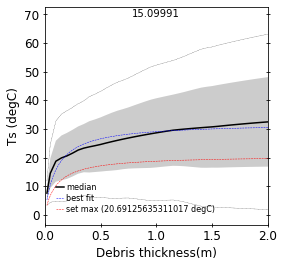

In [176]:
fit_melt = ts_fromdebris_func(debris_ts_df_stats.debris_thickness.values, func_coeff[0], func_coeff[1])
debris_4curve = np.arange(0.02,3.01,0.01)
ts_4curve = ts_fromdebris_func(debris_4curve, func_coeff[0], func_coeff[1])
ts_max = func_coeff[0]+ts_offset_obj.x[0]
ts_4curve_setmax = ts_fromdebris_func(debris_4curve, ts_max, func_coeff[1])
label_4tscurve = 'set max ('+ str(ts_max) + ' degC)'

print(func_coeff[0], func_coeff[1])


figure_fn = 'debris_Ts_curve.png'

# plot curve
fig, ax = plt.subplots(1, 1, squeeze=False, sharex=False, sharey=False, gridspec_kw = {'wspace':0.4, 'hspace':0.15})
#ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_mean'], '-', zorder=1, label='mean')
ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_med'], 
             '-', color='k', zorder=1, label='median')
ax[0,0].fill_between(debris_ts_df_stats['debris_thickness'], 
                     debris_ts_df_stats['ts_degC_med'] - debris_ts_df_stats['ts_degC_nmad'], 
                     debris_ts_df_stats['ts_degC_med'] + debris_ts_df_stats['ts_degC_nmad'],
                      facecolor='k', alpha=0.2, zorder=1)
ax[0,0].plot(debris_ts_df_stats['debris_thickness'], 
             debris_ts_df_stats['ts_degC_med'] - 1.96*debris_ts_df_stats['ts_degC_nmad'],
             linestyle='--', zorder=1, linewidth=0.25, color='k')
ax[0,0].plot(debris_ts_df_stats['debris_thickness'], 
             debris_ts_df_stats['ts_degC_med'] + 1.96*debris_ts_df_stats['ts_degC_nmad'],
             linestyle='--', zorder=1, linewidth=0.25, color='k')
ax[0,0].plot(debris_4curve, ts_4curve, 
             color='b', linewidth=0.5, linestyle='--', zorder=2, label='best fit')
ax[0,0].plot(debris_4curve, ts_4curve_setmax, 
             color='r', linewidth=0.5, linestyle='--', zorder=2, label=label_4tscurve)
# text
ax[0,0].text(0.5, 0.99, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
             transform=ax[0,0].transAxes)
#eqn_text = r'$T_{s} = \frac{T_{s,max} h}{k + h}$'
#coeff1_text = r'$T_{s,max} = ' + str(np.round(func_coeff[0],2)) + '$' 
#coeff2_text = r'$k = ' + str(np.round(func_coeff[1],2)) + '$' 
## coeff$\frac{b_{0}}{1 + 2kb_{0}h}$'
#ax[0,0].text(0.05, 0.9, eqn_text, size=12, horizontalalignment='left', verticalalignment='top', 
#             transform=ax[0,0].transAxes)
#ax[0,0].text(0.06, 0.79, 'where', size=10, horizontalalignment='left', verticalalignment='top', 
#             transform=ax[0,0].transAxes)
#ax[0,0].text(0.09, 0.74, coeff1_text, size=10, horizontalalignment='left', verticalalignment='top', 
#             transform=ax[0,0].transAxes)
#ax[0,0].text(0.09, 0.67, coeff2_text, size=10, horizontalalignment='left', verticalalignment='top', 
#             transform=ax[0,0].transAxes)
# X-label
ax[0,0].set_xlabel('Debris thickness(m)', size=12)
ax[0,0].set_xlim(0, 2)
#ax[0,0].set_xlim(0, debris_melt_df.debris_thickness.max())
ax[0,0].xaxis.set_tick_params(labelsize=12)
#ax[0,0].xaxis.set_major_locator(plt.MultipleLocator(0.5))
#ax[0,0].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  
# Y-label
ax[0,0].set_ylabel('Ts (degC)', size=12)
#ax[0,0].set_ylim(0,(int(debris_ts_df.melt_mwea.values.max()/0.1)+3)*0.1)
#ax[0,0].yaxis.set_major_locator(plt.MultipleLocator(10))
#ax[0,0].yaxis.set_minor_locator(plt.MultipleLocator(2))
# Tick parameters
ax[0,0].yaxis.set_ticks_position('both')
ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')     
# Legend
ax[0,0].legend(loc=(0.05, 0.05), 
               fontsize=8, labelspacing=0.25, handlelength=1, handletextpad=0.25, borderpad=0, 
               frameon=False)          
# Save plot
fig.set_size_inches(4, 4)
# fig.savefig(output_fp + figure_fn, bbox_inches='tight', dpi=300)  

In [28]:
print('\n\nDONE!\n\n')



DONE!




function coefficients: [53.96124898  0.72182063  0.40261078]


NameError: name 'gf' is not defined

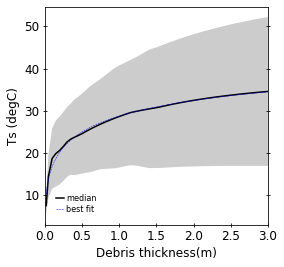

In [20]:
def ts_fromdebris_func(h, a, b, c):
    """ estimate surface temperature from debris thickness (h is debris thickness, a and k are coefficients) 
    Hill Equation"""
    return a * h**c / (b**c + h**c)
def debris_fromts_func(ts, a, b, c):
    """ estimate debris thickness from surface temperature (ts is surface temperature, a and k are coefficients) 
    Hill Equation"""
    return (ts * b**c / (a - ts))**(1/c)

def debris_fromts_maskedarray(ts_raw, a, b, c):
    """ Apply debris_fromts_func to masked array
        includes a mask of maximum values, since Michaelis-Mentin Equation has natural maximum 
    Parameters
    ----------
    ts_raw : np.ma.array
        masked array of the unmodified surface temperature
    Returns
    -------
    hd : np.ma.array 
        masked array of the debris thickness (m)
    """
    ts = ts_raw.copy()
    max_value = ts_fromdebris_func(50, a, b, c)
    print(max_value)
    debris_thick_ts = np.ma.array(maskedarray_gt(ts.data, max_value), mask=np.ma.getmask(ts))
    debris_thick_ts = np.ma.array(maskedarray_lt(ts.data, 0), mask=np.ma.getmask(ts))
    hd = debris_fromts_func(ts.data, tsmax, k)
    return hd

fit_idx = debris_ts_df_stats.index.values
# fit_idx = debris_ts_df_stats.index.values[0:40]
func_coeff, pcov = curve_fit(ts_fromdebris_func, 
                             debris_ts_df_stats.debris_thickness.values[fit_idx], debris_ts_df_stats.ts_degC_med.values[fit_idx],
                             p0=[25,1,1],
                             bounds=((0,0,0.01),(100,4,1))
                             )
fit_melt = ts_fromdebris_func(debris_ts_df_stats.debris_thickness.values, func_coeff[0], func_coeff[1], func_coeff[2])
debris_4curve = np.arange(0.02,3.01,0.01)
ts_4curve = ts_fromdebris_func(debris_4curve, func_coeff[0], func_coeff[1], func_coeff[2])

print('function coefficients:', func_coeff)


figure_fn = 'debris_Ts_curve-hill.png'

# plot curve
fig, ax = plt.subplots(1, 1, squeeze=False, sharex=False, sharey=False, gridspec_kw = {'wspace':0.4, 'hspace':0.15})
#ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_mean'], '-', zorder=1, label='mean')
ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_med'], 
             '-', color='k', zorder=1, label='median')
ax[0,0].fill_between(debris_ts_df_stats['debris_thickness'], 
                     debris_ts_df_stats['ts_degC_med'] - debris_ts_df_stats['ts_degC_nmad'], 
                     debris_ts_df_stats['ts_degC_med'] + debris_ts_df_stats['ts_degC_nmad'],
                      facecolor='k', alpha=0.2, zorder=1)
ax[0,0].plot(debris_4curve, ts_4curve, 
             color='b', linewidth=0.5, linestyle='--', zorder=2, label='best fit')
# text
# ax[0,0].text(0.5, 0.99, gf.glacnum, size=10, horizontalalignment='center', verticalalignment='top', 
#              transform=ax[0,0].transAxes)
# X-label
ax[0,0].set_xlabel('Debris thickness(m)', size=12)
ax[0,0].set_xlim(0, 3)
ax[0,0].xaxis.set_tick_params(labelsize=12)  
# Y-label
ax[0,0].set_ylabel('Ts (degC)', size=12)
# Tick parameters
ax[0,0].yaxis.set_ticks_position('both')
ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')     
# Legend
ax[0,0].legend(loc=(0.05, 0.05), 
               fontsize=8, labelspacing=0.25, handlelength=1, handletextpad=0.25, borderpad=0, 
               frameon=False)          
# Save plot
fig.set_size_inches(4, 4)

# Apply to glacier
tsmax_offset = -11.4
#     print(np.nanmax(gf.ts.data), ts_fromdebris_func(1000, func_coeff[0]+tsmax_offset, func_coeff[1]))

gf.debris_thick_ts = debris_fromts_maskedarray(gf.ts, func_coeff[0], func_coeff[1], func_coeff[2])
gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=np.ma.getmask(gf.ts))

titles = ['Uncalibrated Debris thickness (m)']
#     clim = malib.calcperc(gf.debris_thick_ts, (2,98))
clim = (0.02,2)
plot_array(gf.debris_thick_ts, clim, titles, 'inferno', 'Debris thickness (m)', fn=outdir_fig + gf.feat_fn +'_hd.png',
           close_fig=False)




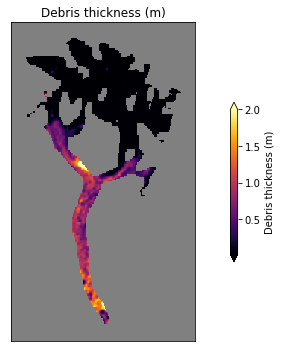

In [20]:
# ===== DEBRIS THICKNESS FROM RAW DATA =====
print('\n\nEQUATIONS MISS THIN OR THICK DEBRIS SO USE THE RAW DATA\n\n')
# Surface temperature dictionary
def ts_dict(debris_ts_df_stat, cn='ts_degC_mean', ts_offset=0):
    debris_ts_df_stats_adj = debris_ts_df_stats.copy()
    debris_ts_df_stats_adj[cn] = debris_ts_df_stats_adj[cn] + ts_offset
#     debris_ts_df_stats_adj['ts_degC_med'] = debris_ts_df_stats_adj['ts_degC_med'] + ts_offset
    ts_str_subset = np.array([str(np.round(x,2)) for x in debris_ts_df_stats_adj[cn].values])
    ts_dict = dict(zip(ts_str_subset, debris_ts_df_stats_adj['debris_thickness']))
    ts_step = 0.01
    ts = np.arange(np.round(debris_ts_df_stats_adj['ts_degC_mean'].min(),2), 
                  np.round(debris_ts_df_stats_adj['ts_degC_mean'].max(),2), ts_step)
    ts_str = np.array([str(np.round(x,2)) for x in ts])
    ds_ts_filled = pd.DataFrame(np.zeros((ts_str.shape[0], 3)), columns=['ts', 'ts_str', 'thickness'])
    ds_ts_filled['ts'] = ts
    ds_ts_filled['ts_str'] = ts_str
    ds_ts_filled['thickness'] = ds_ts_filled.ts_str.map(ts_dict)
    ds_ts_filled = ds_ts_filled.interpolate(method='linear', axis=0)
    ts_dict_filled = dict(zip(ds_ts_filled.ts_str, ds_ts_filled.thickness))
    ts_dict_filled['nan'] = 0
#     print(ts_dict_filled)
    return ds_ts_filled, ts_dict_filled



def ts_to_debristhickness_fromdata(ts, debris_ts_df_stats, cn='ts_degC_mean', ts_offset=0):
    # Create dictionary
    ds_ts_filled, ts_dict_filled = ts_dict(debris_ts_df_stats, cn=cn, ts_offset=ts_offset)
    # Use dictionary to map thickness values
    gf.debris_thick_ts = ts.copy()
    gf.debris_thick_ts = np.ma.array(maskedarray_gt(gf.debris_thick_ts.data, ds_ts_filled.ts.max()), 
                                     mask=np.ma.getmask(ts))
    gf.debris_thick_ts = np.ma.array(maskedarray_lt(gf.debris_thick_ts.data, ds_ts_filled.ts.min()), 
                                     mask=np.ma.getmask(ts))
    # Round to nearest 0.01 deg and convert to string for dictionary
    gf.debris_thick_ts = np.round(gf.debris_thick_ts,2)
    gf.debris_thick_ts = gf.debris_thick_ts.astype(str)
    # Convert to thickness
    for key in ts_dict_filled:
        gf.debris_thick_ts[gf.debris_thick_ts == key] = ts_dict_filled[key]
    gf.debris_thick_ts = gf.debris_thick_ts.astype(float)
    return gf.debris_thick_ts

# ds_ts_filled, ts_dict_filled = ts_dict(debris_ts_df_stats)

# process
# Estimate initial guess based on setting max to 2 m
# ts_clim = malib.calcperc(gf.ts, (2,98))
# debris_2m_idx = np.where(debris_ts_df_stats.debris_thickness == 2)[0][0]
# ts_offset_init = ts_clim[1] - debris_ts_df_stats.loc[debris_2m_idx,'ts_degC_mean']
# print(ts_clim[1], debris_ts_df_stats.loc[debris_2m_idx,'ts_degC_mean'], ts_offset_init)
# ts_offset_init = ts_clim[1] - debris_ts_df_stats.ts_degC_mean.max()
# print(ts_clim[1], debris_ts_df_stats.ts_degC_mean.max(), ts_offset_init)
# ts_offset_init = ts_clim[0] - debris_ts_df_stats.ts_degC_mean.min()
# print(ts_clim[0], debris_ts_df_stats.ts_degC_mean.max(), ts_offset_init)
ts_offset_init = -10

gf.debris_thick_ts = ts_to_debristhickness_fromdata(gf.ts, debris_ts_df_stats, cn='ts_degC_mean', 
                                                    ts_offset=ts_offset_init)
gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=np.ma.getmask(gf.ts))

titles = ['Debris thickness (m)']
# clim = malib.calcperc(gf.debris_thick_ts, (2,98))
clim = (0.02,2)
plot_array(gf.debris_thick_ts, clim, titles, 'inferno', 'Debris thickness (m)', fn='../debris_thickness.png',
           close_fig=False)

# # # Export binned file
# # outbins_df, z_bin_edges = hist_plot(gf, outdir_csv, bin_width=bin_width)

In [26]:
print('\n\nOLD SCRIPT BELOW', 
      '\n !! INCLUDES MELT REDUCTION FACTOR !!\n\n')



OLD SCRIPT BELOW 
 !! INCLUDES MELT REDUCTION FACTOR !!




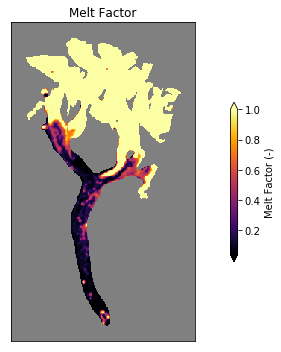

In [36]:
# ===== DEBRIS MELT ENHANCEMENT OR REDUCTION FACTOR =====
def meltfactor_fromdebris_func(h, a, k, melt_2cm):
    """ estimate melt factor from debris thickness (h is debris thickness, a and k are coefficients) """
    melt_h = a / (1 + 2 * k * a * h)
    melt_factor = melt_h / melt_2cm
    melt_factor[melt_factor > 1] = 1
    return melt_factor

idx_2cm = np.where(debris_melt_df.debris_thickness.values == 0.02)[0][0]
melt_2cm = debris_melt_df.loc[idx_2cm, 'melt_mwea']

outbins_df['meltfactor_ts'] = meltfactor_fromdebris_func(outbins_df['debris_thick_ts_med_m'].values, 
                                                         func_coeff_meltfromdebris[0], func_coeff_meltfromdebris[1], 
                                                         melt_2cm)

# Plot debris thickness
gf.meltfactor_ts = meltfactor_fromdebris_func(gf.debris_thick_ts, 
                                               func_coeff_meltfromdebris[0], func_coeff_meltfromdebris[1], 
                                               melt_2cm)
gf.meltfactor_ts = np.ma.array(gf.meltfactor_ts, mask=glac_geom_mask)

gf.res = geolib.get_res(ds_dict['z1'])

titles = ['Melt Factor']
clim = malib.calcperc(gf.meltfactor_ts, (2,98))
plot_array(gf.meltfactor_ts, clim, titles, 'inferno', 'Melt Factor (-)', fn='../meltfactor.png')

In [48]:
# Export melt factor map
meltfactor_fullfn = debris_fullfn.replace('_debristhickness_','_meltfactor_')
iolib.writeGTiff(gf.meltfactor_ts, meltfactor_fullfn, ds_dict['z1'])

In [37]:
# ====== PROCESS BINNED DEBRIS THICKNESS DATA FOR USE ======
outbins_df, z_bin_edges = hist_plot(gf, outdir, bin_width=10)

print('NOW EXPORT RESULTS TO FILE FORMAT WHERE ELEVATION IS CONSISTENT WITH FARINOTTI ICE THICKNESS!')

NOW EXPORT RESULTS TO FILE FORMAT WHERE ELEVATION IS CONSISTENT WITH FARINOTTI ICE THICKNESS!


In [38]:
debris_output_fp = '/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/output/'
debris_output_fn = 'debris_m_' + region.zfill(2) + '_10m.csv'
meltfactor_output_fn = 'meltfactor_' + region.zfill(2) + '_10m.csv'
hyps_fn = 'area_km2_' + region.zfill(2) + '_Farinotti2019_10m.csv'

# Load datasets or create a new dataset if it doesn't exist yet
area_df = pd.read_csv(debris_output_fp + hyps_fn)
if os.path.exists(debris_output_fp + debris_output_fn):
    debris_output = pd.read_csv(debris_output_fp + debris_output_fn)
    meltfactor_output = pd.read_csv(debris_output_fp + meltfactor_output_fn)
else:
    debris_output = pd.DataFrame(np.zeros(area_df.shape), columns=area_df.columns)
    debris_output['RGIId'] = area_df['RGIId']
    meltfactor_output = debris_output.copy()
    
rgi_idx = np.where(debris_output['RGIId'] == 'RGI60-' + glac_str)[0][0]
area_idx = np.where(area_df.iloc[rgi_idx,1:] > 0)[0]
area_cns = area_df.columns[1:][area_idx]

print(area_df.loc[rgi_idx, area_cns])

# All area that have ice set to clean ice to begin
debris_output.loc[rgi_idx, area_cns] = 0
meltfactor_output.loc[rgi_idx, area_cns] = 1
# add debris thickness and meltfactors
debris_cns = [str(int(np.round(x,0))) for x in outbins_df['bin_center_elev_m'].values]
debris_output.loc[rgi_idx, debris_cns] = outbins_df['debris_thick_ts_med_m'].values
meltfactor_output.loc[rgi_idx, debris_cns] = outbins_df['meltfactor_ts_med_m'].values

# Export files
debris_output.to_csv(debris_output_fp + debris_output_fn, index=False)
meltfactor_output.to_csv(debris_output_fp + meltfactor_output_fn, index=False)

print('\n\nAVOID LOADING AND EXPORTING EVERY GLACIER WHEN SCALING THIS UP - only do once at start and end\n\n')

print('\nClean ice has 0.02 m of debris (meltfactor = 1) - remove this so only debris covered areas have values\n')

4705    0.2175
4715    0.3225
4725    0.4675
4735    0.5825
4745      0.37
         ...  
8145    0.0375
8155    0.0275
8165    0.0275
8175    0.0325
8185     0.005
Name: 3472, Length: 349, dtype: object


AVOID LOADING AND EXPORTING EVERY GLACIER WHEN SCALING THIS UP - only do once at start and end



Clean ice has 0.02 m of debris (meltfactor = 1) - remove this so only debris covered areas have values



In [39]:
region

'15'

In [ ]:
print('\n\n\nOLD CODE NO LONGER RELEVANT\n\n')
# # ===== ESTIMATE DEBRIS THICKNESS =====
# #Now apply glacier mask AND mask NaN values
# # # glac_geom_mask = np.ma.mask_or(glac_geom_mask, dems_mask)
# # # gf.debris_thick_ts = np.ma.array(iolib.ds_getma(ds_dict['ts']), mask=glac_geom_mask)
# # k = 0.13
# # Tsmax_offset = 6
# # Tsmax = gf.ts.max() + Tsmax_offset
# # gf.debris_thick_ts = gf.ts * 0.13 / (Tsmax - gf.ts)

# Tsmax_offset = 0
# Tsmax = gf.ts.max() + Tsmax_offset
# gf.debris_thick_ts = debris_fromts_func_hill(gf.ts, hill_func_coeff[0], hill_func_coeff[1], hill_func_coeff[2])

# # gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=glac_geom_mask)
# # gf.debris_thick_ts  = np.ma.masked_less_equal(gf.debris_thick_ts, 0)
# # gf.debris_thick_ts[gf.debris_thic_tsk>1] = 1

# gf.res = geolib.get_res(ds_dict['z1'])

# titles = ['Debris thickness (m)']
# clim = malib.calcperc(gf.debris_thick_ts, (2,98))
# plot_array(gf.debris_thick_ts, clim, titles, 'inferno', 'Debris thickness (m)', fn='../debris_thickness.png')

# outbins_df['debris*area'] = outbins_df['debris_thick_med_m'] * outbins_df['z1_bin_area_valid_km2']
# outbins_df['debris*area_mad'] = outbins_df['debris_thick_mad_m'] * outbins_df['z1_bin_area_valid_km2']
# mb_df['debris_thickness_fromTs'] = np.nan
# mb_df['debris_thickness_fromTs_mad'] = np.nan
# for x in mb_df.index.values:
#     if ~np.isnan(mb_df.loc[x,'em_idx_low']):
#         mb_df.loc[x,'debris_thickness_fromTs'] = (
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area'].sum() / 
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
#         mb_df.loc[x,'debris_thickness_fromTs_mad'] = (
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area_mad'].sum() / 
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())

# print(mb_df.loc[debris_idx,['# bin_center_elev_m', ' vm_med', ' H_mean',
#        'debris_thickness', 'debris_thickness_1stdlow', 'debris_thickness_1stdhigh', 'debris_thickness_fromTs', 'debris_thickness_fromTs_mad']])

# ===== OPTIMIZE TS_MAX BASED ON THE SUBDEBRIS MELT INVERSION METHOD ======
# from scipy.optimize import minimize

# def objective(Ts_max):
#     """
#     Objective function to fit Ts_max for the surface temperature inversions to the subdebris melt inversions

#     Parameters
#     ----------
#     Ts_max : np.float64
#         Maximum surface temperature for Hill equation

#     Returns
#     -------
#     debris_dif
#         Returns the difference in debris thickness for the subdebris and surface temp inversions
#     """
    
#     # Debris thickness from Hill Equation
#     gf.debris_thick_ts = debris_fromts_func_hill(gf.ts, Ts_max, hill_func_coeff[1], hill_func_coeff[2])
    
#     # Bin debris thicknesses
#     outbins_df, z_bin_edges = hist_plot_wdebris(gf, outdir_csv, bin_width=bin_width)
    
#     outbins_df['debris*area'] = outbins_df['debris_thick_med_m'] * outbins_df['z1_bin_area_valid_km2']
#     outbins_df['debris*area_mad'] = outbins_df['debris_thick_mad_m'] * outbins_df['z1_bin_area_valid_km2']
#     mb_df['debris_thickness_fromTs'] = np.nan
#     mb_df['debris_thickness_fromTs_mad'] = np.nan
#     for x in mb_df.index.values:
#         if ~np.isnan(mb_df.loc[x,'em_idx_low']):
#             mb_df.loc[x,'debris_thickness_fromTs'] = (
#                     outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area'].sum() / 
#                     outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
#             mb_df.loc[x,'debris_thickness_fromTs_mad'] = (
#                     outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area_mad'].sum() / 
#                     outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
    
#     # Compare only over bins with low velocity and lots of debris
#     vel_lt10_idx_raw = np.where((mb_df[' vm_med'] < 7.5) & (mb_df[' perc_debris'] > 50))[0]
#     # only work with terminus
#     vel_idx_dif = list(vel_lt10_idx_raw[1:] - vel_lt10_idx_raw[:-1])
#     idx_jumpinbins = vel_idx_dif.index(next(filter(lambda x: x>1, vel_idx_dif)))
#     vel_lt10_idx = vel_lt10_idx_raw[0:idx_jumpinbins+1]

#     debris_dif_sum = (mb_df.loc[vel_lt10_idx, 'debris_thickness_fromTs'] - mb_df.loc[vel_lt10_idx,'debris_thickness']).sum()
    
#     debris_dif_sum_abs = abs(debris_dif_sum)

#     return debris_dif_sum_abs


# ts_max_obj = minimize(objective, hill_func_coeff[0], method='SLSQP',
#                       options={'ftol':1e-3, 'eps':0.1}
#                      )
# ts_max_opt = ts_max_obj.x[0]

# print(ts_max_opt)

# ===== OUTPUT FINAL DEBRIS THICKNESS =====
# gf.debris_thick_ts = debris_fromts_func_hill(gf.ts, ts_max_opt, hill_func_coeff[1], hill_func_coeff[2])

# # gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=glac_geom_mask)
# # gf.debris_thick_ts  = np.ma.masked_less_equal(gf.debris_thick_ts, 0)
# # gf.debris_thick_ts[gf.debris_thick_ts>1] = 1

# gf.res = geolib.get_res(ds_dict['z1'])

# titles = ['Debris thickness (m)']
# clim = malib.calcperc(gf.debris_thick_ts, (2,98))
# plot_array(gf.debris_thick_ts, clim, titles, 'inferno', 'Debris thickness (m)', fn='../debris_thickness.png')

# # Plot optimized curve
# debris_4curve = np.arange(0.02,5.01,0.01)
# ts_4curve = ts_fromdebris_func(debris_4curve, func_coeff[0], func_coeff[1], func_coeff[2])

# figure_fn = 'debris_Ts_curve_Hill_optimized.png'

# # plot curve
# fig, ax = plt.subplots(1, 2, squeeze=False, sharex=False, sharey=False, gridspec_kw = {'wspace':0.4, 'hspace':0.15})
# #ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_mean'], '-', zorder=1, label='mean')
# ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_med'], 
#              '-', color='k', zorder=1, label='median')
# ax[0,0].fill_between(debris_ts_df_stats['debris_thickness'], 
#                      debris_ts_df_stats['ts_degC_med'] - debris_ts_df_stats['ts_degC_nmad'], 
#                      debris_ts_df_stats['ts_degC_med'] + debris_ts_df_stats['ts_degC_nmad'],
#                      facecolor='k', alpha=0.2, zorder=1)
# ax[0,0].plot(debris_4curve, ts_4curve, 
#              color='b', linewidth=0.5, linestyle='--', zorder=2, label='optimized')
# # text
# ax[0,0].text(0.5, 0.99, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
#              transform=ax[0,0].transAxes)
# # X-label
# ax[0,0].set_xlabel('Debris thickness(m)', size=12)
# ax[0,0].set_xlim(0, 2)
# ax[0,0].xaxis.set_tick_params(labelsize=12)
# # Y-label
# ax[0,0].set_ylabel('Ts (degC)', size=12)
# # Tick parameters
# ax[0,0].yaxis.set_ticks_position('both')
# ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
# ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')     
# # Legend
# ax[0,0].legend(loc=(0.05, 0.05), 
#                fontsize=8, labelspacing=0.25, handlelength=1, handletextpad=0.25, borderpad=0, 
#                frameon=False)    

# ax[0,1].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_med'], 
#              '-', color='k', zorder=1, label='median')
# ax[0,1].fill_between(debris_ts_df_stats['debris_thickness'], 
#                      debris_ts_df_stats['ts_degC_med'] - debris_ts_df_stats['ts_degC_nmad'], 
#                      debris_ts_df_stats['ts_degC_med'] + debris_ts_df_stats['ts_degC_nmad'],
#                      facecolor='k', alpha=0.2, zorder=1)
# ax[0,1].plot(debris_4curve, ts_4curve, 
#              color='b', linewidth=0.5, linestyle='--', zorder=2, label='optimized')
# # text
# ax[0,1].text(0.5, 0.99, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
#              transform=ax[0,0].transAxes)
# # X-label
# ax[0,1].set_xlabel('Debris thickness(m)', size=12)
# ax[0,1].set_xlim(0, 0.25)
# ax[0,1].xaxis.set_tick_params(labelsize=12)
# # Y-label
# ax[0,1].set_ylabel('Ts (degC)', size=12)
# # Tick parameters
# ax[0,1].yaxis.set_ticks_position('both')
# ax[0,1].tick_params(axis='both', which='major', labelsize=12, direction='inout')
# ax[0,1].tick_params(axis='both', which='minor', labelsize=10, direction='in')     
# # Legend
# ax[0,1].legend(loc=(0.05, 0.05), 
#                fontsize=8, labelspacing=0.25, handlelength=1, handletextpad=0.25, borderpad=0, 
#                frameon=False)    

# # Save plot
# fig.set_size_inches(6, 4)
# fig.savefig(output_fp + figure_fn, bbox_inches='tight', dpi=300) 

# # Export binned file
# outbins_df, z_bin_edges = hist_plot_wdebris(gf, outdir_csv, bin_width=bin_width)
# outbins_df['debris*area'] = outbins_df['debris_thick_med_m'] * outbins_df['z1_bin_area_valid_km2']
# outbins_df['debris*area_mad'] = outbins_df['debris_thick_mad_m'] * outbins_df['z1_bin_area_valid_km2']
# mb_df['debris_thickness_fromTs'] = np.nan
# mb_df['debris_thickness_fromTs_mad'] = np.nan
# for x in mb_df.index.values:
#     if ~np.isnan(mb_df.loc[x,'em_idx_low']):
#         mb_df.loc[x,'debris_thickness_fromTs'] = (
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area'].sum() / 
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
#         mb_df.loc[x,'debris_thickness_fromTs_mad'] = (
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area_mad'].sum() / 
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
# mb_df.to_csv(outdir_csv + '/' + glac_str + '_mb_bins_wdebris_inversions_Hill.csv', index=False)

In [ ]:
# ===== MICHAELIS-MENTEN EQUATION IN WORKING CONDITION! ============================================================
#     # ===== UNCALIBRATED: PLOT AND FIT CURVE (NONLINEAR REGRESSION) =====
#     print('UNCALIBRATED: Michaelis-Menten Equation shown below')
#     #def ts_fromdebris_func(h, a, k):
#     #    """ estimate surface temperature from debris thickness (h is debris thickness, a and k are coefficients) 
#     #    Michaelis-Menten Equation from single-substrate reactions"""
#     #    return a - a*np.exp(-k*h)
#     def ts_fromdebris_func(h, a, k):
#         """ estimate surface temperature from debris thickness (h is debris thickness, a and k are coefficients) 
#         hyperbolic fit"""
#         return a * h / (k + h)
#     def debris_fromts_func(ts, a, k):
#         """ estimate debris thickness from Ts (b is melt, a and k are coefficients) """
#         return k * ts / (a - ts)

#     def debris_fromts_maskedarray(ts_raw, tsmax, k):
#         """ Apply debris_fromts_func to masked array
#             includes a mask of maximum values, since Michaelis-Mentin Equation has natural maximum 
#         Parameters
#         ----------
#         ts_raw : np.ma.array
#             masked array of the unmodified surface temperature
#         Returns
#         -------
#         hd : np.ma.array 
#             masked array of the debris thickness (m)
#         """
#         ts = ts_raw.copy()
#         max_value = ts_fromdebris_func(1000, tsmax, k)
#         debris_thick_ts = np.ma.array(maskedarray_gt(ts.data, max_value), mask=np.ma.getmask(ts))
#         debris_thick_ts = np.ma.array(maskedarray_lt(ts.data, 0), mask=np.ma.getmask(ts))
#         hd = debris_fromts_func(ts.data, tsmax, k)
#         return hd
    
#     print(debris_ts_df_stats.loc[0:10,:])

#     # fit_idx = debris_ts_df_stats.index.values
#     fit_idx = debris_ts_df_stats.index.values[0:40]
#     # print('\nFIT ONLY TO DEBRIS THICKNESSES:', debris_ts_df_stats.debris_thickness.values[fit_idx], 
#     #       '\nTO ENSURE CAPTURES CURVE \n(plot with equal spacing to avoid this issue, but computationally expensive)')
#     func_coeff, pcov = curve_fit(ts_fromdebris_func, 
#                                  debris_ts_df_stats.debris_thickness.values[fit_idx], debris_ts_df_stats.ts_degC_med.values[fit_idx],
#     #                             p0=[30,0.3]
#                                  bounds=[(-np.inf, 0), (np.inf, np.inf)]
#                                  )
#     fit_melt = ts_fromdebris_func(debris_ts_df_stats.debris_thickness.values, func_coeff[0], func_coeff[1])
#     debris_4curve = np.arange(0.02,3.01,0.01)
#     ts_4curve = ts_fromdebris_func(debris_4curve, func_coeff[0], func_coeff[1])
#     ts_offset = -11.4
#     ts_4curve_setmax = ts_fromdebris_func(debris_4curve, func_coeff[0] + ts_offset, func_coeff[1])
#     label_4tscurve = 'set max ('+ str(ts_max) + ' degC)'

#     print(func_coeff[0], func_coeff[1])


#     figure_fn = 'debris_Ts_curve.png'

#     # plot curve
#     fig, ax = plt.subplots(1, 1, squeeze=False, sharex=False, sharey=False, gridspec_kw = {'wspace':0.4, 'hspace':0.15})
#     #ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_mean'], '-', zorder=1, label='mean')
#     ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_med'], 
#                  '-', color='k', zorder=1, label='median')
#     ax[0,0].fill_between(debris_ts_df_stats['debris_thickness'], 
#                          debris_ts_df_stats['ts_degC_med'] - debris_ts_df_stats['ts_degC_nmad'], 
#                          debris_ts_df_stats['ts_degC_med'] + debris_ts_df_stats['ts_degC_nmad'],
#                           facecolor='k', alpha=0.2, zorder=1)
#     ax[0,0].plot(debris_4curve, ts_4curve, 
#                  color='b', linewidth=0.5, linestyle='--', zorder=2, label='best fit')
#     ax[0,0].plot(debris_4curve, ts_4curve_setmax, 
#                  color='r', linewidth=0.5, linestyle='--', zorder=2, label=label_4tscurve)
#     # text
#     ax[0,0].text(0.5, 0.99, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
#                  transform=ax[0,0].transAxes)
#     #eqn_text = r'$T_{s} = \frac{T_{s,max} h}{k + h}$'
#     #coeff1_text = r'$T_{s,max} = ' + str(np.round(func_coeff[0],2)) + '$' 
#     #coeff2_text = r'$k = ' + str(np.round(func_coeff[1],2)) + '$' 
#     ## coeff$\frac{b_{0}}{1 + 2kb_{0}h}$'
#     #ax[0,0].text(0.05, 0.9, eqn_text, size=12, horizontalalignment='left', verticalalignment='top', 
#     #             transform=ax[0,0].transAxes)
#     #ax[0,0].text(0.06, 0.79, 'where', size=10, horizontalalignment='left', verticalalignment='top', 
#     #             transform=ax[0,0].transAxes)
#     #ax[0,0].text(0.09, 0.74, coeff1_text, size=10, horizontalalignment='left', verticalalignment='top', 
#     #             transform=ax[0,0].transAxes)
#     #ax[0,0].text(0.09, 0.67, coeff2_text, size=10, horizontalalignment='left', verticalalignment='top', 
#     #             transform=ax[0,0].transAxes)
#     # X-label
#     ax[0,0].set_xlabel('Debris thickness(m)', size=12)
#     ax[0,0].set_xlim(0, 3)
#     #ax[0,0].set_xlim(0, debris_melt_df.debris_thickness.max())
#     ax[0,0].xaxis.set_tick_params(labelsize=12)
#     #ax[0,0].xaxis.set_major_locator(plt.MultipleLocator(0.5))
#     #ax[0,0].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  
#     # Y-label
#     ax[0,0].set_ylabel('Ts (degC)', size=12)
#     #ax[0,0].set_ylim(0,(int(debris_ts_df.melt_mwea.values.max()/0.1)+3)*0.1)
#     #ax[0,0].yaxis.set_major_locator(plt.MultipleLocator(10))
#     #ax[0,0].yaxis.set_minor_locator(plt.MultipleLocator(2))
#     # Tick parameters
#     ax[0,0].yaxis.set_ticks_position('both')
#     ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
#     ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')     
#     # Legend
#     ax[0,0].legend(loc=(0.05, 0.05), 
#                    fontsize=8, labelspacing=0.25, handlelength=1, handletextpad=0.25, borderpad=0, 
#                    frameon=False)          
#     # Save plot
#     fig.set_size_inches(4, 4)
#     # fig.savefig(output_fp + figure_fn, bbox_inches='tight', dpi=300)  
    
#     # Apply to glacier
#     tsmax_offset = -11.4
# #     print(np.nanmax(gf.ts.data), ts_fromdebris_func(1000, func_coeff[0]+tsmax_offset, func_coeff[1]))

#     gf.debris_thick_ts = debris_fromts_maskedarray(gf.ts, func_coeff[0]+tsmax_offset, func_coeff[1])
#     gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=np.ma.getmask(gf.ts))

#     titles = ['Uncalibrated Debris thickness (m)']
# #     clim = malib.calcperc(gf.debris_thick_ts, (2,98))
#     clim = (0.02,2)
#     plot_array(gf.debris_thick_ts, clim, titles, 'inferno', 'Debris thickness (m)', fn=outdir_fig + gf.feat_fn +'_hd.png',
#                close_fig=False)
    
# # ===== OPTIMIZE BASED ON THE SUB-DEBRIS MELT DEBRIS THICKNESS ESTIMATES =====
# from scipy.optimize import minimize
# def objective(ts_offset):
#     """
#     Objective function to fit Ts_offset for the surface temperature inversions to the subdebris melt inversions

#     Parameters
#     ----------
#     Ts_offset : np.float64
#         Temperature offset used to shift data/curve up or down

#     Returns
#     -------
#     debris_dif
#         Returns the difference in debris thickness for the subdebris and surface temp inversions
#     """
#     # Column name to run objective on
#     hd_cn = 'hd_wem'
    
#     df_wdebris_all = None
#     for ngf, gf in enumerate(gf_list):
# #     for ngf, gf in enumerate([gf_list[7]]):
# #         print(ngf, gf.glacnum)
#         # Debris thickness from Michaelis-Mentin Equation
#         gf.debris_thick_ts = debris_fromts_maskedarray(gf.ts, func_coeff[0]+ts_offset, func_coeff[1])
#         gf.debris_thick_ts = np.ma.array(maskedarray_gt(gf.debris_thick_ts,input.hd_max), mask=np.ma.getmask(gf.ts))
# #         gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=np.ma.getmask(gf.ts))

#         # COMPARE DEBRIS THICKNESSES
#         # Bin debris thicknesses
#         outbins_df, z_bin_edges = hist_plot(gf, bin_width=mb_bin_size)
        
#         # Load data
#         glac_idx = main_glac_rgi_subset.index.values[ngf]
#         df_wdebris = pd.read_csv(input.mb_binned_fp_wdebris + main_glac_rgi_subset.loc[glac_idx,'bin_fn'])
#         df_wdebris['glac_str'] = gf.glacnum
#         # Reduce sub-debris melt inversion debris to max debris if needed
#         df_wdebris.loc[df_wdebris[hd_cn] > input.hd_max, hd_cn] = input.hd_max

#         # ===== Add debris thickness from surface temperature inversion to mb_wdebris dataset =====
#         df_wdebris['hd_ts'] = -9999
#         # start index for merge
#         if df_wdebris.loc[0,'# bin_center_elev_m'] >= outbins_df.loc[0,'bin_center_elev_m']:
#             df_idx1 = 0
#             outbins_idx1 = np.where(outbins_df['bin_center_elev_m'] == df_wdebris.loc[0,'# bin_center_elev_m'])[0][0]
#         else:
#             outbins_idx1 = 0
#             df_idx1 = np.where(outbins_df.loc[0,'bin_center_elev_m'] == df_wdebris['# bin_center_elev_m'])[0][0]
#         # print('idx1:', 
#         #       '\noutbins:', outbins_idx1, outbins_df.loc[outbins_idx1,'bin_center_elev_m'],
#         #       '\ndfbins:', df_idx1, df_wdebris.loc[df_idx1,'# bin_center_elev_m'])
#         # end index for merge
#         if outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] >= df_wdebris.loc[df_wdebris.shape[0]-1,'# bin_center_elev_m']:
#             outbins_idx2 = np.where(outbins_df['bin_center_elev_m'] == df_wdebris.loc[df_wdebris.shape[0]-1,'# bin_center_elev_m'])[0][0]
#             df_idx2 = df_wdebris.shape[0]-1
#         else:
#             outbins_idx2 = outbins_df.shape[0]-1
#             df_idx2 = np.where(outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] == df_wdebris['# bin_center_elev_m'])[0][0]
#         # print('idx2:', 
#         #       '\noutbins:', outbins_idx2, outbins_df.loc[outbins_idx2,'bin_center_elev_m'],
#         #       '\ndfbins:', df_idx2, df_wdebris.loc[df_idx2,'# bin_center_elev_m'])

#         df_wdebris.loc[df_idx1:df_idx2+1,'hd_ts'] = outbins_df.loc[outbins_idx1:outbins_idx2+1,'debris_thick_ts_med_m']

#         # ===== Get desired indices for comparison =====
#         # Compare only low velocity, debris-covered bins
#         vel_lt10_idx_raw = np.where((df_wdebris[' vm_med'] < input.vel_threshold) 
#                                     & (df_wdebris[' perc_debris'] > input.debrisperc_threshold)
#                                     & (df_wdebris['hd_ts'] > -9999)
#                                    )[0]
        
# #         print('vel_lt10_idx_raw:', vel_lt10_idx_raw)
        
#         if len(vel_lt10_idx_raw) > 0:
#             # only work with terminus
#             vel_idx_dif = list(vel_lt10_idx_raw[1:] - vel_lt10_idx_raw[:-1])
#             if np.sum(vel_idx_dif) == len(vel_lt10_idx_raw)-1:
#                 vel_lt10_idx = vel_lt10_idx_raw
#             else:
#                 idx_jumpinbins = vel_idx_dif.index(next(filter(lambda x: x>1, vel_idx_dif)))
#                 vel_lt10_idx = vel_lt10_idx_raw[0:idx_jumpinbins+1]
            
#             df_wdebris_subset = df_wdebris.loc[vel_lt10_idx,:]
#             df_wdebris_subset.reset_index(inplace=True, drop=True)
            
# #             print(df_wdebris_subset[['# bin_center_elev_m', ' vm_med', ' perc_debris', 'hd', 'hd_wem']])

#             # Remove any bins with negative debris thickness or maximum debris thickness
#             vel_lt10_idx_posdebris = np.where((df_wdebris_subset[hd_cn] > 0)
#                                               & (df_wdebris_subset[hd_cn] < input.hd_max)
#                                              )[0]
            
# #             print('vel_lt10_posdebris:', vel_lt10_idx_posdebris)
# #             print(df_wdebris_subset.loc[vel_lt10_idx_posdebris,['# bin_center_elev_m', ' vm_med', ' perc_debris', 'hd', 'hd_wem']])

# #             Remove any bins with maximum debris thickness
# #             vel_lt10_idx_posdebris = np.where(df_wdebris_subset.loc[vel_lt10_idx_posdebris,hd_cn] < input.hd_max)[0]
            
#             if df_wdebris_all is None:
#                 df_wdebris_all = df_wdebris.loc[vel_lt10_idx_posdebris,:]
#             else:
#                 df_wdebris_all = pd.concat([df_wdebris_all, df_wdebris.loc[vel_lt10_idx_posdebris,:]], axis=0)

#     df_wdebris_all.reset_index(inplace=True, drop=True)
    
#     # Non-weighted difference
#     debris_dif_sum = (df_wdebris_all['hd_ts'] - df_wdebris_all[hd_cn]).sum()
    
#     # Weighted difference
#     debris_dif_sum = ((df_wdebris_all['hd_ts'] - df_wdebris_all[hd_cn]) * 
#                       df_wdebris_all[' z1_bin_area_valid_km2'] * df_wdebris_all[' perc_debris'] / 100).sum()

#     debris_dif_sum_abs = abs(debris_dif_sum)

#     print(ts_offset, debris_dif_sum_abs)

#     return debris_dif_sum_abs


# def run_objective(ts_offset):
    
#     # Column name to run objective on
#     hd_cn = 'hd_wem'
    
#     df_wdebris_all = None
#     for ngf, gf in enumerate(gf_list):
# #     for ngf, gf in enumerate([gf_list[7]]):
# #         print(ngf, gf.glacnum)
#         # Debris thickness from Michaelis-Mentin Equation
#         gf.debris_thick_ts = debris_fromts_maskedarray(gf.ts, func_coeff[0]+ts_offset, func_coeff[1])
#         gf.debris_thick_ts = np.ma.array(maskedarray_gt(gf.debris_thick_ts,input.hd_max), mask=np.ma.getmask(gf.ts))
# #         gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=np.ma.getmask(gf.ts))

#         # COMPARE DEBRIS THICKNESSES
#         # Bin debris thicknesses
#         outbins_df, z_bin_edges = hist_plot(gf, bin_width=mb_bin_size)
        
#         # Load data
#         glac_idx = main_glac_rgi_subset.index.values[ngf]
#         df_wdebris = pd.read_csv(input.mb_binned_fp_wdebris + main_glac_rgi_subset.loc[glac_idx,'bin_fn'])
#         df_wdebris['glac_str'] = gf.glacnum
#         # Reduce sub-debris melt inversion debris to max debris if needed
#         df_wdebris.loc[df_wdebris[hd_cn] > input.hd_max, hd_cn] = input.hd_max

#         # ===== Add debris thickness from surface temperature inversion to mb_wdebris dataset =====
#         df_wdebris['hd_ts'] = -9999
#         # start index for merge
#         if df_wdebris.loc[0,'# bin_center_elev_m'] >= outbins_df.loc[0,'bin_center_elev_m']:
#             df_idx1 = 0
#             outbins_idx1 = np.where(outbins_df['bin_center_elev_m'] == df_wdebris.loc[0,'# bin_center_elev_m'])[0][0]
#         else:
#             outbins_idx1 = 0
#             df_idx1 = np.where(outbins_df.loc[0,'bin_center_elev_m'] == df_wdebris['# bin_center_elev_m'])[0][0]
#         # print('idx1:', 
#         #       '\noutbins:', outbins_idx1, outbins_df.loc[outbins_idx1,'bin_center_elev_m'],
#         #       '\ndfbins:', df_idx1, df_wdebris.loc[df_idx1,'# bin_center_elev_m'])
#         # end index for merge
#         if outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] >= df_wdebris.loc[df_wdebris.shape[0]-1,'# bin_center_elev_m']:
#             outbins_idx2 = np.where(outbins_df['bin_center_elev_m'] == df_wdebris.loc[df_wdebris.shape[0]-1,'# bin_center_elev_m'])[0][0]
#             df_idx2 = df_wdebris.shape[0]-1
#         else:
#             outbins_idx2 = outbins_df.shape[0]-1
#             df_idx2 = np.where(outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] == df_wdebris['# bin_center_elev_m'])[0][0]
#         # print('idx2:', 
#         #       '\noutbins:', outbins_idx2, outbins_df.loc[outbins_idx2,'bin_center_elev_m'],
#         #       '\ndfbins:', df_idx2, df_wdebris.loc[df_idx2,'# bin_center_elev_m'])

#         df_wdebris.loc[df_idx1:df_idx2+1,'hd_ts'] = outbins_df.loc[outbins_idx1:outbins_idx2+1,'debris_thick_ts_med_m']

#         # ===== Get desired indices for comparison =====
#         # Compare only low velocity, debris-covered bins
#         vel_lt10_idx_raw = np.where((df_wdebris[' vm_med'] < input.vel_threshold) 
#                                     & (df_wdebris[' perc_debris'] > input.debrisperc_threshold)
#                                     & (df_wdebris['hd_ts'] > -9999)
#                                    )[0]
        
# #         print('vel_lt10_idx_raw:', vel_lt10_idx_raw)
        
#         if len(vel_lt10_idx_raw) > 0:
#             # only work with terminus
#             vel_idx_dif = list(vel_lt10_idx_raw[1:] - vel_lt10_idx_raw[:-1])
#             if np.sum(vel_idx_dif) == len(vel_lt10_idx_raw)-1:
#                 vel_lt10_idx = vel_lt10_idx_raw
#             else:
#                 idx_jumpinbins = vel_idx_dif.index(next(filter(lambda x: x>1, vel_idx_dif)))
#                 vel_lt10_idx = vel_lt10_idx_raw[0:idx_jumpinbins+1]
            
#             df_wdebris_subset = df_wdebris.loc[vel_lt10_idx,:]
#             df_wdebris_subset.reset_index(inplace=True, drop=True)
            
# #             print(df_wdebris_subset[['# bin_center_elev_m', ' vm_med', ' perc_debris', 'hd', 'hd_wem']])

#             # Remove any bins with negative debris thickness or maximum debris thickness
#             vel_lt10_idx_posdebris = np.where((df_wdebris_subset[hd_cn] > 0)
#                                               & (df_wdebris_subset[hd_cn] < input.hd_max)
#                                              )[0]
            
# #             print('vel_lt10_posdebris:', vel_lt10_idx_posdebris)
# #             print(df_wdebris_subset.loc[vel_lt10_idx_posdebris,['# bin_center_elev_m', ' vm_med', ' perc_debris', 'hd', 'hd_wem']])

# #             Remove any bins with maximum debris thickness
# #             vel_lt10_idx_posdebris = np.where(df_wdebris_subset.loc[vel_lt10_idx_posdebris,hd_cn] < input.hd_max)[0]
            
#             if df_wdebris_all is None:
#                 df_wdebris_all = df_wdebris.loc[vel_lt10_idx_posdebris,:]
#             else:
#                 df_wdebris_all = pd.concat([df_wdebris_all, df_wdebris.loc[vel_lt10_idx_posdebris,:]], axis=0)

#     df_wdebris_all.reset_index(inplace=True, drop=True)
    
#     # Non-weighted difference
#     debris_dif_sum = (df_wdebris_all['hd_ts'] - df_wdebris_all[hd_cn]).sum()
    
#     # Weighted difference
#     debris_dif_sum = ((df_wdebris_all['hd_ts'] - df_wdebris_all[hd_cn]) * 
#                       df_wdebris_all[' z1_bin_area_valid_km2'] * df_wdebris_all[' perc_debris'] / 100).sum()

#     debris_dif_sum_abs = abs(debris_dif_sum)

#     print(ts_offset, debris_dif_sum_abs)

# #     return df_wdebris_all, vel_lt10_idx  
#     return df_wdebris_all

# mb_df = run_objective(0)

In [1]:
# #! /usr/bin/env python
# """
# Compute debris thickness through sub-debris and temperature inversion methods
# """
# import sys
# import os
# import re
# import subprocess
# from datetime import datetime, timedelta
# import time
# import pickle
# from collections import OrderedDict

# import geopandas as gpd
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# import rasterio
# from scipy import ndimage
# from scipy.optimize import curve_fit
# from scipy.optimize import minimize
# import xarray as xr
# from osgeo import gdal, ogr, osr

# from pygeotools.lib import malib, warplib, geolib, iolib, timelib
# # from imview.lib import pltlib

# import globaldebris_input as input

# print('\nOVERRIDING INPUT ROI\n\n')
# input.roi = '01'

# verbose=False
# debug=False
# extra_layers=True
# min_glac_area_writeout = input.min_glac_area_writeout
# min_valid_area_perc = input.min_valid_area_perc
# buff_dist = input.buff_dist
# # bin_width = input.emvel_bin_width
# #Surface to column average velocity scaling
# v_col_f = input.v_col_f
# csv_ending = input.output_ts_csv_ending
# emvel_filter_pixsize = input.emvel_filter_pixsize

# #INPUT
# glac_shp_fn_dict = {'13':input.main_directory + '/../../../HiMAT/RGI/rgi60/13_rgi60_CentralAsia/13_rgi60_CentralAsia.shp',
#                     '14':input.main_directory + '/../../../HiMAT/RGI/rgi60/14_rgi60_SouthAsiaWest/14_rgi60_SouthAsiaWest.shp',
#                     '15':input.main_directory + '/../../../HiMAT/RGI/rgi60/15_rgi60_SouthAsiaEast/15_rgi60_SouthAsiaEast.shp'}
# glac_shp_proj_fp = input.output_fp + 'glac_shp_proj/'
# if os.path.exists(glac_shp_proj_fp) == False:
#     os.makedirs(glac_shp_proj_fp)


# #DEM
# z1_dir_sample = ('/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/surface_DEMs_RGI60/' + 
#           'surface_DEMs_RGI60-XXXX/')
# z1_fn_sample = 'surface_DEM_RGI60-XXXX.tif'
# # Ice thickness
# huss_dir_sample = ('/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/' + 
#                    'composite_thickness_RGI60-all_regions/RGI60-XXXX/')
# huss_fn_sample = 'RGI60-XXXX_thickness.tif'
# #Surface velocity
# v_dir = input.main_directory + '/../../../Satellite_Images/ITS_Live'
# vx_fn = os.path.join(v_dir, 'HMA_G0120_0000_vx.tif')
# vy_fn = os.path.join(v_dir, 'HMA_G0120_0000_vy.tif')

# # topdir='/Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/'
# # #Output directory
# # outdir = topdir + 'Shean_2019_0213/mb_combined_20190213_nmad_bins/'
# # outdir_fig = outdir + '/figures/'
# outdir_csv = input.outdir_emvel_fp 
# outdir_fig = input.outdir_emvel_fp  + '../figures/'

# if os.path.exists(glac_shp_proj_fp) == False:
#     os.makedirs(glac_shp_proj_fp)
# if os.path.exists(outdir_csv) == False:
#     os.makedirs(outdir_csv)
# if os.path.exists(outdir_fig) == False:
#     os.makedirs(outdir_fig)


OVERRIDING INPUT ROI




In [2]:
outdir_csv = input.output_fp + 'mb_bins/csv_v1/'

In [3]:
# # ===== DEBRIS ELEVATION STATS ====================================================================================
# # Glaciers with data
# glac_wobs_fns = []
# rgiid_wobs = []
# for i in os.listdir(outdir_csv):
#     if i.endswith('_mb_bins_wdc_emvel_offset.csv'):
#         glac_wobs_fns.append(i)
#         rgiid_reg = int(i.split('.')[0])
#         if rgiid_reg < 10:
#             rgiid_wobs.append(i[0:7])
#         else:
#             rgiid_wobs.append(i[0:8])
        
# glac_wobs_fns = sorted(glac_wobs_fns)
# rgiid_wobs = sorted(rgiid_wobs)

# # ===== SELECT GLACIERS WITH DATA =====
# main_glac_rgi_wobs = input.selectglaciersrgitable(rgiid_wobs)
# main_glac_rgi_wobs['mb_bin_fn'] = glac_wobs_fns 
# main_glac_rgi_wobs['CenLon_360'] = 360 + main_glac_rgi_wobs['CenLon']
# ds = xr.open_dataset(input.metdata_fp + '../' + input.metdata_elev_fn)
# #  argmin() finds the minimum distance between the glacier lat/lon and the GCM pixel
# lat_nearidx = (np.abs(main_glac_rgi_wobs['CenLat'].values[:,np.newaxis] - 
#                       ds['latitude'][:].values).argmin(axis=1))
# lon_nearidx = (np.abs(main_glac_rgi_wobs['CenLon_360'].values[:,np.newaxis] - 
#                       ds['longitude'][:].values).argmin(axis=1))
# latlon_nearidx = list(zip(lat_nearidx, lon_nearidx))
# latlon_nearidx_unique = sorted(list(set(latlon_nearidx)))
# main_glac_rgi_wobs['latlon_nearidx'] = latlon_nearidx
# latlon_unique_dict = dict(zip(latlon_nearidx_unique,np.arange(0,len(latlon_nearidx_unique))))
# latlon_unique_dict_reversed = dict(zip(np.arange(0,len(latlon_nearidx_unique)),latlon_nearidx_unique))
# main_glac_rgi_wobs['latlon_unique_no'] = main_glac_rgi_wobs['latlon_nearidx'].map(latlon_unique_dict)

# print('unique lat/lons:', len(np.unique(main_glac_rgi_wobs['latlon_unique_no'])), '\n\n')
# # print(dc_shp_subset_wdata.loc[0:5,['RGIId', 'CenLat', 'CenLon', 'larsen_fn', 'braun_fn', 'latlon_unique_no']])

# lat_list = np.array([ds.latitude[x[0]].values for x in latlon_nearidx_unique])
# lon_list = np.array([ds.longitude[x[1]].values for x in latlon_nearidx_unique])
# latlon_list = list(tuple(zip(list(lat_list), list(lon_list))))

# # ===== CALCULATE DEBRIS ELEVATION STATS FOR GLACIERS WITH DATA FOR EACH UNIQUE LAT/LON ======
# elev_stats_latlon_dict = {}
# latlon_list_updated = []
# for nlatlon, latlon_unique in enumerate(np.unique(main_glac_rgi_wobs.latlon_unique_no)):
# # for nlatlon, latlon_unique in enumerate([np.unique(main_glac_rgi_wobs.latlon_unique_no)[6]]):

#     main_glac_rgi_subset = main_glac_rgi_wobs[main_glac_rgi_wobs['latlon_unique_no'] == latlon_unique]
    
#     # Debris elevation stats should be done by lat/lon
#     df_all = None
#     elev_list_all = []
#     df_idx_count = 0
#     for nglac, glac_fn in enumerate(main_glac_rgi_subset.mb_bin_fn.values):
#         df_raw = pd.read_csv(outdir_csv + glac_fn)
#         df = df_raw.dropna(subset=[' mb_bin_mean_mwea'])
#         df_debris = df[(df[' vm_med'] < input.vel_threshold) & (df['debris_perc'] > input.debrisperc_threshold)
#                        & (df[' dc_bin_count_valid'] > 0)]

#         df_idx = df_debris.index.values
#         df_idx_count += len(df_idx)
        
#         if len(df_idx) > 0:
#             # only work with terminus
#             df_idx_dif = list(df_idx[1:] - df_idx[:-1])
#             if np.sum(df_idx_dif) == len(df_idx)-1:
#                 df_idx_nojump = df_idx
#             else:
#                 idx_jumpinbins = df_idx_dif.index(next(filter(lambda x: x>1, df_idx_dif)))
#                 df_idx_nojump = df_idx[0:idx_jumpinbins+1]

#             df_debris_nojump = df_debris.loc[df_idx_nojump,:]
#             df_debris_nojump.reset_index(inplace=True, drop=True)
            
#             for nelev, elev in enumerate(list(df_debris_nojump['bin_center_elev_m'].values)):
#                 elev_list_single = list(np.repeat(elev, df_debris_nojump.loc[nelev,' dc_bin_count_valid']))
#                 elev_list_all.extend(elev_list_single)
        
#     if df_idx_count > 0:
#         dc_zmean = np.mean(elev_list_all)
#         dc_zstd = np.std(elev_list_all)
#         dc_zmed = malib.fast_median(elev_list_all)
#         dc_zmad = malib.mad(elev_list_all)

#         lat_deg = float(ds.latitude[latlon_unique_dict_reversed[latlon_unique][0]].values)
#         lon_deg = float(ds.longitude[latlon_unique_dict_reversed[latlon_unique][1]].values)
#         elev_stats_latlon_dict[lat_deg,lon_deg] = [dc_zmean, dc_zstd, dc_zmed, dc_zmad]
#         latlon_list_updated.append((lat_deg, lon_deg))

# # Update pickle of unique lat/lons that will be used for melt model
# with open(input.latlon_unique_fp + input.latlon_unique_dict[input.roi], 'wb') as f:
#     pickle.dump(latlon_list_updated, f)

793 glaciers in region 1 are included in this model run: ['00013', '00021', '00037', '00041', '00042', '00556', '00570', '00571', '00660', '00670', '00675', '00688', '00703', '00704', '00709', '00732', '00739', '00746', '00780', '00787', '00792', '00799', '00814', '00852', '00865', '00870', '00871', '00903', '00942', '00951', '00960', '00962', '00982', '01050', '01077', '01104', '01150', '01153', '01162', '01182', '01223', '01242', '01268', '01275', '01276', '01277', '01282', '01284', '01292', '01306'] and more
This study is focusing on 793 glaciers in region [1]
unique lat/lons: 278 




In [4]:
# # ===== ADD DEBRIS ELEVATION STATS TO MET DATA ======
# # for nlatlon, latlon in enumerate(latlon_list_updated):
# for nlatlon, latlon in enumerate([latlon_list_updated[0]]):
    
#     lat_deg = latlon[0]
#     lon_deg = latlon[1]

#     # ===== Meteorological data =====
#     metdata_fn = input.metdata_fn_sample.replace('XXXX', 
#                                                  str(int(lat_deg*100)) + 'N-' + str(int(lon_deg*100)) + 'E-')
    
#     ds = xr.open_dataset(input.metdata_fp + metdata_fn)
#     if 'dc_zmean' not in list(ds.keys()):
#         print('added')
#         # Add stats
#         ds['dc_zmean'] = elev_stats_latlon_dict[latlon][0]
#         ds['dc_zmean'].attrs = {'units':'m a.s.l.', 'long_name':'Mean debris cover elevation', 'comment':'converted from debris cover with data that will be used for subdebris melt inversion'}
#         ds['dc_zstd'] = elev_stats_latlon_dict[latlon][1]
#         ds['dc_zstd'].attrs = {'units':'m a.s.l.', 'long_name':'Standard deviation of debris cover elevation', 'comment':'converted from debris cover with data that will be used for subdebris melt inversion'}
#         ds['dc_zmed'] = elev_stats_latlon_dict[latlon][2]
#         ds['dc_zmed'].attrs = {'units':'m a.s.l.', 'long_name':'Median debris cover elevation', 'comment':'converted from debris cover with data that will be used for subdebris melt inversion'}
#         ds['dc_zmad'] = elev_stats_latlon_dict[latlon][3]
#         ds['dc_zmad'].attrs = {'units':'m a.s.l.', 'long_name':'Median absolute deviation of debris cover elevation', 'comment':'converted from debris cover with data that will be used for subdebris melt inversion'}

#         try:
#             ds.close()
#         except:
#             continue

#         # Export updated dataset
#         ds.to_netcdf(input.metdata_fp + metdata_fn, mode='a')